# Project Machine Learning: The Smith Parasite

- File descriptions

    - train_demo.csv - the training set for demographic data and the target
    - train_health.csv - the training set for health related data
    - train_habits.csv - the training set for habits related data
    - test_demo.csv - the test set for demographic data
    - test_health.csv - the test set for health related data
    - test_habits.csv - the test set for habits related data
    - sampleSubmission.csv - a sample submission file in the correct format

*Data fields*
- Sociodemographic Data

    - PatientID - The unique identifier of the patient
    - Birth_Year - Patient Year of Birth
    - Name - Name of the patient
    - Region - Patient Living Region
    - Education - Answer to the question: What is the highest grade or year of school you have?
    - Disease - The dependent variable. If the patient has the disease (Disease = 1) or not (Disease = 0)
>
- Health Related Data

    - PatientID - The unique identifier of the patient
    - Height - Patient's height
    - Weight - Patient's weight
    - Checkup - Answer to the question: How long has it been since you last visited a doctor for a routine Checkup? [A routine Checkup is a general physical exam, not an exam for a specific injury, illness, or condition.]
    - Diabetes - Answer to the question: (Ever told) you or your direct relatives have diabetes?
    - High_Cholesterol - Cholesterol value
    - Blood_Pressure - Blood Pressure in rest value
    - Mental Health - Answer to the question: During the past 30 days, for about how many days did poor physical or mental health keep you from doing your usual activities, such as self-care, work, or recreation?
    - Physical Health - Answer to the question: Thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good to the point where it was difficult to walk?
>
- Habits Related Data

    - PatientID - The unique identifier of the patient
    - Smoking_Habit - Answer to the question: Do you smoke more than 10 cigars daily?
    - Drinking_Habit - Answer to the question: What is your behavior concerning alcohol consumption?
    - Exercise - Answer to the question: Do you exercise (more than 30 minutes) 3 times per week or more?
    - Fruit_Habit - Answer to the question: How many portions of fruits do you consume per day?
    - Water_Habit - Answer to the question: How much water do you drink per day?

## 1. Initial Treatments

### 1.1. Import Libraries

In [1]:
# Importing the libraries that we are going to use throughout the whole notebook.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import graphviz
import pydotplus
from math import ceil

from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, recall_score, precision_score, accuracy_score, roc_auc_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib
import scipy
import scipy.stats as stats
from scipy.stats import chi2_contingency

import time

### 1.2. Auxiliary Functions

In [2]:
# Creating a function to plot the histograms and boxplots of each
# one of the numerical features.
def plot_histogram_and_boxplot_univariative(dataset, variable, variable_name, target):
    """
    This function plots the histogram and boxplot of a numerical variable.
    Parameters
    ----------
    dataset : pandas.DataFrame  The dataset that contains the variable.
    variable : str  The name of the variable.
    variable_name : str The name of the variable.
    target : str  The name of the target variable.
    Returns
    -------
    None
    """
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f'Plot of BoxPlot and Histogram for {variable_name}')

    sns.boxplot(
        data=dataset,
        x=target,
        y=variable,
        boxprops=dict(alpha=0.5),
        ax=axs[0]
        )
    sns.histplot(
        data=dataset,
        x=variable,
        ax=axs[1],
        kde=True,
        hue = target
        )
    
    # Labeling the titles.
    axs[0].set_title(f'BoxPlot of {variable_name}');
    axs[1].set_title(f'Distribuition of {variable_name}');

    # Labeling the histograms.
    axs[0].set_xlabel(variable_name);
    axs[0].set_ylabel('BoxPlot');

    # Labeling the boxplots.
    axs[1].set_xlabel(variable_name);
    axs[1].set_ylabel('Frequency');

In [3]:
# Creating a function to check the volumetry of the categorical features.
# The idea for this function is to understand the proportion of having the disease
# or not for each one of the values of each categorical feature. To understand
# if a person with a specific value for that categorical features is more prone
# to have the disease or not.
def plot_categorical_volumetry(dataset, target, variable_name):
    """
    This function plots the volumetry of a categorical variable.
    Parameters
    ----------
    dataset : pandas.DataFrame  The dataset that contains the variable.
    target : str  The name of the target variable.
    variable_name : str The name of the variable.
    Returns
    -------
    None
    """
    
    # Transforming the raw value in percentage.
    total = dataset.groupby(variable_name)[target].count().reset_index()
    diseased = dataset[dataset.Disease==1].groupby(variable_name)[target].count().reset_index()
    diseased[target] = [i / j * 100 for i,j in zip(diseased[target], total[target])]
    total[target] = [i / j * 100 for i,j in zip(total[target], total[target])]

    # Creating Bar Chart 1, where we create the top bars.
    bar1 = sns.barplot(x=variable_name,  y=target, data=total, color='darkblue')
    
    # Creating Bar Chart 2, where we create the bottom bars.
    bar2 = sns.barplot(x=variable_name,  y=target, data=diseased, color='lightblue')

    # Adding the legend.
    top_bar = mpatches.Patch(color='darkblue', label='has_disease = No')
    bottom_bar = mpatches.Patch(color='lightblue', label='has_disease = Yes')
    plt.legend(handles=[top_bar, bottom_bar])

    # Finally, showing the graph.
    plt.xticks(rotation=90)
    plt.show()

### 1.3. Extract data & Joining Data

In [4]:
# Importing the training data and the test data.
trains_habits=pd.read_excel("train_habits.xlsx")
train_health=pd.read_excel("train_health.xlsx")
train_demo=pd.read_excel("train_demo.xlsx")
test_habits=pd.read_excel("test_habits.xlsx")
test_health=pd.read_excel("test_health.xlsx")
test_demo=pd.read_excel("test_demo.xlsx")

In [5]:
# Printing the number of rows of each train set to check if
# we have the same number of patients in each one of them.
print(f"Habit training set has {trains_habits.shape[0]} rows.")
print(f"Health training set has {train_health.shape[0]} rows.")
print(f"Demo training set has {train_demo.shape[0]} rows.")

Habit training set has 800 rows.
Health training set has 800 rows.
Demo training set has 800 rows.


In [6]:
# Printing the number of rows of each test set to check if
# we have the same number of patients in each one of them.
print(f"Habit training set has {test_habits.shape[0]} rows.")
print(f"Health training set has {test_health.shape[0]} rows.")
print(f"Demo training set has {test_demo.shape[0]} rows.")

Habit training set has 225 rows.
Health training set has 225 rows.
Demo training set has 225 rows.


In [7]:
# Looking at the first 5 rows of the habits training set.
trains_habits.head()

PatientID Smoking_Habit                       Drinking_Habit Exercise  \
0       1167            No  I usually consume alcohol every day      Yes   
1       1805            No   I consider myself a social drinker      Yes   
2       1557            No   I consider myself a social drinker       No   
3       1658            No  I usually consume alcohol every day      Yes   
4       1544            No   I consider myself a social drinker       No   

                                       Fruit_Habit  \
0  Less than 1. I do not consume fruits every day.   
1  Less than 1. I do not consume fruits every day.   
2  Less than 1. I do not consume fruits every day.   
3  Less than 1. I do not consume fruits every day.   
4                1 to 2 pieces of fruit in average   

                                      Water_Habit  
0                Between one liter and two liters  
1                Between one liter and two liters  
2  More than half a liter but less than one liter  
3  More than half a liter but less than one liter  
4  More than half a liter but less than one liter

In [8]:
# Looking at the first 5 rows of the health training set.
train_health.head()

PatientID  Height  Weight  High_Cholesterol  Blood_Pressure  Mental_Health  \
0       1167     155      67               358             120             21   
1       1805     173      88               230             142              9   
2       1557     162      68               226             122             26   
3       1658     180      66               313             125             13   
4       1544     180      58               277             125             18   

   Physical_Health            Checkup  \
0                2  More than 3 years   
1                0           Not sure   
2                0  More than 3 years   
3                8           Not sure   
4                2  More than 3 years   

                                            Diabetes  
0   Neither I nor my immediate family have diabetes.  
1   Neither I nor my immediate family have diabetes.  
2   Neither I nor my immediate family have diabetes.  
3  I have/had pregnancy diabetes or borderline di...  
4  I have/had pregnancy diabetes or borderline di...

In [9]:
# Looking at the first 5 rows of the demographic training set.
train_demo.head()

PatientID                Name  Birth_Year                    Region  \
0       1167  Mrs. Stephanie Gay        1965                    London   
1       1805    Mr. Sherman Nero        1969                South West   
2       1557     Mr. Mark Boller        1974  Yorkshire and the Humber   
3       1658    Mr. David Caffee        1958                    London   
4       1544    Mr. Gerald Emery        1968                South East   

                                     Education  Disease  
0  High School Incomplete (10th to 11th grade)        1  
1  High School Incomplete (10th to 11th grade)        1  
2         Elementary School (1st to 9th grade)        1  
3        University Complete (3 or more years)        0  
4         University Incomplete (1 to 2 years)        1

In [10]:
# Merging the training sets with an outer join to check if the
# 800 patients are the same within each data set. If we remain with
# 800 rows it means that we have the exact same patients in each data set.
merge1=pd.merge(train_demo,train_health,how="outer",on="PatientID")
data_set=pd.merge(merge1,trains_habits,how="outer",on="PatientID")
print(f"The number of rows of the merged data set is {data_set.shape[0]}.")

The number of rows of the merged data set is 800.


In [11]:
# Checking if the merge was performed correctly.
data_set.head(1)

PatientID                Name  Birth_Year  Region  \
0       1167  Mrs. Stephanie Gay        1965  London   

                                     Education  Disease  Height  Weight  \
0  High School Incomplete (10th to 11th grade)        1     155      67   

   High_Cholesterol  Blood_Pressure  Mental_Health  Physical_Health  \
0               358             120             21                2   

             Checkup                                          Diabetes  \
0  More than 3 years  Neither I nor my immediate family have diabetes.   

  Smoking_Habit                       Drinking_Habit Exercise  \
0            No  I usually consume alcohol every day      Yes   

                                       Fruit_Habit  \
0  Less than 1. I do not consume fruits every day.   

                        Water_Habit  
0  Between one liter and two liters

In [12]:
# Setting the index of the training set as the variable PatientID.
data_set.set_index("PatientID",inplace=True)

In [13]:
# Merging the test sets with an outer join to check if the 225
# patients are the same within each data set. As it is the test set
# we expect them to be exactly the same.
merge2=pd.merge(test_demo,test_health,how="outer",on="PatientID")
test_set=pd.merge(merge2,test_habits,how="outer",on="PatientID")
print(f"The number of rows of the merged data set is {test_set.shape[0]}.")

The number of rows of the merged data set is 225.


In [14]:
# Setting the index of the test set as the variable PatientID.
test_set.set_index("PatientID",inplace=True)

## 2. Data Exploration and Pre-Processing

### 2.1. General Data Exploration

General Data Exploration without treatments as a way to draw the first insights from the data.

In [15]:
# Having a look at the "data_set".
data_set.head(3)

Name  Birth_Year                    Region  \
PatientID                                                             
1167       Mrs. Stephanie Gay        1965                    London   
1805         Mr. Sherman Nero        1969                South West   
1557          Mr. Mark Boller        1974  Yorkshire and the Humber   

                                             Education  Disease  Height  \
PatientID                                                                 
1167       High School Incomplete (10th to 11th grade)        1     155   
1805       High School Incomplete (10th to 11th grade)        1     173   
1557              Elementary School (1st to 9th grade)        1     162   

           Weight  High_Cholesterol  Blood_Pressure  Mental_Health  \
PatientID                                                            
1167           67               358             120             21   
1805           88               230             142              9   
1557           68               226             122             26   

           Physical_Health            Checkup  \
PatientID                                       
1167                     2  More than 3 years   
1805                     0           Not sure   
1557                     0  More than 3 years   

                                                   Diabetes Smoking_Habit  \
PatientID                                                                   
1167       Neither I nor my immediate family have diabetes.            No   
1805       Neither I nor my immediate family have diabetes.            No   
1557       Neither I nor my immediate family have diabetes.            No   

                                Drinking_Habit Exercise  \
PatientID                                                 
1167       I usually consume alcohol every day      Yes   
1805        I consider myself a social drinker      Yes   
1557        I consider myself a social drinker       No   

                                               Fruit_Habit  \
PatientID                                                    
1167       Less than 1. I do not consume fruits every day.   
1805       Less than 1. I do not consume fruits every day.   
1557       Less than 1. I do not consume fruits every day.   

                                              Water_Habit  
PatientID                                                  
1167                     Between one liter and two liters  
1805                     Between one liter and two liters  
1557       More than half a liter but less than one liter

In [16]:
# Checking some basic information from our data frame. At first sight,
# we verify that "Education" has some null values.
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              800 non-null    object
 1   Birth_Year        800 non-null    int64 
 2   Region            800 non-null    object
 3   Education         787 non-null    object
 4   Disease           800 non-null    int64 
 5   Height            800 non-null    int64 
 6   Weight            800 non-null    int64 
 7   High_Cholesterol  800 non-null    int64 
 8   Blood_Pressure    800 non-null    int64 
 9   Mental_Health     800 non-null    int64 
 10  Physical_Health   800 non-null    int64 
 11  Checkup           800 non-null    object
 12  Diabetes          800 non-null    object
 13  Smoking_Habit     800 non-null    object
 14  Drinking_Habit    800 non-null    object
 15  Exercise          800 non-null    object
 16  Fruit_Habit       800 non-null    object
 17  Water_Habit 

In [17]:
# Checking the central tendency metrics for each numerical features.
# Looking carefully at this table, will already give us good hints
# of some outliers that can be skewing the data. 
data_set.describe().T

count        mean        std     min      25%     50%  \
Birth_Year        800.0  1966.04375  15.421872  1855.0  1961.00  1966.0   
Disease           800.0     0.51375   0.500124     0.0     0.00     1.0   
Height            800.0   167.80625   7.976888   151.0   162.00   167.0   
Weight            800.0    67.82750  12.113470    40.0    58.00    68.0   
High_Cholesterol  800.0   249.32250  51.566631   130.0   213.75   244.0   
Blood_Pressure    800.0   131.05375  17.052693    94.0   120.00   130.0   
Mental_Health     800.0    17.34500   5.385139     0.0    13.00    18.0   
Physical_Health   800.0     4.55875   5.449189     0.0     0.00     3.0   

                     75%     max  
Birth_Year        1974.0  1993.0  
Disease              1.0     1.0  
Height             173.0   180.0  
Weight              77.0    97.0  
High_Cholesterol   280.0   568.0  
Blood_Pressure     140.0   200.0  
Mental_Health       21.0    29.0  
Physical_Health      7.0    30.0

In [18]:
# In fact there are 13 missing values in "Education" in the training set.
data_set.isna().sum()

Name                 0
Birth_Year           0
Region               0
Education           13
Disease              0
Height               0
Weight               0
High_Cholesterol     0
Blood_Pressure       0
Mental_Health        0
Physical_Health      0
Checkup              0
Diabetes             0
Smoking_Habit        0
Drinking_Habit       0
Exercise             0
Fruit_Habit          0
Water_Habit          0
dtype: int64

In [19]:
# Checking if there are empty cells in the training set.
for variable in list(data_set.columns):
    print(data_set[data_set[variable]==""].shape[0])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [20]:
# Checking if there are duplicated rows.
# Checking if there is any duplicated name.
print(sum(data_set.duplicated()))
print(sum(data_set.duplicated(subset=["Name"])))

0
1


In [21]:
# It looks like there is a duplicated name.
data_set[data_set.duplicated(subset=["Name"])]

Name  Birth_Year      Region  \
PatientID                                            
1694       Mr. Gary Miller        1983  South West   

                                 Education  Disease  Height  Weight  \
PatientID                                                             
1694       I never attended school / Other        0     178      61   

           High_Cholesterol  Blood_Pressure  Mental_Health  Physical_Health  \
PatientID                                                                     
1694                    223             118             15                5   

            Checkup                                          Diabetes  \
PatientID                                                               
1694       Not sure  Neither I nor my immediate family have diabetes.   

          Smoking_Habit                       Drinking_Habit Exercise  \
PatientID                                                               
1694                 No  I usually consume alcohol every day       No   

                                               Fruit_Habit  \
PatientID                                                    
1694       Less than 1. I do not consume fruits every day.   

                                              Water_Habit  
PatientID                                                  
1694       More than half a liter but less than one liter

In [22]:
# It looks like it is Mr. Gary Miller who is duplicated.
# Although they have the same name, they look like different persons.
data_set[data_set["Name"]=="Mr. Gary Miller"]

Name  Birth_Year      Region  \
PatientID                                            
1221       Mr. Gary Miller        1959  North West   
1694       Mr. Gary Miller        1983  South West   

                                       Education  Disease  Height  Weight  \
PatientID                                                                   
1221       University Complete (3 or more years)        0     172      65   
1694             I never attended school / Other        0     178      61   

           High_Cholesterol  Blood_Pressure  Mental_Health  Physical_Health  \
PatientID                                                                     
1221                    258             130             17                6   
1694                    223             118             15                5   

            Checkup                                          Diabetes  \
PatientID                                                               
1221       Not sure  Neither I nor my immediate family have diabetes.   
1694       Not sure  Neither I nor my immediate family have diabetes.   

          Smoking_Habit                       Drinking_Habit Exercise  \
PatientID                                                               
1221                 No   I consider myself a social drinker       No   
1694                 No  I usually consume alcohol every day       No   

                                               Fruit_Habit  \
PatientID                                                    
1221                     1 to 2 pieces of fruit in average   
1694       Less than 1. I do not consume fruits every day.   

                                              Water_Habit  
PatientID                                                  
1221                               Less than half a liter  
1694       More than half a liter but less than one liter

In [23]:
# Checking if the dependent variable is balanced. We have a balanced dataset.
# We won't need to perform any rebalancing, which is a good thing.
data_set['Disease'].value_counts()

1    411
0    389
Name: Disease, dtype: int64

In [24]:
# Checking the central tendency metrics grouped by our target variable,
# that is, if they have the disease or not. Although we still didn't account
# for the outliers we see that some of the central tendency metrics are different
# when we compare both groups. At first sight, the ones that look like contributing
# the most to separate both groups are: "Mental_Health", "Physical_Health", "High_Colesterol",
# "Weight" and "Birth_Year". Once again, we can't completely rely in this analysis as we
# still didn't remove any outlier, and they can be skewing the data.
data_set.groupby('Disease').describe().T

Disease                           0            1
Birth_Year       count   389.000000   411.000000
                 mean   1963.524422  1968.428224
                 std      16.521543    13.908642
                 min    1859.000000  1855.000000
                 25%    1960.000000  1963.000000
                 50%    1964.000000  1970.000000
                 75%    1970.000000  1977.000000
                 max    1987.000000  1993.000000
Height           count   389.000000   411.000000
                 mean    169.205656   166.481752
                 std       7.339265     8.331342
                 min     151.000000   151.000000
                 25%     165.000000   158.000000
                 50%     171.000000   167.000000
                 75%     174.000000   173.000000
                 max     180.000000   180.000000
Weight           count   389.000000   411.000000
                 mean     65.647815    69.890511
                 std      11.688477    12.161121
                 min      40.000000    41.000000
                 25%      56.000000    61.000000
                 50%      64.000000    71.000000
                 75%      73.000000    79.000000
                 max      97.000000    97.000000
High_Cholesterol count   389.000000   411.000000
                 mean    253.313625   245.545012
                 std      47.967390    54.545482
                 min     135.000000   130.000000
                 25%     220.000000   211.000000
                 50%     252.000000   238.000000
                 75%     287.000000   272.000000
                 max     413.000000   568.000000
Blood_Pressure   count   389.000000   411.000000
                 mean    133.974293   128.289538
                 std      18.546941    15.013697
                 min     100.000000    94.000000
                 25%     120.000000   120.000000
                 50%     130.000000   130.000000
                 75%     144.000000   138.000000
                 max     200.000000   180.000000
Mental_Health    count   389.000000   411.000000
                 mean     15.033419    19.532847
                 std       5.301859     4.477125
                 min       0.000000     5.000000
                 25%      12.000000    17.000000
                 50%      16.000000    20.000000
                 75%      19.000000    23.000000
                 max      28.000000    29.000000
Physical_Health  count   389.000000   411.000000
                 mean      7.030848     2.218978
                 std       6.153456     3.278270
                 min       0.000000     0.000000
                 25%       2.000000     0.000000
                 50%       6.000000     0.000000
                 75%      11.000000     4.000000
                 max      30.000000    20.000000

In [25]:
# Creating a list for our categorical features and a list for our
# numerical features.
categorical_features = list(data_set.select_dtypes(exclude=np.number).columns)
numerical_features = list(data_set.select_dtypes(include=np.number).columns)
numerical_features.remove("Disease")

In [26]:
# Our categorical features are the following:
print(categorical_features)

['Name', 'Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit', 'Drinking_Habit', 'Exercise', 'Fruit_Habit', 'Water_Habit']


In [27]:
# Our numerical features are the following:
print(numerical_features)

['Birth_Year', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health', 'Physical_Health']


### 2.2. Categorical Features

#### 2.2.1. Data Exploration of Categorical Features in the Training Set

In [28]:
# Creating a DataFrame where we only include the categorical features.
data_categorical=data_set[categorical_features].copy()
test_categorical=test_set[categorical_features].copy()

In [29]:
# Checking if the indexing was well performed.
data_categorical.head()

Name                    Region  \
PatientID                                                 
1167       Mrs. Stephanie Gay                    London   
1805         Mr. Sherman Nero                South West   
1557          Mr. Mark Boller  Yorkshire and the Humber   
1658         Mr. David Caffee                    London   
1544         Mr. Gerald Emery                South East   

                                             Education            Checkup  \
PatientID                                                                   
1167       High School Incomplete (10th to 11th grade)  More than 3 years   
1805       High School Incomplete (10th to 11th grade)           Not sure   
1557              Elementary School (1st to 9th grade)  More than 3 years   
1658             University Complete (3 or more years)           Not sure   
1544              University Incomplete (1 to 2 years)  More than 3 years   

                                                    Diabetes Smoking_Habit  \
PatientID                                                                    
1167        Neither I nor my immediate family have diabetes.            No   
1805        Neither I nor my immediate family have diabetes.            No   
1557        Neither I nor my immediate family have diabetes.            No   
1658       I have/had pregnancy diabetes or borderline di...            No   
1544       I have/had pregnancy diabetes or borderline di...            No   

                                Drinking_Habit Exercise  \
PatientID                                                 
1167       I usually consume alcohol every day      Yes   
1805        I consider myself a social drinker      Yes   
1557        I consider myself a social drinker       No   
1658       I usually consume alcohol every day      Yes   
1544        I consider myself a social drinker       No   

                                               Fruit_Habit  \
PatientID                                                    
1167       Less than 1. I do not consume fruits every day.   
1805       Less than 1. I do not consume fruits every day.   
1557       Less than 1. I do not consume fruits every day.   
1658       Less than 1. I do not consume fruits every day.   
1544                     1 to 2 pieces of fruit in average   

                                              Water_Habit  
PatientID                                                  
1167                     Between one liter and two liters  
1805                     Between one liter and two liters  
1557       More than half a liter but less than one liter  
1658       More than half a liter but less than one liter  
1544       More than half a liter but less than one liter

In [30]:
# Looking at the different values for the feature "Region".
# We notice that for some observations, London is wrote in capital letters,
# we have to fix that because if not our model will identify it as a different
# region. We may also want to group the regions in the 5 following different
# groups: East, South, West, North, London, and Yorkshire and the Humber. Both the feature engineering
# and the correction will occur during 2.3.1. Pre-Processing Categorical Features.
data_categorical["Region"].value_counts()

East Midlands               154
London                      136
South West                  107
West Midlands                89
South East                   84
East of England              80
Yorkshire and the Humber     64
North West                   59
North East                   22
LONDON                        5
Name: Region, dtype: int64

In [31]:
# Looking at the different values for the feature "Education".
# As seen previously, in fact we have 13 rows with missing values, as of now
# without seeing which rows are these, we can't decide on how to fill this
# missing value. One possible solution is to fill it with "I never attended school / Other".
# Any correction will occur during 2.3.1. Pre-Processing Categorical Features.
data_categorical["Education"].value_counts(dropna=False)

University Complete (3 or more years)          239
High School Graduate                           196
Elementary School (1st to 9th grade)           183
High School Incomplete (10th to 11th grade)    102
University Incomplete (1 to 2 years)            37
I never attended school / Other                 30
NaN                                             13
Name: Education, dtype: int64

In [32]:
# Looking at the different values for the feature "Checkup".
# As the value "Less than three months" only represent 6 observations
# we may want to group it with the most similar value. Before doing this,
# we should look at the target variable volumetry regarding the 
# value "Less than three months". Any correction will occur during
# 2.3.1. Pre-Processing Categorical Features.
data_categorical['Checkup'].value_counts()

More than 3 years                         429
Not sure                                  312
Less than 3 years but more than 1 year     53
Less than three months                      6
Name: Checkup, dtype: int64

In [33]:
# Looking at the different values for the feature "Diabetes".
# The values within "Diabetes" look like being well distributed.
data_categorical['Diabetes'].value_counts()

Neither I nor my immediate family have diabetes.                              392
I have/had pregnancy diabetes or borderline diabetes                          206
I do have diabetes                                                            144
I don't have diabetes, but I have direct family members who have diabetes.     58
Name: Diabetes, dtype: int64

In [34]:
# Looking at the different values for the feature "Smoking_Habit".
# We have a significant quantity of both values.
data_categorical['Smoking_Habit'].value_counts()

No     673
Yes    127
Name: Smoking_Habit, dtype: int64

In [35]:
# Looking at the different values for the features "Drinking_Habit".
# As the value "I do not consume any type of alcohol" only represent 11 observations
# we may want to group it with the most similar value. Before doing this,
# we should look at the target variable volumetry regarding the 
# value "I do not consume any type of alcohol". Any correction will occur during
# 2.3.1. Pre-Processing Categorical Features.
data_categorical['Drinking_Habit'].value_counts()

I usually consume alcohol every day     406
I consider myself a social drinker      383
I do not consume any type of alcohol     11
Name: Drinking_Habit, dtype: int64

In [36]:
# Looking at the different values for the features "Fruit_Habit".
# As the value "More than six pieces of fruit" only represent 12 observations
# we may want to group it with the most similar value. Before doing this,
# we should look at the target variable volumetry regarding the 
# value "More than six pieces of fruit". Any correction will occur during
# 2.3.1. Pre-Processing Categorical Features.
data_categorical['Fruit_Habit'].value_counts()

Less than 1. I do not consume fruits every day.    452
1 to 2 pieces of fruit in average                  175
3 to 4 pieces of fruit in average                  105
5 to 6 pieces of fruit in average                   56
More than six pieces of fruit                       12
Name: Fruit_Habit, dtype: int64

In [37]:
# Looking at the different values for the feature "Water_Habit".
# We have a significant quantity of both values.
data_categorical['Water_Habit'].value_counts()

Between one liter and two liters                  364
More than half a liter but less than one liter    352
Less than half a liter                             84
Name: Water_Habit, dtype: int64

In [38]:
# Looking at the different values for the feature "Exercise".
# We have a significant quantity of both values.
data_categorical['Exercise'].value_counts()

No     536
Yes    264
Name: Exercise, dtype: int64

#### 2.2.2. Pre-Processing Categorical Features in the Training Set and Test Set

The following pre-processing of categorical features will be performed both in the training set and in the test set.
There is no problem on performing it in the test set, as we are only doing it with information provided by the
training set.

- Switching "LONDON" by "London" as they refer to the same region;
- Filling the missing values in the feature "Education" with "I never attended school / Other";
- Looking at "Checkup" volumetry to decide if it makes sense to group "Less than three months";
- Looking at "Fruit_Habit" volumetry to decide if it makes sense to group "More than six pieces of fruit";
- Looking at "Drinking_Habit" volumetry to decide if it makes sense to group "I do not consume any type of alcohol".

In [39]:
# Switching the value "LONDON" by "London" in both the training and test set.
data_categorical.loc[data_categorical["Region"]=="LONDON","Region"]="London"
test_categorical.loc[test_categorical["Region"]=="LONDON","Region"]="London"

In [40]:
# Looking at the observations which have missing values in "Education".
data_set[data_set["Education"].isna()].head(5)

Name  Birth_Year         Region Education  Disease  \
PatientID                                                                       
1653          Mr. David Lamothe        1966  East Midlands       NaN        0   
1085         Mr. Robert Swenson        1978     South West       NaN        1   
1048       Mrs. Margaret Wysong        1956  East Midlands       NaN        1   
1128          Mr. John Castillo        1970     South East       NaN        1   
1241          Mr. Tommy Jenkins        1955         London       NaN        0   

           Height  Weight  High_Cholesterol  Blood_Pressure  Mental_Health  \
PatientID                                                                    
1653          167      49               287             130              7   
1085          165      72               224             120             22   
1048          166      67               282             146             18   
1128          167      74               227             138             22   
1241          172      55               216             152             18   

           Physical_Health            Checkup  \
PatientID                                       
1653                     7           Not sure   
1085                     0  More than 3 years   
1048                     0  More than 3 years   
1128                     0  More than 3 years   
1241                     3           Not sure   

                                                    Diabetes Smoking_Habit  \
PatientID                                                                    
1653        Neither I nor my immediate family have diabetes.           Yes   
1085                                      I do have diabetes            No   
1048       I have/had pregnancy diabetes or borderline di...            No   
1128       I have/had pregnancy diabetes or borderline di...            No   
1241       I have/had pregnancy diabetes or borderline di...            No   

                                Drinking_Habit Exercise  \
PatientID                                                 
1653        I consider myself a social drinker      Yes   
1085       I usually consume alcohol every day       No   
1048        I consider myself a social drinker       No   
1128       I usually consume alcohol every day       No   
1241        I consider myself a social drinker       No   

                                               Fruit_Habit  \
PatientID                                                    
1653       Less than 1. I do not consume fruits every day.   
1085       Less than 1. I do not consume fruits every day.   
1048                     1 to 2 pieces of fruit in average   
1128                         More than six pieces of fruit   
1241       Less than 1. I do not consume fruits every day.   

                                              Water_Habit  
PatientID                                                  
1653       More than half a liter but less than one liter  
1085                     Between one liter and two liters  
1048       More than half a liter but less than one liter  
1128                               Less than half a liter  
1241                               Less than half a liter

In [41]:
# As we don't see any specific pattern between the observations, apart that
# everyone is older than 44 years old, we are going to fill the missing values
# from the training set with "I never attended school / Other".
data_categorical.fillna("I never attended school / Other", inplace=True)

# To fill the missing values from the column of Education from the test set we will
# have to use a different line of code, as we can have more missing values in other
# columns. The following line of code only corrects the missing values in the "Education"
# column of the test set.
test_set.loc[test_set["Education"].isna(),"Education"]="I never attended school / Other"

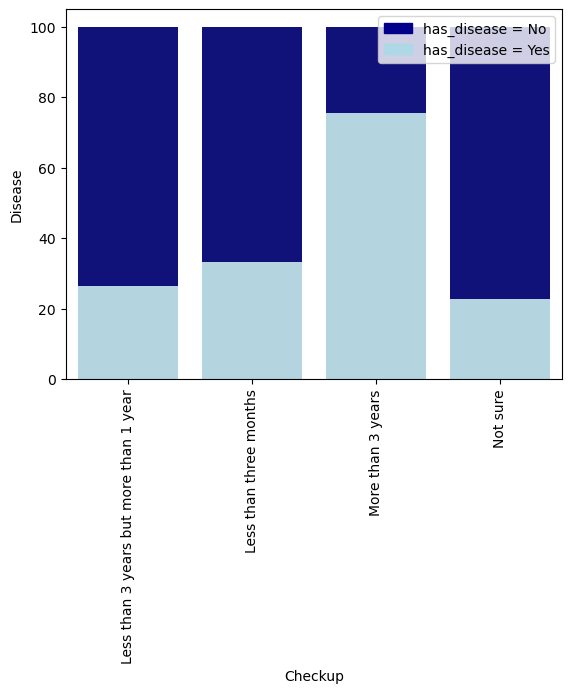

In [42]:
# Looking at the volumetry of the different values in "Checkup".
target = 'Disease'
variable_name = 'Checkup'
plot_categorical_volumetry(data_set, target, variable_name)

In [43]:
# We will be grouping "Less than 3 months" with "Less than 3 years but more than 1 year"
# as their volumetry is very similar and we have little observations with "Less than 3 months".
# We will be doing this both for the training data set, as for the test data set.
data_categorical.loc[data_categorical["Checkup"]=="Less than three months","Checkup"]="Less than 3 years but more than 1 year"
test_categorical.loc[test_categorical["Checkup"]=="Less than three months","Checkup"]="Less than 3 years but more than 1 year"

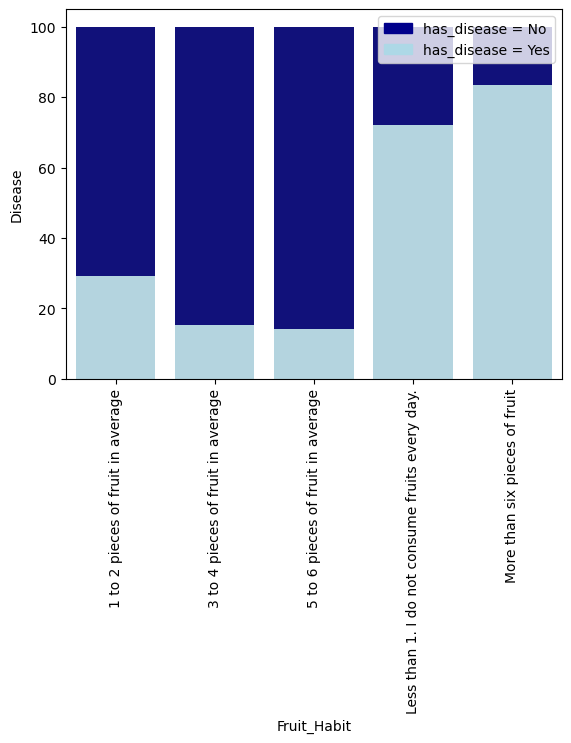

In [44]:
# Looking at the volumetry of the different values in "Fruit_Habit".
# As the volumetry of "More than six pieces of fruit" is very different
# from the volumetry of the other values, including "5 to 6 pieces of fruit in average"
# we are not going to group this values.
target = 'Disease'
variable_name = 'Fruit_Habit'
plot_categorical_volumetry(data_set, target, variable_name)

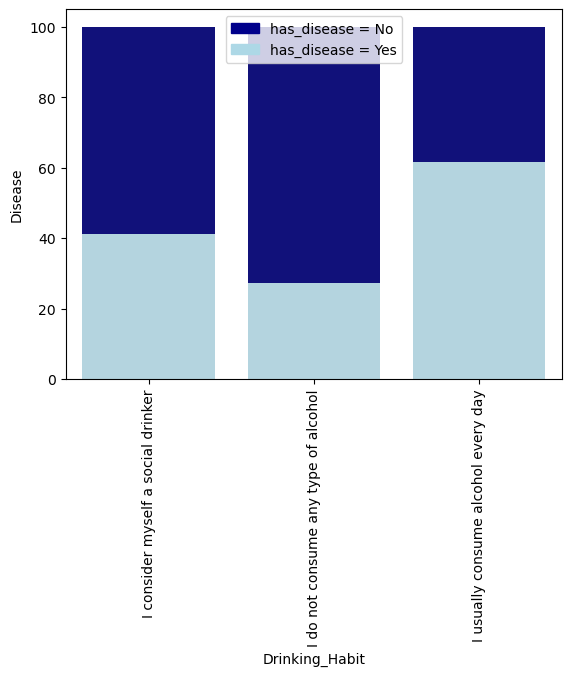

In [45]:
# Looking at the volumetry of the different values in "Drinking_Habit".
# As the volumetry of "I do not consume any type of alcohol" is very different
# from the volumetry of the other values, including "I consider myself a social drinker"
# we are not going to group this values.
target = 'Disease'
variable_name = 'Drinking_Habit'
plot_categorical_volumetry(data_set, target, variable_name)

#### 2.2.3. Feature Engineering of Categorical Features for the Training and Test Set

- Creating column "Gender" from the formal title (Mr. and Mrs.) obtained in column "Name". Dropping the respective column "Name".
- Creating colum "Region_Grouped" from each one of the 9 different regions we have in column "Region". As of now we are not dropping column "Region" as it may still be useful.

In [46]:
# Creating a column called "Gender" based on the formal title, which can be extracted from the column "Name".
data_categorical['Gender'] = data_categorical['Name'].str.extract('(Mrs.)', 0).fillna('Mr.')
data_categorical.loc[data_categorical['Gender']=='Mrs.', 'Gender'] = 'Women'
data_categorical.loc[data_categorical['Gender']=='Mr.', 'Gender'] = 'Men'
data_categorical[['Name', 'Gender']].head()

Name Gender
PatientID                           
1167       Mrs. Stephanie Gay  Women
1805         Mr. Sherman Nero    Men
1557          Mr. Mark Boller    Men
1658         Mr. David Caffee    Men
1544         Mr. Gerald Emery    Men

In [47]:
# We will have to do the same feature engineering for the test set.
test_categorical['Gender'] = test_categorical['Name'].str.extract('(Mrs.)', 0).fillna('Mr.')
test_categorical.loc[test_categorical['Gender']=='Mrs.', 'Gender'] = 'Women'
test_categorical.loc[test_categorical['Gender']=='Mr.', 'Gender'] = 'Men'

In [48]:
# Dropping the column "Name" as it will give us low information about a person
# having the disease or not. Doing both for the training data set and test
# data set.
data_categorical = data_categorical.drop('Name', axis=1)
test_categorical = test_categorical.drop('Name',axis=1)

In [49]:
# Grouping the different regions based on their original region.
data_categorical['Region_Grouped'] = np.select(
    [
       data_categorical['Region'].str.contains('^South'),
       data_categorical['Region'].str.contains('^West'),
       data_categorical['Region'].str.contains('^East'),
       data_categorical['Region'].str.contains('^North'),
    ],
    [
        'South',
        'West',
        'East',
        'North'
    ],
    default=None
)
data_categorical['Region_Grouped'].fillna(data_categorical['Region'], inplace=True)
data_categorical[['Region', 'Region_Grouped']].head()

Region            Region_Grouped
PatientID                                                    
1167                         London                    London
1805                     South West                     South
1557       Yorkshire and the Humber  Yorkshire and the Humber
1658                         London                    London
1544                     South East                     South

In [50]:
# We will have to do the same feature engineering for the test set.
test_categorical['Region_Grouped'] = np.select(
    [
       test_categorical['Region'].str.contains('^South'),
       test_categorical['Region'].str.contains('^West'),
       test_categorical['Region'].str.contains('^East'),
       test_categorical['Region'].str.contains('^North'),
    ],
    [
        'South',
        'West',
        'East',
        'North'
    ],
    default=None
)
test_categorical['Region_Grouped'].fillna(test_categorical['Region'], inplace=True)

In [51]:
# Checking the values for the new column "Region_Grouped".
data_categorical["Region_Grouped"].value_counts()

East                        234
South                       191
London                      141
West                         89
North                        81
Yorkshire and the Humber     64
Name: Region_Grouped, dtype: int64

In [52]:
# Updating the categorical features after the previous feature engineering.
# Removing "Name" and adding "Gender" and "Region_Grouped".
categorical_features.remove("Name")
categorical_features.append("Gender")
categorical_features.append("Region_Grouped")

#### 2.2.4. Categorical Features Volumetry - After Treatment

In [53]:
# Including "Disease" in the categorical features as we need it in our
# data categorical in order to use the function "plot_categorical_volumetry"
# we defined in the beggining.
data_categorical.loc[:,"Disease"]=data_set["Disease"]

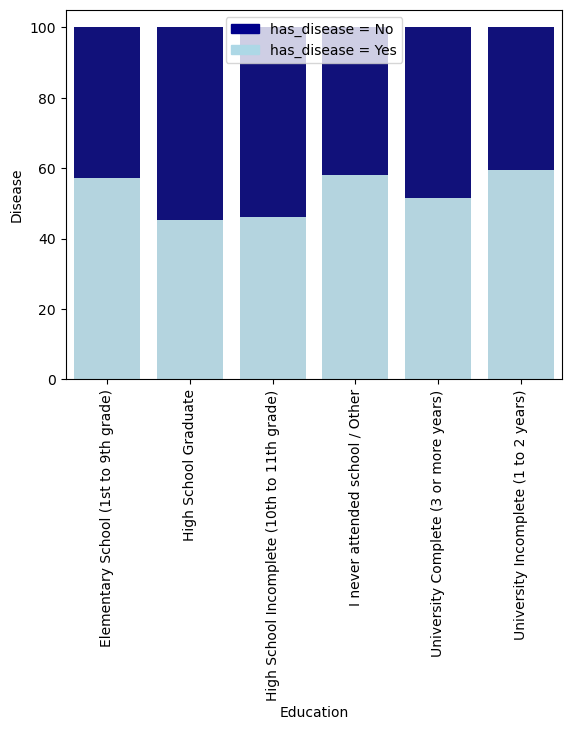

In [54]:
# Looking at the volumetry of "Education".
target = 'Disease'
variable_name = 'Education'
plot_categorical_volumetry(data_categorical, target, variable_name)

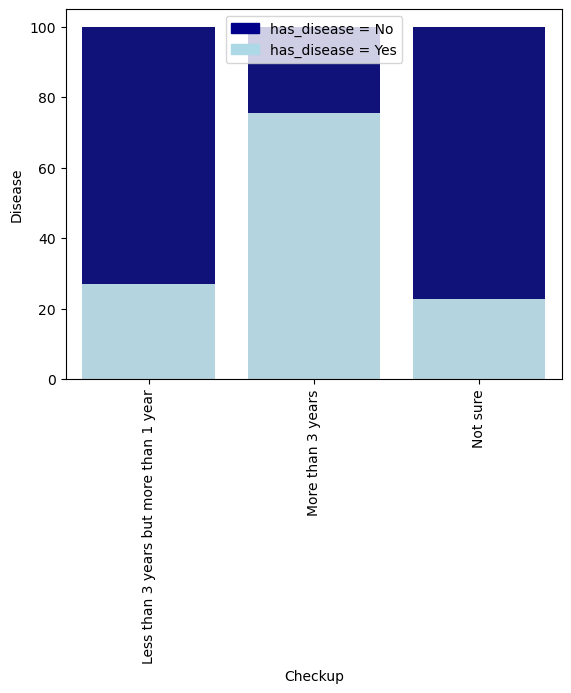

In [55]:
# Looking at the volumetry of "Checkup".
target = 'Disease'
variable_name = 'Checkup'
plot_categorical_volumetry(data_categorical, target, variable_name)

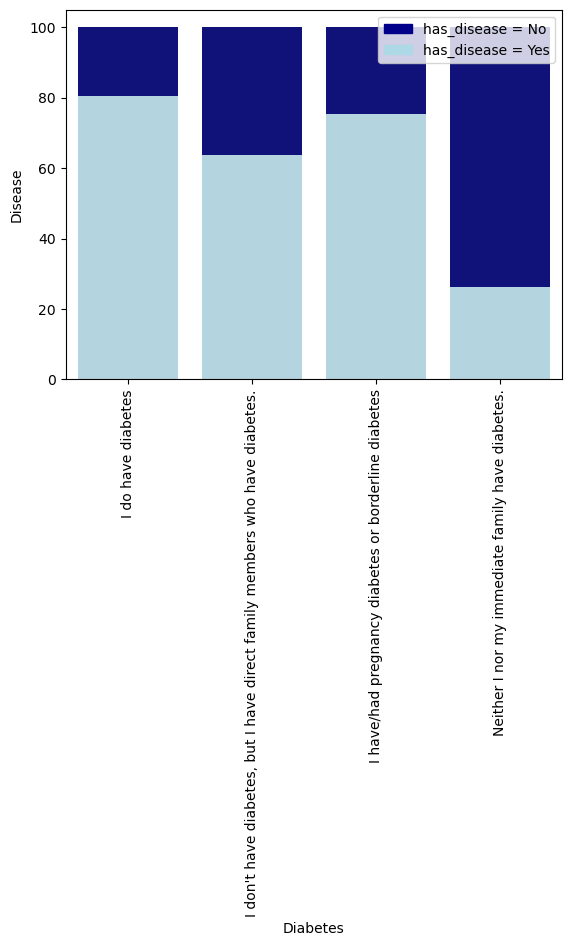

In [56]:
# Looking at the volumetry of "Diabetes".
target = 'Disease'
variable_name = 'Diabetes'
plot_categorical_volumetry(data_categorical, target, variable_name)

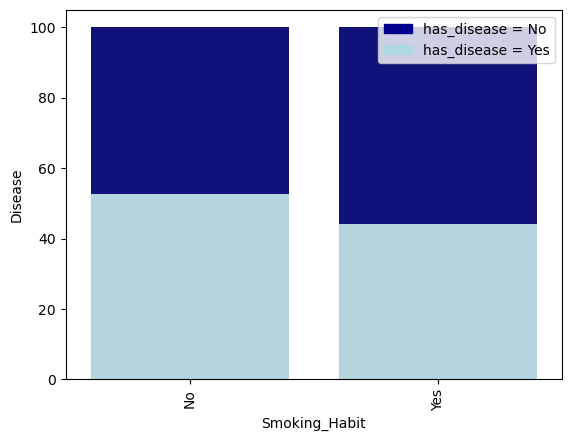

In [57]:
# Looking at the volumetry of "Smoking_Habit".
target = 'Disease'
variable_name = 'Smoking_Habit'
plot_categorical_volumetry(data_categorical, target, variable_name)

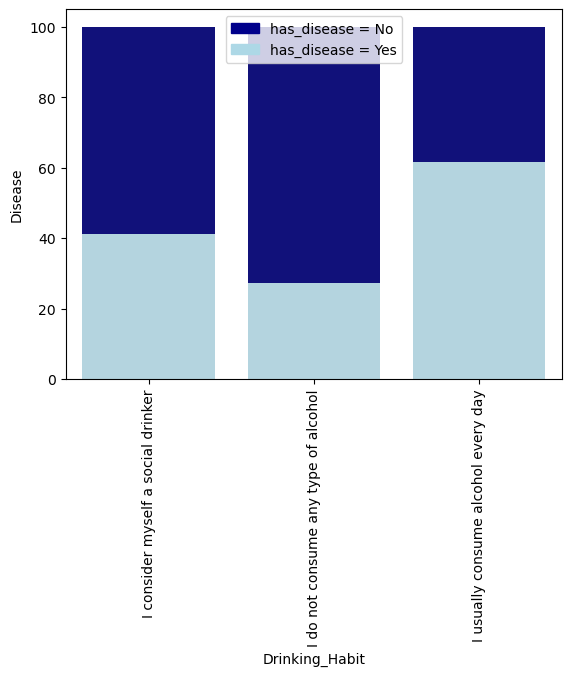

In [58]:
# Looking at the volumetry of "Drinking_Habit".
target = 'Disease'
variable_name = 'Drinking_Habit'
plot_categorical_volumetry(data_categorical, target, variable_name)

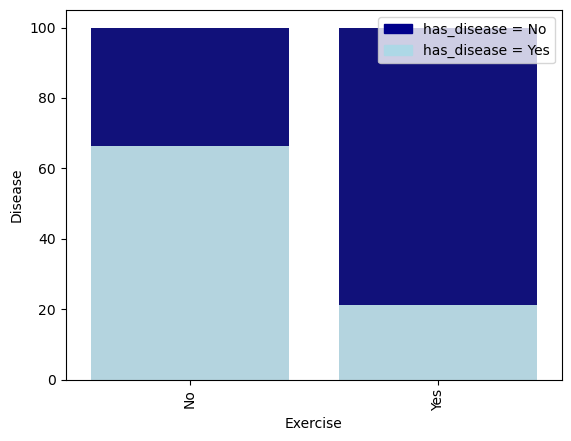

In [59]:
# Looking at the volumetry of "Exercise".
target = 'Disease'
variable_name = 'Exercise'
plot_categorical_volumetry(data_categorical, target, variable_name)

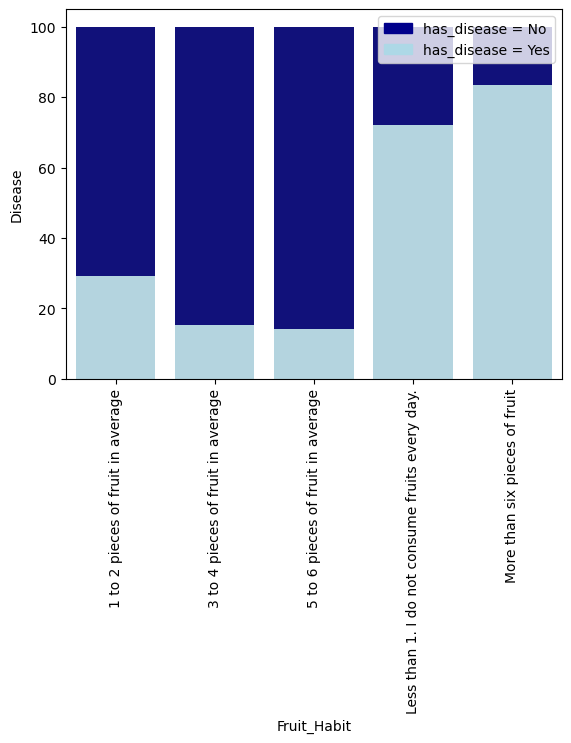

In [60]:
# Looking at the volumetry of "Fruit_Habit".
target = 'Disease'
variable_name = 'Fruit_Habit'
plot_categorical_volumetry(data_categorical, target, variable_name)

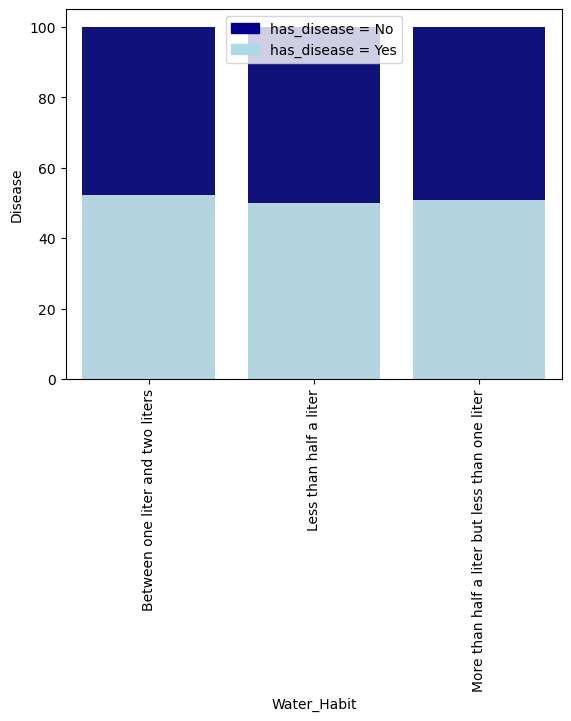

In [61]:
# Looking at the volumetry of "Water_Habit".
target = 'Disease'
variable_name = 'Water_Habit'
plot_categorical_volumetry(data_categorical, target, variable_name)

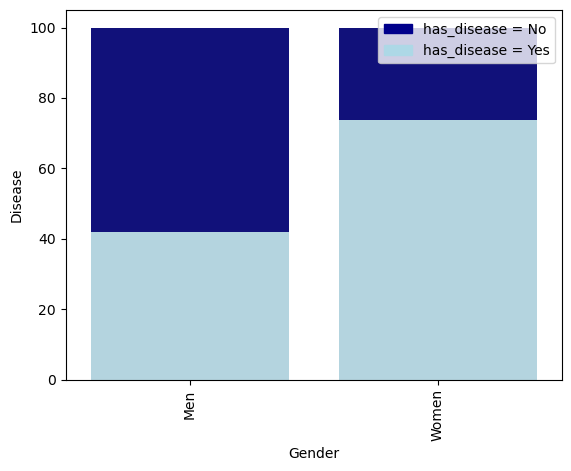

In [62]:
# Looking at the volumetry of "Gender".
target = 'Disease'
variable_name = 'Gender'
plot_categorical_volumetry(data_categorical, target, variable_name)

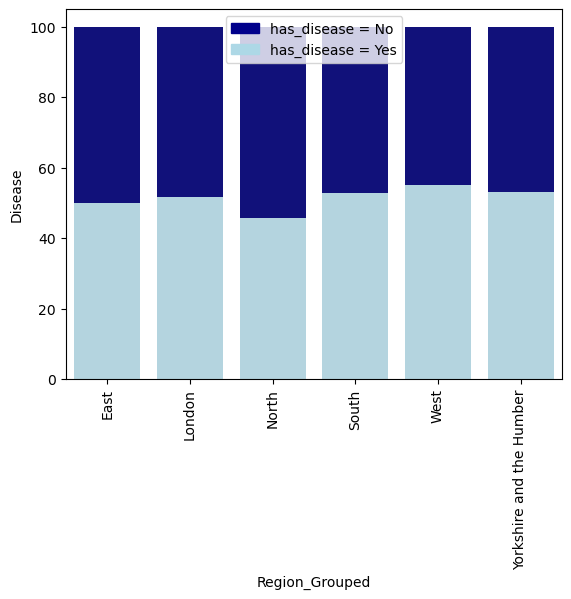

In [63]:
# Looking at the volumetry of "Region_Grouped".
target = 'Disease'
variable_name = 'Region_Grouped'
plot_categorical_volumetry(data_categorical, target, variable_name)

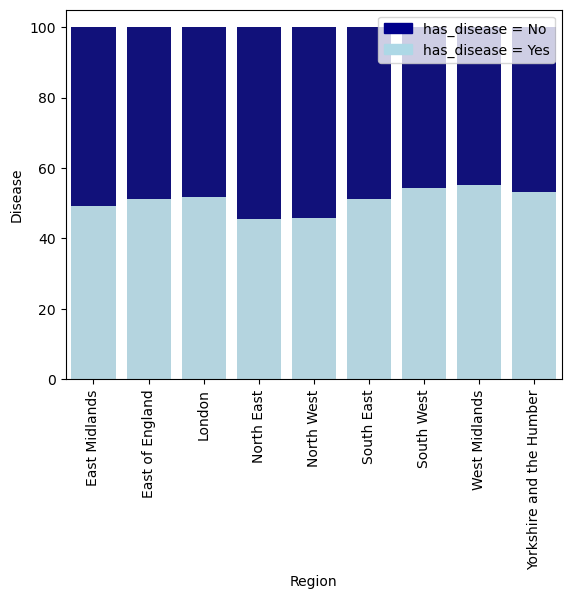

In [64]:
# Looking at the volumetry of "Region".
target = 'Disease'
variable_name = 'Region'
plot_categorical_volumetry(data_categorical, target, variable_name)

#### 2.2.5. One-Hot Encoding for Categorical Variables in Training and Test Set

In [65]:
# Dropping the target "Disease" from "data_categorical" as we no
# longer need it.
data_categorical.drop(['Disease'], axis=1, inplace=True)

In [66]:
# Defining a variable for our model "OneHotEnconder" and fitting it to
# to our categorical features in the training data.
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
one_hot_encoder_fitting=one_hot_encoder.fit(data_categorical)

In [67]:
# Transforming our categorical features of the training set with One Hot Enconding and
# assigning them to a DataFrame called "data_categorical_one_hot_encoded".
one_hot_encoder_transform=one_hot_encoder.transform(data_categorical)
one_hot_encoder_feat_names=one_hot_encoder.get_feature_names_out()
data_categorical_one_hot_encoded = pd.DataFrame(one_hot_encoder_transform, index=data_categorical.index, columns=one_hot_encoder_feat_names)
data_categorical_one_hot_encoded.head()

Region_East of England  Region_London  Region_North East  \
PatientID                                                             
1167                          0.0            1.0                0.0   
1805                          0.0            0.0                0.0   
1557                          0.0            0.0                0.0   
1658                          0.0            1.0                0.0   
1544                          0.0            0.0                0.0   

           Region_North West  Region_South East  Region_South West  \
PatientID                                                            
1167                     0.0                0.0                0.0   
1805                     0.0                0.0                1.0   
1557                     0.0                0.0                0.0   
1658                     0.0                0.0                0.0   
1544                     0.0                1.0                0.0   

           Region_West Midlands  Region_Yorkshire and the Humber  \
PatientID                                                          
1167                        0.0                              0.0   
1805                        0.0                              0.0   
1557                        0.0                              1.0   
1658                        0.0                              0.0   
1544                        0.0                              0.0   

           Education_High School Graduate  \
PatientID                                   
1167                                  0.0   
1805                                  0.0   
1557                                  0.0   
1658                                  0.0   
1544                                  0.0   

           Education_High School Incomplete (10th to 11th grade)  ...  \
PatientID                                                         ...   
1167                                                     1.0      ...   
1805                                                     1.0      ...   
1557                                                     0.0      ...   
1658                                                     0.0      ...   
1544                                                     0.0      ...   

           Fruit_Habit_Less than 1. I do not consume fruits every day.  \
PatientID                                                                
1167                                                     1.0             
1805                                                     1.0             
1557                                                     1.0             
1658                                                     1.0             
1544                                                     0.0             

           Fruit_Habit_More than six pieces of fruit  \
PatientID                                              
1167                                             0.0   
1805                                             0.0   
1557                                             0.0   
1658                                             0.0   
1544                                             0.0   

           Water_Habit_Less than half a liter  \
PatientID                                       
1167                                      0.0   
1805                                      0.0   
1557                                      0.0   
1658                                      0.0   
1544                                      0.0   

           Water_Habit_More than half a liter but less than one liter  \
PatientID                                                               
1167                                                     0.0            
1805                                                     0.0            
1557                                                     1.0            
1658                                                     1.0            
1544                   

In [68]:
# Transforming our categorical features of the test set with One Hot Enconding and
# assigning them to a DataFrame called "test_categorical_one_hot_encoded". Important
# to notice here that we want to use the "OneHotEnconder" that was fitted with the categorical
# features from the train set.
one_hot_encoder_transform1=one_hot_encoder.transform(test_categorical)
one_hot_encoder_feat_names1=one_hot_encoder.get_feature_names_out()
test_categorical_one_hot_encoded=pd.DataFrame(one_hot_encoder_transform1, index=test_categorical.index, columns=one_hot_encoder_feat_names1)
test_categorical_one_hot_encoded.head()

Region_East of England  Region_London  Region_North East  \
PatientID                                                             
1343                          0.0            0.0                0.0   
1727                          0.0            0.0                0.0   
1828                          0.0            0.0                0.0   
1155                          0.0            0.0                0.0   
1020                          0.0            0.0                0.0   

           Region_North West  Region_South East  Region_South West  \
PatientID                                                            
1343                     0.0                0.0                0.0   
1727                     0.0                0.0                0.0   
1828                     0.0                0.0                0.0   
1155                     0.0                0.0                0.0   
1020                     0.0                0.0                0.0   

           Region_West Midlands  Region_Yorkshire and the Humber  \
PatientID                                                          
1343                        0.0                              0.0   
1727                        0.0                              1.0   
1828                        1.0                              0.0   
1155                        0.0                              1.0   
1020                        0.0                              0.0   

           Education_High School Graduate  \
PatientID                                   
1343                                  0.0   
1727                                  0.0   
1828                                  0.0   
1155                                  0.0   
1020                                  0.0   

           Education_High School Incomplete (10th to 11th grade)  ...  \
PatientID                                                         ...   
1343                                                     0.0      ...   
1727                                                     0.0      ...   
1828                                                     1.0      ...   
1155                                                     1.0      ...   
1020                                                     1.0      ...   

           Fruit_Habit_Less than 1. I do not consume fruits every day.  \
PatientID                                                                
1343                                                     1.0             
1727                                                     1.0             
1828                                                     1.0             
1155                                                     1.0             
1020                                                     1.0             

           Fruit_Habit_More than six pieces of fruit  \
PatientID                                              
1343                                             0.0   
1727                                             0.0   
1828                                             0.0   
1155                                             0.0   
1020                                             0.0   

           Water_Habit_Less than half a liter  \
PatientID                                       
1343                                      0.0   
1727                                      0.0   
1828                                      0.0   
1155                                      1.0   
1020                                      1.0   

           Water_Habit_More than half a liter but less than one liter  \
PatientID                                                               
1343                                                     0.0            
1727                                                     1.0            
1828                                                     0.0            
1155                                                     0.0            
1020                   

### 2.3. Numerical Features

In [69]:
# Creating a DataFrame that includes only the numerical features, as
# we don't want to perform changes in the original DataFrame. Doing it 
# for both the training set and test set.
data_numerical = data_set[numerical_features].copy()
test_numerical = test_set[numerical_features].copy()

In [70]:
# Checking if we indexed the right DataFrame.
data_numerical.head()

Birth_Year  Height  Weight  High_Cholesterol  Blood_Pressure  \
PatientID                                                                 
1167             1965     155      67               358             120   
1805             1969     173      88               230             142   
1557             1974     162      68               226             122   
1658             1958     180      66               313             125   
1544             1968     180      58               277             125   

           Mental_Health  Physical_Health  
PatientID                                  
1167                  21                2  
1805                   9                0  
1557                  26                0  
1658                  13                8  
1544                  18                2

#### 2.3.1. Feature Engineering of Numerical Features for the Training and Test Set

- Creating a new column "Age" from the column "Birth_Year", as it is easier to interpret. Dropping the column "Birht_Year", as it gives the same information as column "Age".

- Creating a new column "Body Mass Index" from the combination of the column "Height" and "Weight" as it may help us decrease dimensionality, and have a feature that is more rich than just having "Height" and "Weight" individually.

In [71]:
# Creating the new column "Age" from the column "Birth_Year". As it is not
# stated elsewhere, we are going to assume this data set to be from 2022. Doing it 
# for both the training set and test set.
data_numerical["Age"]=2022-data_numerical["Birth_Year"]
test_numerical["Age"]=2022-test_numerical["Birth_Year"]

In [72]:
# We drop the column "Birt_Year", as it gives the same information as the
# newly created column. Doing it for both the training set and test set.
data_numerical.drop(["Birth_Year"],axis=1,inplace=True)
test_numerical.drop(["Birth_Year"],axis=1,inplace=True)

In [73]:
# Creating the new column "Body Mass Index" as a way to decrease dimensionality, and have
# the information of two features in a single feature. Doing it for both the training
# set and test set.
data_numerical['Body Mass Index']=round(data_numerical['Weight']/((data_numerical['Height']/100)**2), 2)
test_numerical["Body Mass Index"]=round(test_numerical["Weight"]/((test_numerical["Height"]/100)**2), 2)
data_numerical[['Weight','Height','Body Mass Index']].head()

Weight  Height  Body Mass Index
PatientID                                 
1167           67     155            27.89
1805           88     173            29.40
1557           68     162            25.91
1658           66     180            20.37
1544           58     180            17.90

In [74]:
# Updating the numerical features after the previous feature engineering.
# Removing "Birth_Year" and adding "Age" and "Body Mass Index".
numerical_features.remove("Birth_Year")
numerical_features.append("Age")
numerical_features.append("Body Mass Index")

#### 2.3.2. Plots for Numerical Features of the Training Set (Pre-Outlier Removal)

In [75]:
# Including "Disease" in the numerical features as we need it in our
# data numerical in order to use the function "plot_histogram_and_boxplot_univariative"
# we defined in the beggining.
data_numerical.loc[:,"Disease"]=data_set["Disease"]

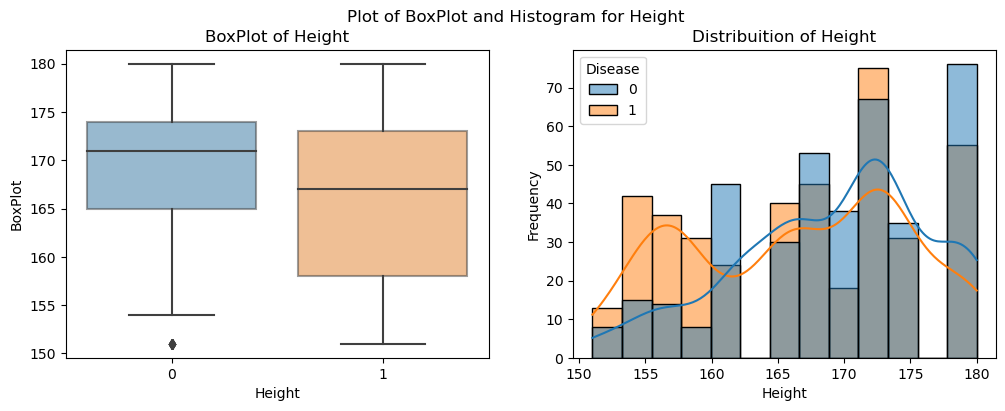

In [76]:
# Plotting the distribution and boxplot for "Height".
variable = 'Height'
variable_name = 'Height'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

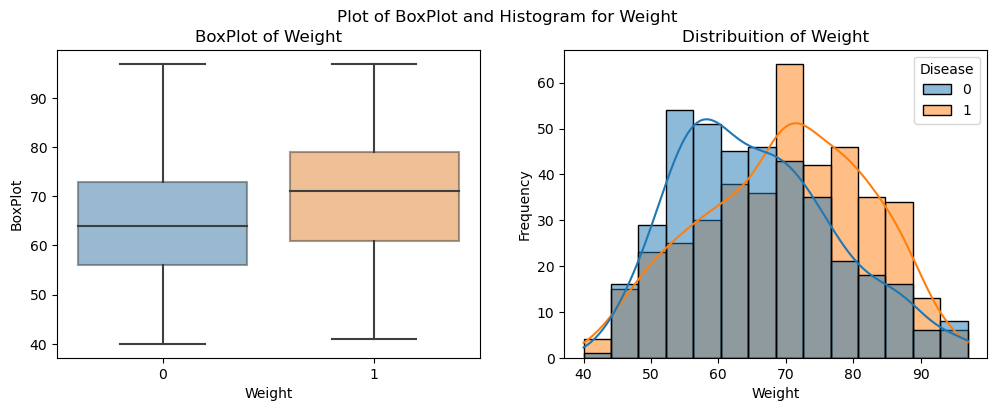

In [77]:
# Plotting the distribution and boxplot for "Weight".
variable = 'Weight'
variable_name = 'Weight'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

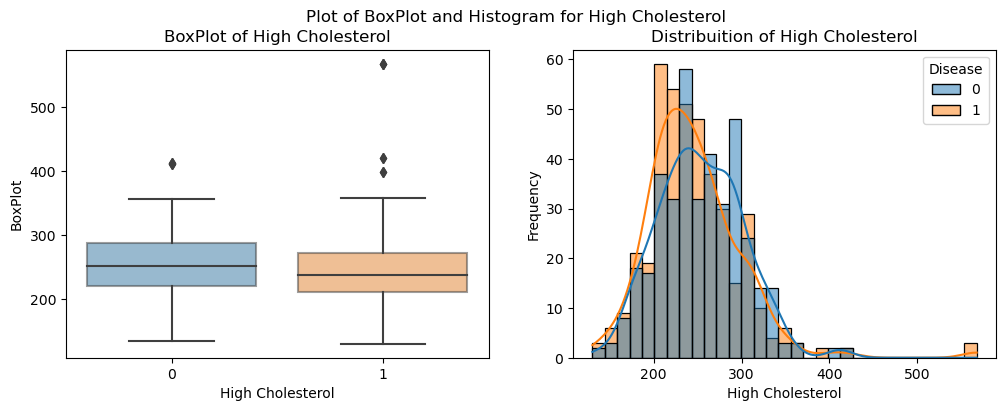

In [78]:
# Plotting the distribution and boxplot for "High_Cholesterol".
variable = 'High_Cholesterol'
variable_name = 'High Cholesterol'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

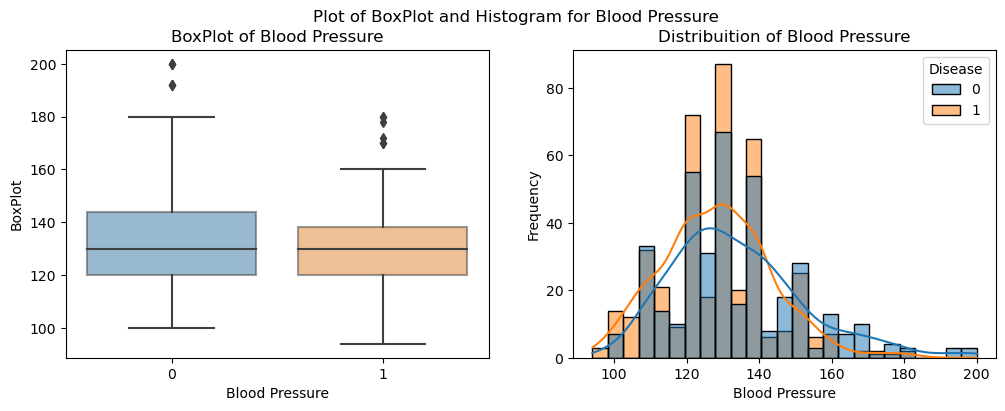

In [79]:
# Plotting the distribution and boxplot for "Blood_Pressure".
variable = 'Blood_Pressure'
variable_name = 'Blood Pressure'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

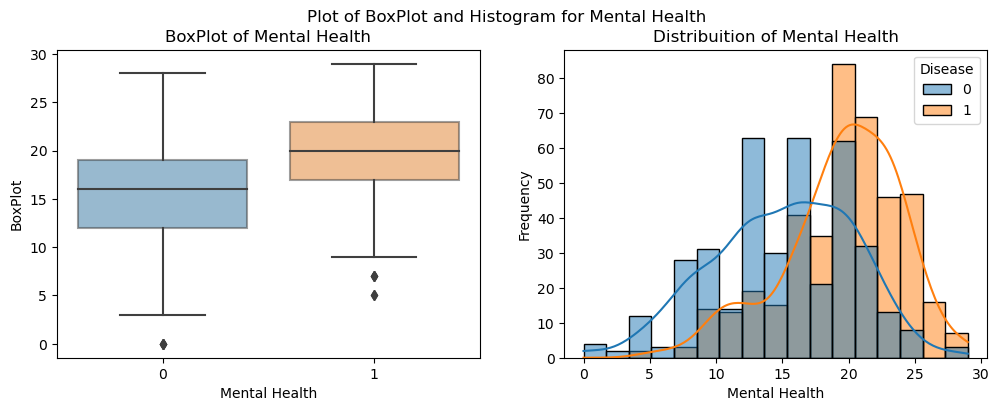

In [80]:
# Plotting the distribution and boxplot for "Mental_Health".
variable = 'Mental_Health'
variable_name = 'Mental Health'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

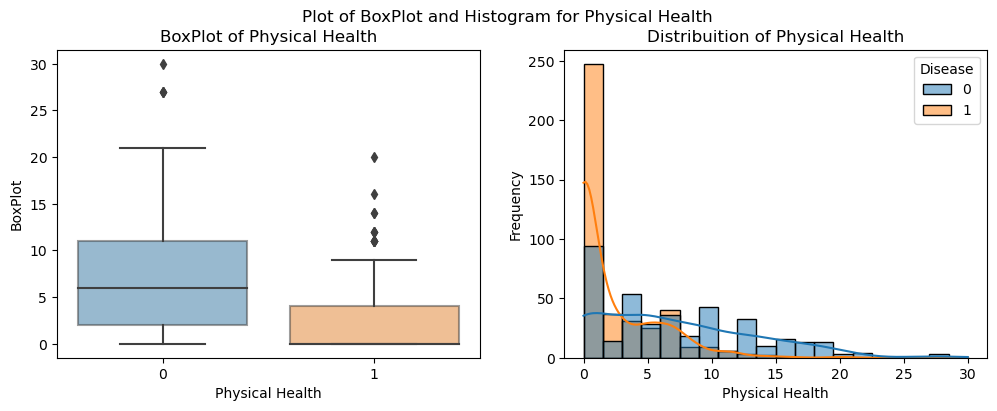

In [81]:
# Plotting the distribution and boxplot for "Physical_Health".
variable = 'Physical_Health'
variable_name = 'Physical Health'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

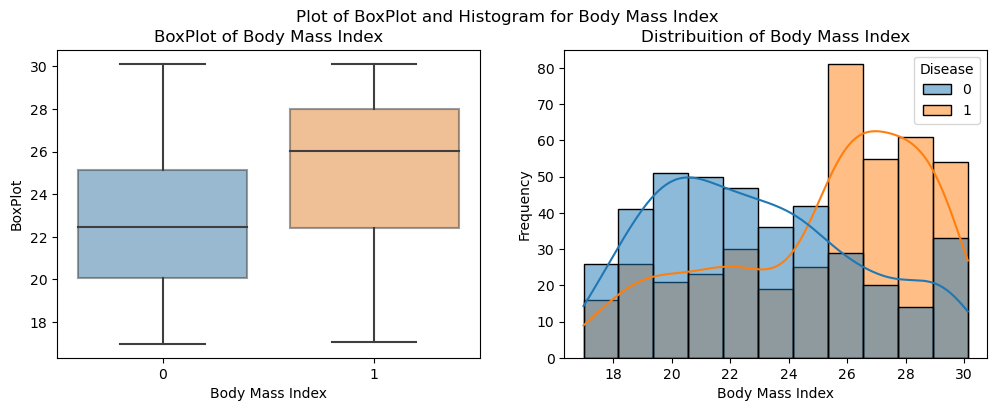

In [82]:
# Plotting the distribution and boxplot for "Body Mass Index".
variable = 'Body Mass Index'
variable_name = 'Body Mass Index'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

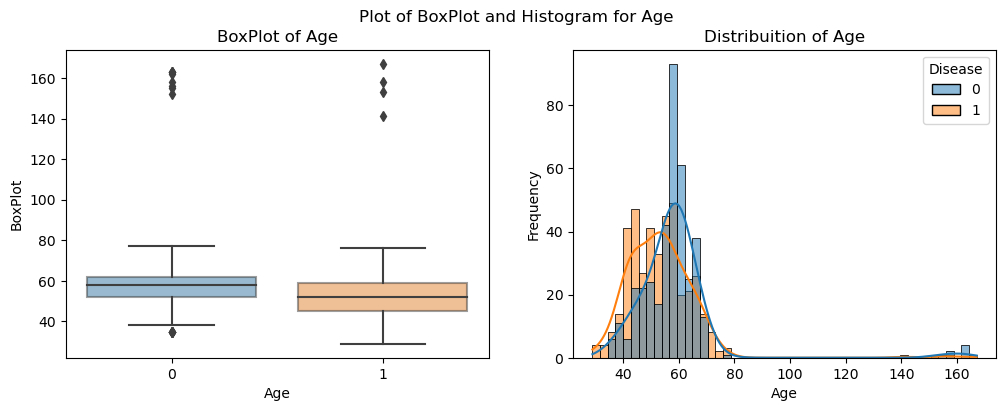

In [83]:
# Plotting the distribution and boxplot for "Age".
variable = 'Age'
variable_name = 'Age'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical, variable, variable_name, target)

#### 2.3.3. Pairwise Plot for all Numerical Features (Pre-Outlier Removal)

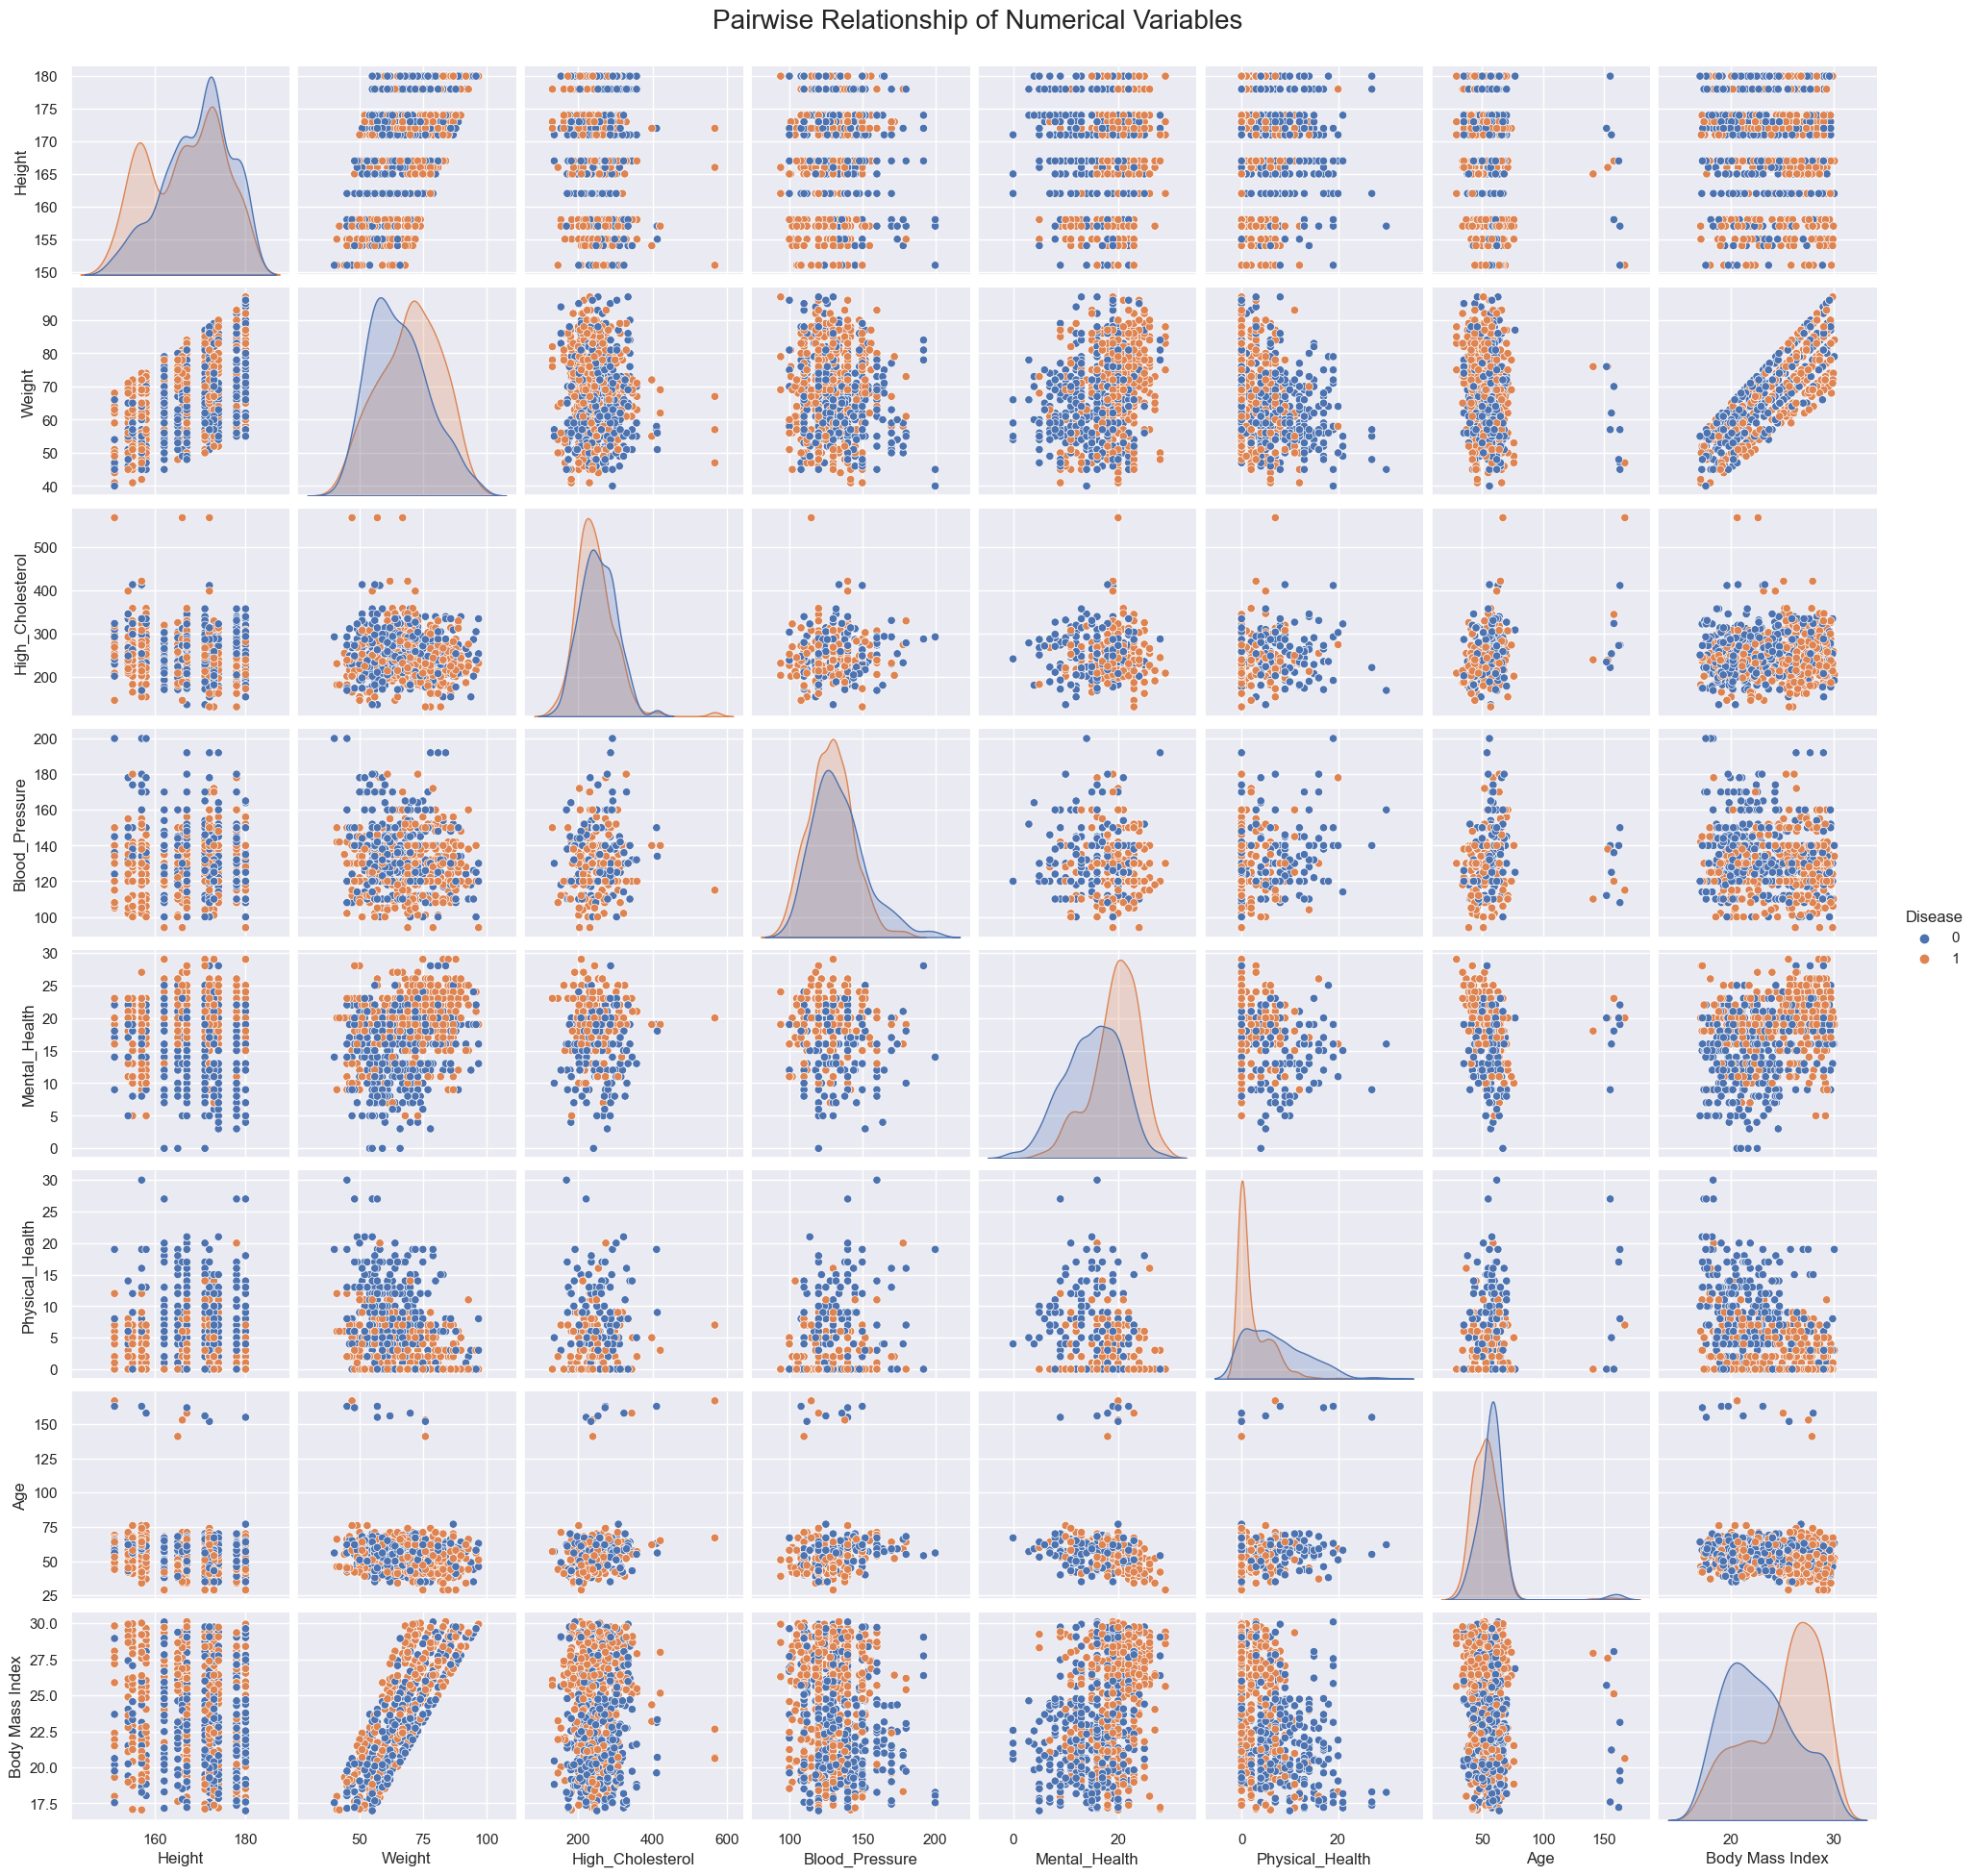

In [84]:
# Looking at the pairwise relation between the variables to find
# relations between them.
sns.set()
sns.pairplot(data_numerical, hue='Disease')
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables",fontsize=20)
plt.show()

#### 2.3.4. Correlation Plot for all Numerical Features (Pre-Outlier Removal)

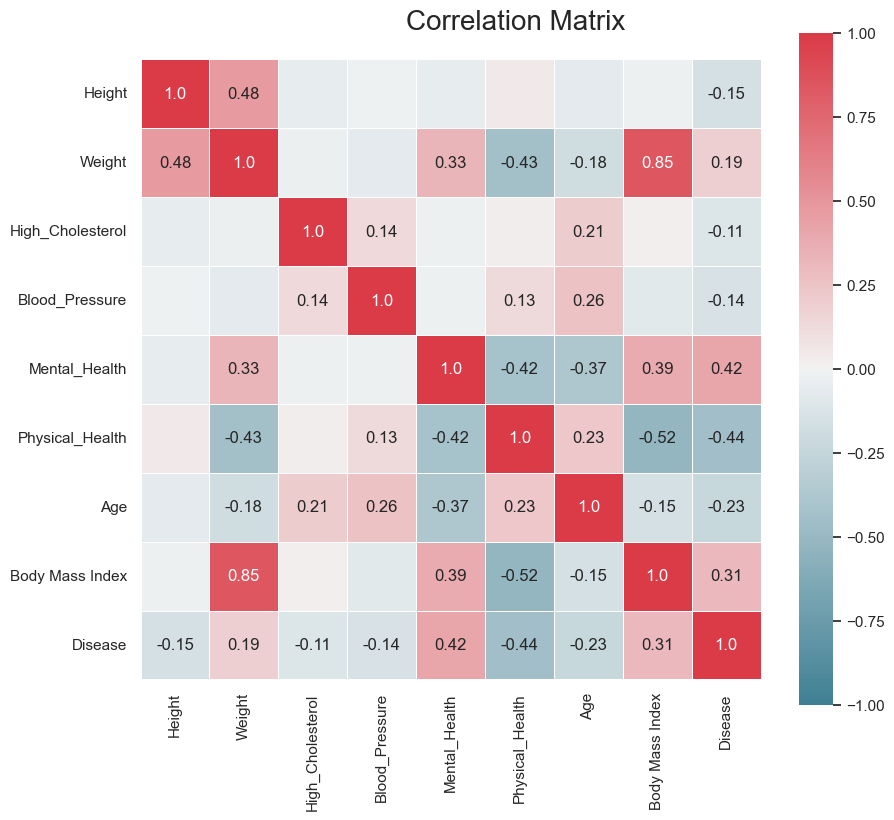

In [85]:
# Checking the correlation matrix for these variables. We don't have
# that high of correlations besides between "Heigh" and "Weight", and between
# "Body Mass Index" and "Weight".
fig = plt.figure(figsize=(10,8))
corr = np.round(
    data_numerical.corr(method="spearman"), decimals=2
    )
mask_annot=np.absolute(corr.values)>=0.1
annot=np.where(mask_annot, corr.values, np.full(corr.shape,""))
sns.heatmap(data=corr,annot=annot,cmap=sns.diverging_palette(220,10,as_cmap=True), 
            fmt='s',vmin=-1,vmax=1,center=0,square=True,linewidths=.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix",fontsize=20)
plt.show()

#### 2.3.5. Dataset Outlier Removal Function

- Creating a function to remove outliers from our numerical features. We are not removing them directly from the numerical data and training data because later we will want to divide our training data into a validation set, where we don't want to perform oulier removal, as it will be a proxy to the test set.

In [86]:
# Creating a function to remove outliers from our numerical features. It will remove
# any observation that within one of his features has a value +/- 1,5 IQR from the 1st
# and 3rd quantile of that specific feature.
def outlier_removal(df_to_remove,features):
    q25=df_to_remove.quantile(.25)
    q75=df_to_remove.quantile(.75)
    iqr=(q75-q25)

    upper_lim=q75+1.5*iqr
    lower_lim =q25-1.5*iqr

    filters=[]
    for metric in features:
        llim=lower_lim[metric]
        ulim=upper_lim[metric]
        filters.append(df_to_remove[metric].between(llim,ulim))

    filters = pd.Series(np.all(filters, 0))
    new_data_numerical = df_to_remove[filters.values]
    return new_data_numerical

In [87]:
# Applying the previously created function in our numerical data set and
# checking which percentage of the dataset did we remove. We kept 92% of the
# numerical data set by applying as criteria removing outliers +/- 1,5 IQR.
data_numerical_without_out=outlier_removal(data_numerical,numerical_features)
print('Percentage of data kept after removing outliers:', np.round(data_numerical_without_out.shape[0]/data_numerical.shape[0],4))

Percentage of data kept after removing outliers: 0.9225


#### 2.3.6. Plots for Numerical Features of the Training Set (Post-Outlier Removal)

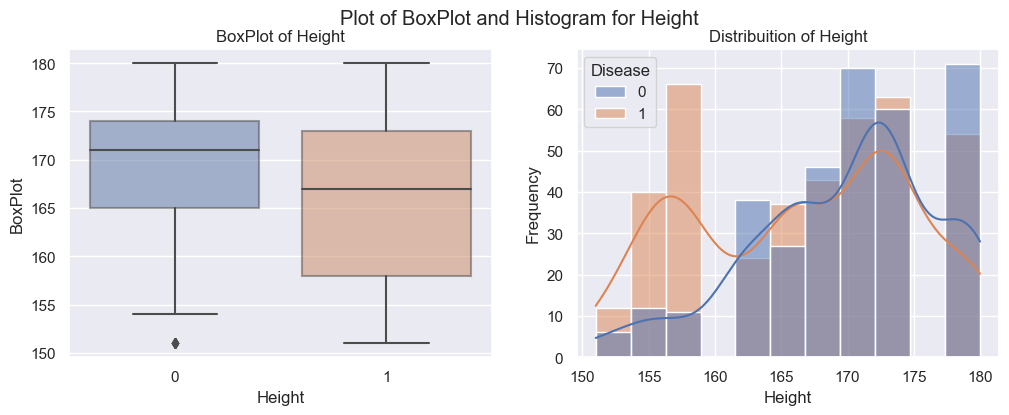

In [88]:
# Plotting the distribution and boxplot for "Height".
variable = 'Height'
variable_name = 'Height'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

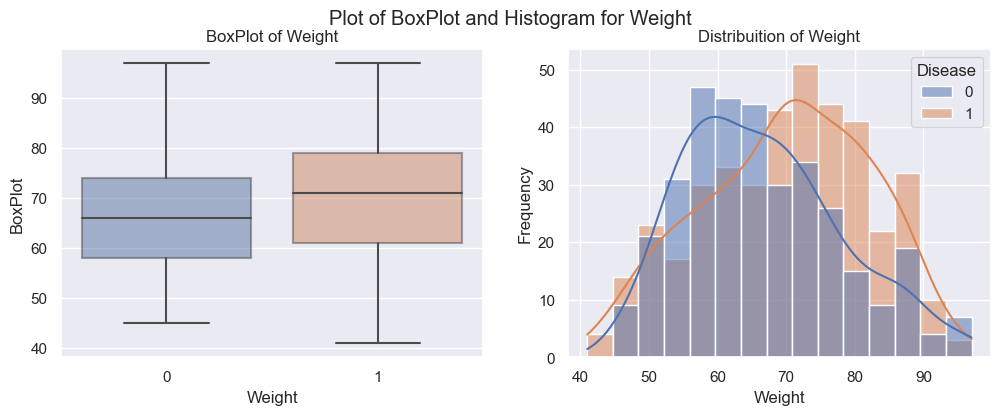

In [89]:
# Plotting the distribution and boxplot for "Weight".
variable = 'Weight'
variable_name = 'Weight'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

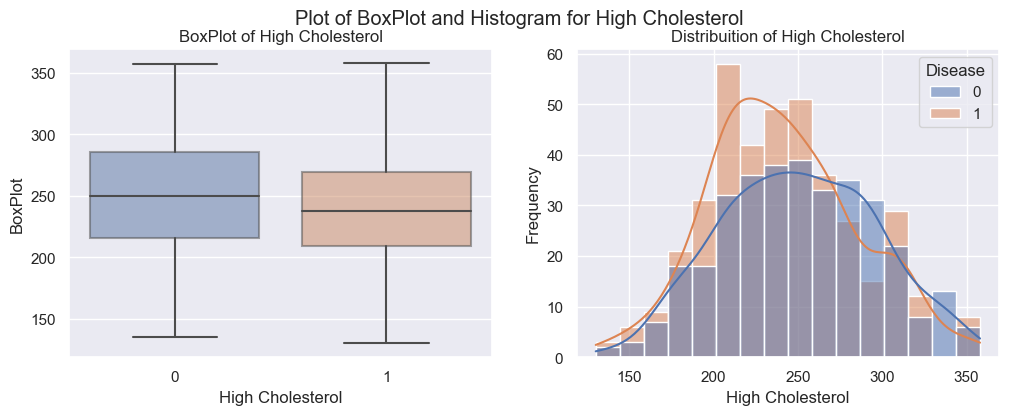

In [90]:
# Plotting the distribution and boxplot for "High_Cholesterol".
variable = 'High_Cholesterol'
variable_name = 'High Cholesterol'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

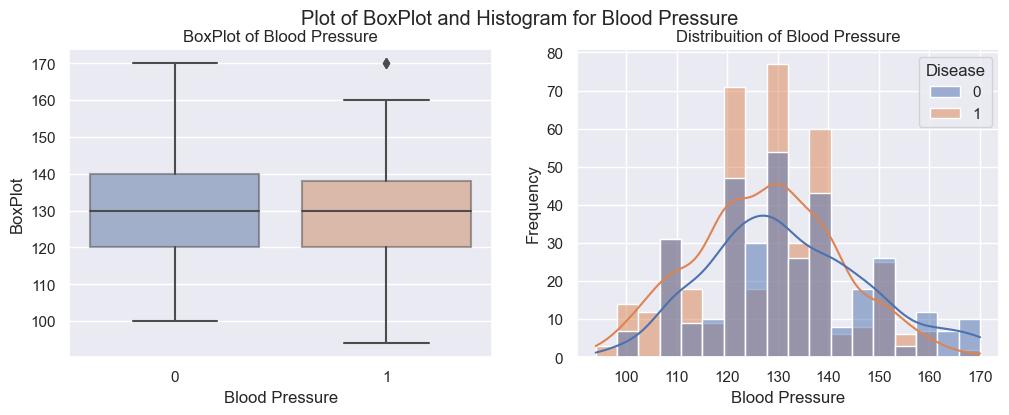

In [91]:
# Plotting the distribution and boxplot for "Blood_Pressure".
variable = 'Blood_Pressure'
variable_name = 'Blood Pressure'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

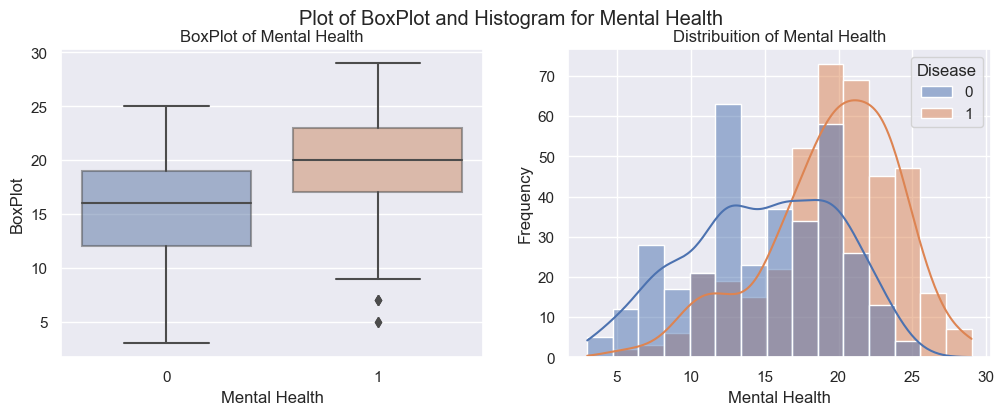

In [92]:
# Plotting the distribution and boxplot for "Mental_Health".
variable = 'Mental_Health'
variable_name = 'Mental Health'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

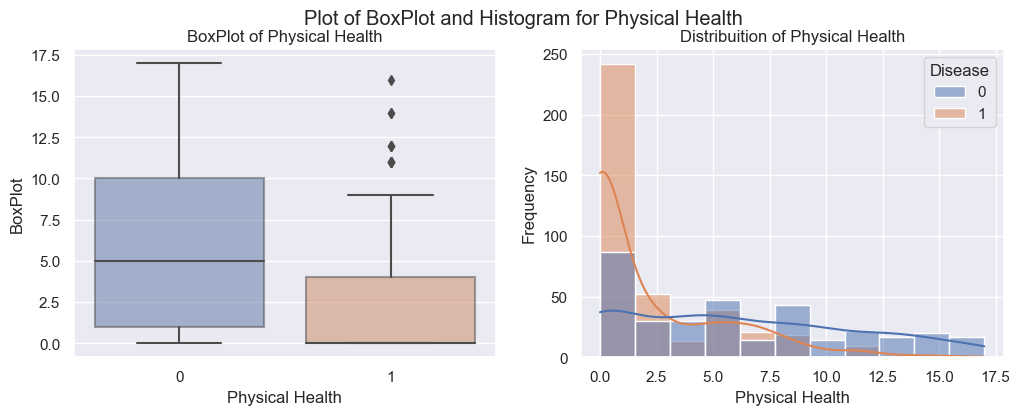

In [93]:
# Plotting the distribution and boxplot for "Physical_Health".
variable = 'Physical_Health'
variable_name = 'Physical Health'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

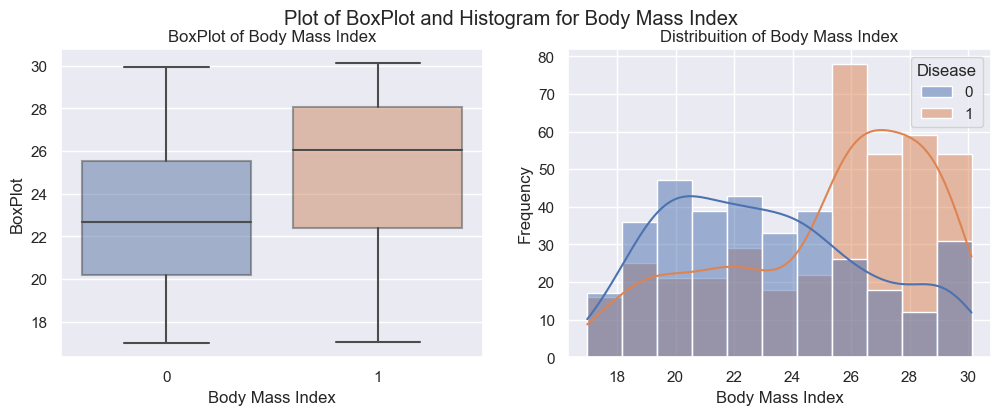

In [94]:
# Plotting the distribution and boxplot for "Body Mass Index".
variable = 'Body Mass Index'
variable_name = 'Body Mass Index'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

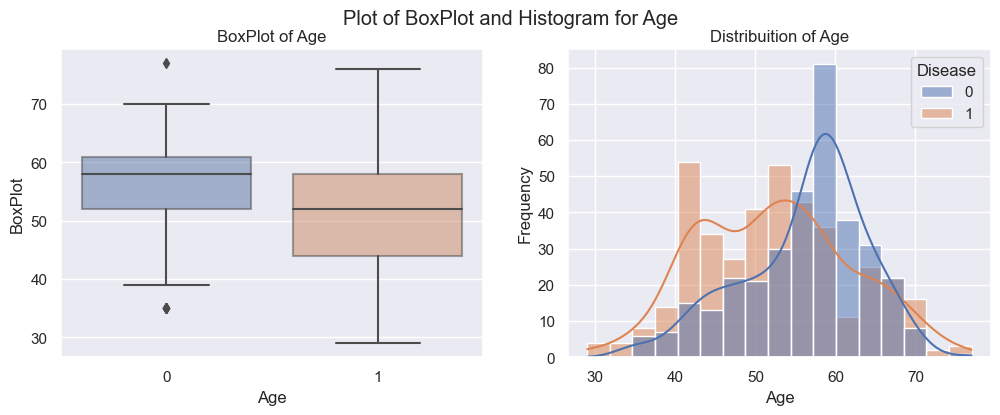

In [95]:
# Plotting the distribution and boxplot for "Age".
variable = 'Age'
variable_name = 'Age'
target = 'Disease'
plot_histogram_and_boxplot_univariative(data_numerical_without_out, variable, variable_name, target)

#### 2.3.7. Pairwise Plot for all Numerical Features (Post-Outlier Removal)

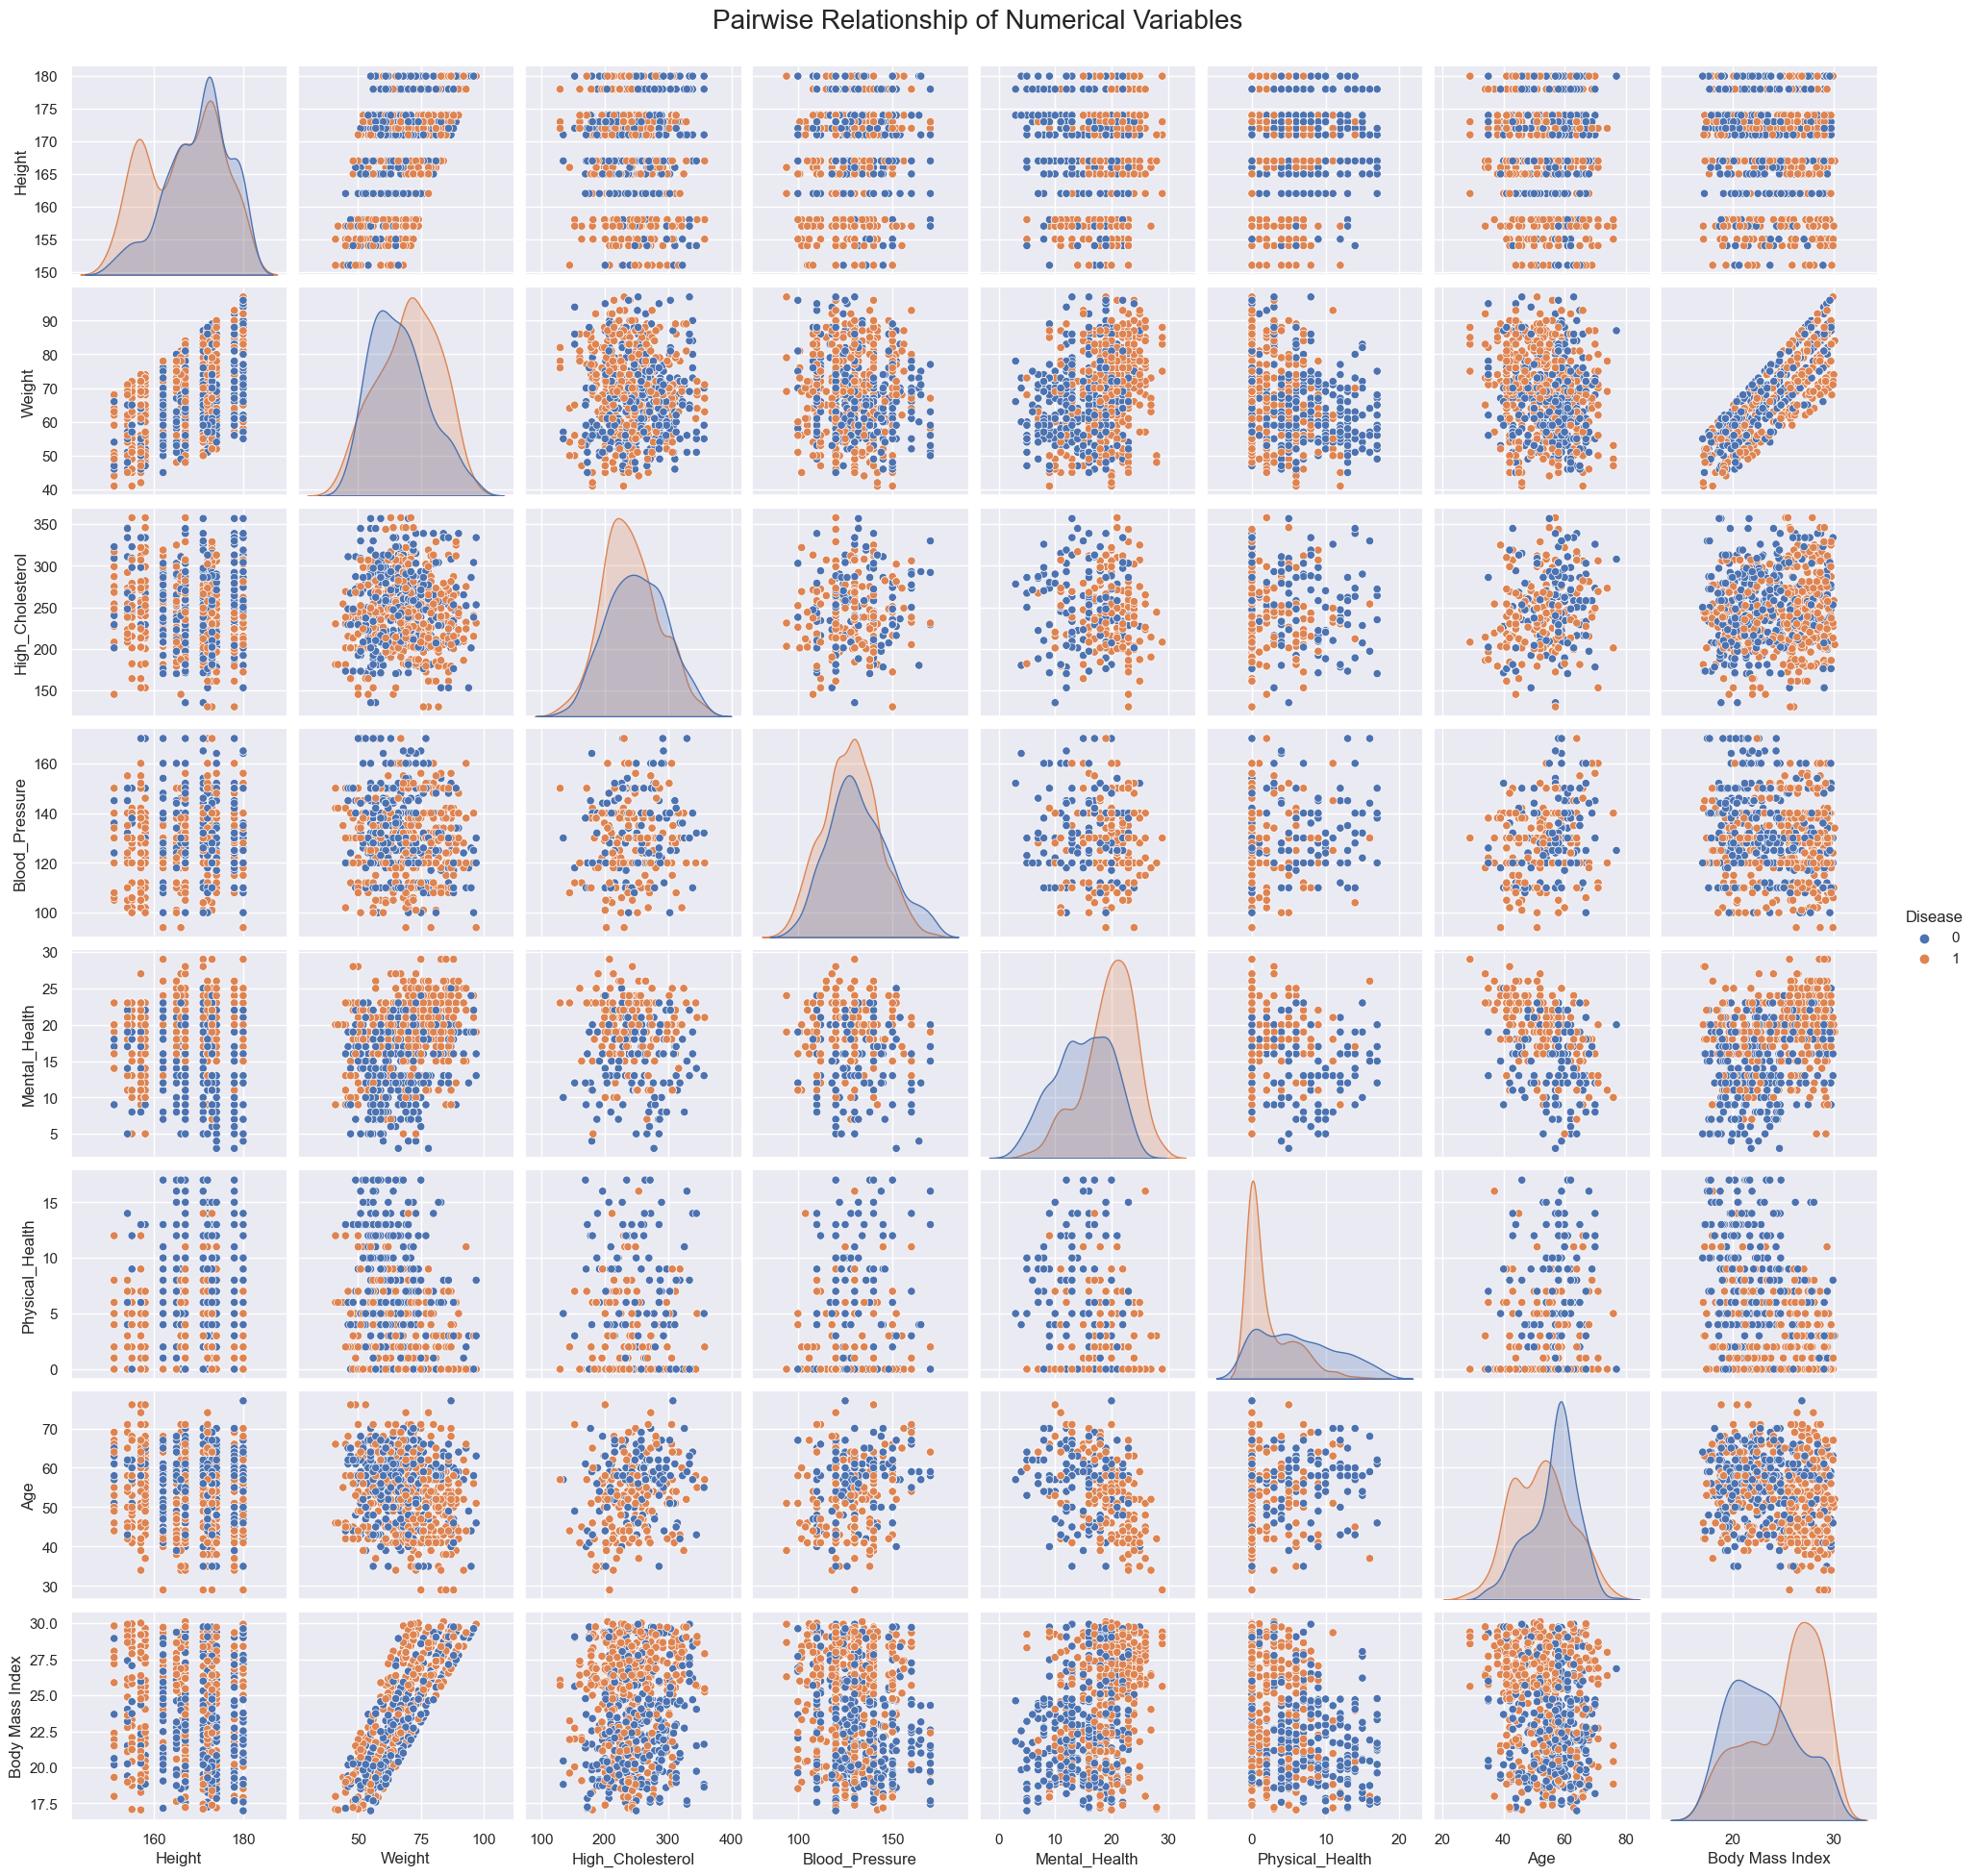

In [96]:
# Looking at the pairwise relation between the variables to find
# relations between them.
sns.set()
sns.pairplot(data_numerical_without_out, hue='Disease')
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables",fontsize=20)
plt.show()

#### 2.3.8. Correlation Plot for all Numerical Features (Post-Outlier Removal)

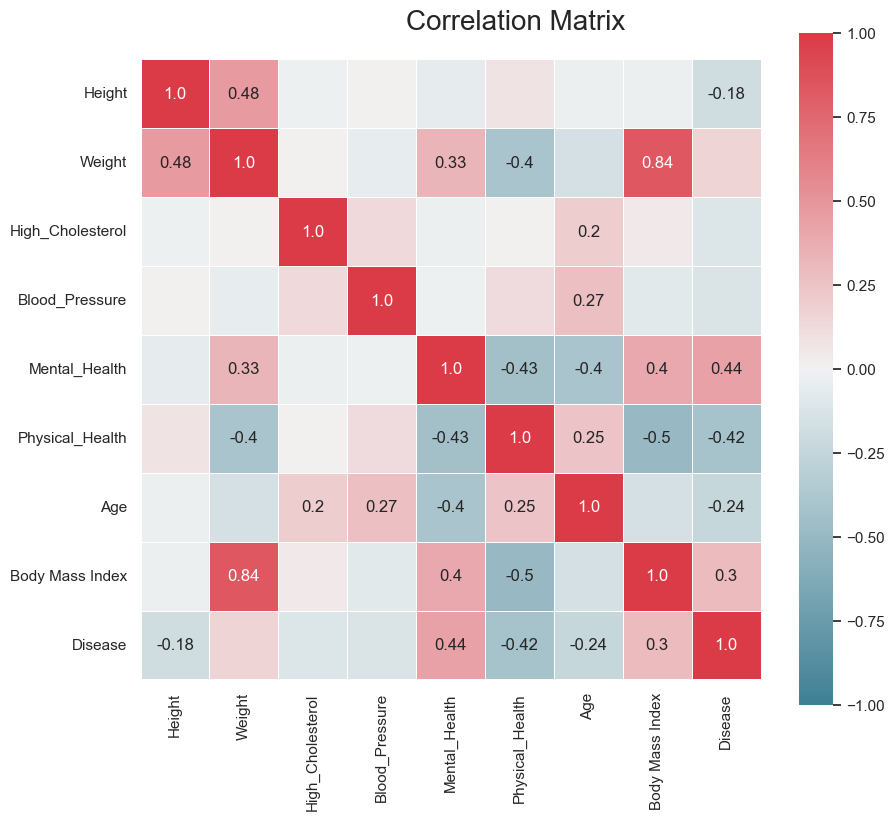

In [97]:
# Checking the correlation matrix for these variables. We don't have
# that high of correlations besides between "Heigh" and "Weight", and between
# "Body Mass Index" and "Weight".
fig = plt.figure(figsize=(10,8))
corr = np.round(
    data_numerical_without_out.corr(method="spearman"), decimals=2
    )
mask_annot=np.absolute(corr.values)>=0.18
annot=np.where(mask_annot, corr.values, np.full(corr.shape,""))
sns.heatmap(data=corr,annot=annot,cmap=sns.diverging_palette(220,10,as_cmap=True), 
            fmt='s',vmin=-1,vmax=1,center=0,square=True,linewidths=.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix",fontsize=20)
plt.show()

In [98]:
# Dropping the target "Disease" from "data_numerical" as we no
# longer need it.
data_numerical.drop(['Disease'], axis=1, inplace=True)

## 3. Generating Datasets for Training Models

### 3.1. Training and Test Dataset with Basic Treatments

The following DataFrames are going to be used to create the "df_train_final":
- "data_numerical": feature engineering on numerical features;
- "data_categorical": feature engineering and grouping on categorical variables.

The following DataFrames are going to be used to create the "df_test_final":
- "test_numerical": feature engineering on numerical features;
- "test_categorical": feature engineering and grouping on categorical variables.

The following DataFrames are going to be used to create the "df_train_basic_treatments":
- "data_numerical": feature engineering on numerical features;
- "data_categorical_one_hot_encoded": feature engineering, grouping and one-hot encoding on categorical variables.

The following DataFrames are going to be used to create the "df_test_basic_treatments":
- "test_numerical": feature engineering on numerical features;
- "test_categorical_one_hot_encoded": feature engineering, grouping and one-hot encoding on categorical variables.

In [99]:
# The following DataFrame results of the merge of the "data_numerical"
# with the "data_categorical".
df_train_final = data_numerical.merge(data_categorical, how='outer', left_index=True, right_index=True).copy()
df_train_final.head()

Height  Weight  High_Cholesterol  Blood_Pressure  Mental_Health  \
PatientID                                                                    
1167          155      67               358             120             21   
1805          173      88               230             142              9   
1557          162      68               226             122             26   
1658          180      66               313             125             13   
1544          180      58               277             125             18   

           Physical_Health  Age  Body Mass Index                    Region  \
PatientID                                                                    
1167                     2   57            27.89                    London   
1805                     0   53            29.40                South West   
1557                     0   48            25.91  Yorkshire and the Humber   
1658                     8   64            20.37                    London   
1544                     2   54            17.90                South East   

                                             Education            Checkup  \
PatientID                                                                   
1167       High School Incomplete (10th to 11th grade)  More than 3 years   
1805       High School Incomplete (10th to 11th grade)           Not sure   
1557              Elementary School (1st to 9th grade)  More than 3 years   
1658             University Complete (3 or more years)           Not sure   
1544              University Incomplete (1 to 2 years)  More than 3 years   

                                                    Diabetes Smoking_Habit  \
PatientID                                                                    
1167        Neither I nor my immediate family have diabetes.            No   
1805        Neither I nor my immediate family have diabetes.            No   
1557        Neither I nor my immediate family have diabetes.            No   
1658       I have/had pregnancy diabetes or borderline di...            No   
1544       I have/had pregnancy diabetes or borderline di...            No   

                                Drinking_Habit Exercise  \
PatientID                                                 
1167       I usually consume alcohol every day      Yes   
1805        I consider myself a social drinker      Yes   
1557        I consider myself a social drinker       No   
1658       I usually consume alcohol every day      Yes   
1544        I consider myself a social drinker       No   

                                               Fruit_Habit  \
PatientID                                                    
1167       Less than 1. I do not consume fruits every day.   
1805       Less than 1. I do not consume fruits every day.   
1557       Less than 1. I do not consume fruits every day.   
1658       Less than 1. I do not consume fruits every day.   
1544                     1 to 2 pieces of fruit in average   

                                              Water_Habit Gender  \
PatientID                                                          
1167                     Between one liter and two liters  Women   
1805                     Between one liter and two liters    Men   
1557       More than half a liter but less than one liter    Men   
1658       More than half a liter but less than one liter    Men   
1544       More than half a liter but less than one liter    Men   

                     Region_Grouped  
PatientID                            
1167                         London  
1805                          South  
1557       Yorkshire and the Humber  
1658                         London  
1544                          South

In [100]:
# The following DataFrame results of the merge of the "test_numerical"
# with the "test_categorical".
df_test_final = test_numerical.merge(test_categorical, how='outer', left_index=True, right_index=True).copy()

In [101]:
# The following DataFrame results of the merge of the "data_numerical"
# with the "data_categorical_one_hot_encoded".
df_train_basic_treatments = data_numerical.merge(data_categorical_one_hot_encoded, how='outer', left_index=True, right_index=True).copy()
df_train_basic_treatments.head()

Height  Weight  High_Cholesterol  Blood_Pressure  Mental_Health  \
PatientID                                                                    
1167          155      67               358             120             21   
1805          173      88               230             142              9   
1557          162      68               226             122             26   
1658          180      66               313             125             13   
1544          180      58               277             125             18   

           Physical_Health  Age  Body Mass Index  Region_East of England  \
PatientID                                                                  
1167                     2   57            27.89                     0.0   
1805                     0   53            29.40                     0.0   
1557                     0   48            25.91                     0.0   
1658                     8   64            20.37                     0.0   
1544                     2   54            17.90                     0.0   

           Region_London  ...  \
PatientID                 ...   
1167                 1.0  ...   
1805                 0.0  ...   
1557                 0.0  ...   
1658                 1.0  ...   
1544                 0.0  ...   

           Fruit_Habit_Less than 1. I do not consume fruits every day.  \
PatientID                                                                
1167                                                     1.0             
1805                                                     1.0             
1557                                                     1.0             
1658                                                     1.0             
1544                                                     0.0             

           Fruit_Habit_More than six pieces of fruit  \
PatientID                                              
1167                                             0.0   
1805                                             0.0   
1557                                             0.0   
1658                                             0.0   
1544                                             0.0   

           Water_Habit_Less than half a liter  \
PatientID                                       
1167                                      0.0   
1805                                      0.0   
1557                                      0.0   
1658                                      0.0   
1544                                      0.0   

           Water_Habit_More than half a liter but less than one liter  \
PatientID                                                               
1167                                                     0.0            
1805                                                     0.0            
1557                                                     1.0            
1658                                                     1.0            
1544                                                     1.0            

           Gender_Women  Region_Grouped_London  Region_Grouped_North  \
PatientID                                                              
1167                1.0                    1.0                   0.0   
1805                0.0                    0.0                   0.0   
1557                0.0                    0.0                   0.0   
1658                0.0                    1.0                   0.0   
1544                0.0                    0.0                   0.0   

           Region_Grouped_South  Region_Grouped_West  \
PatientID                                              
1167                        0.0                  0.0   
1805                        1.0                  0.0   
1557                        0.0                  0.0   
1658                        0.0                  0.0   
1544                        1.0                  0.0   

           Region_Grouped_Yorkshi

In [102]:
# The following DataFrame results of the merge of the "test_numerical"
# with the "test_categorical_one_hot_encoded".
df_test_basic_treatments = test_numerical.merge(test_categorical_one_hot_encoded, how='outer', left_index=True, right_index=True).copy()

### 3.2. Feature Selection

#### 3.2.1. Filter Methods for Categorical and Numerical Features

- Chi squared test will be the filter method that we are going to use to find out the most important predictors among the categorical features;
- Correlation matrix analysis will be the filter method we are going to use to find out the most important predictors among the numerical features;

In [103]:
# Creating a variable for our target variable.
target_var=data_set["Disease"]

In [104]:
# Creating the function "TestIndependence" that by applying the chi-squared test
# will check if an independent categorical feature is an important predictor
# taking into consideration our target variable.
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved=pd.crosstab(y,X) 
    chi2,p,dof,expected=stats.chi2_contingency(dfObserved.values)
    dfExpected=pd.DataFrame(expected,columns=dfObserved.columns,index=dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor.".format(var)
    print(result)

In [105]:
# Creating a for loop to apply the function to every independent categorical feature.
# Following this test we verify that the following features are important predictor:
# "Checkup", "Diabetes", "Drinking_Habit", "Exercise", "Fruit_Habit" and "Gender".
for var in data_categorical:
    TestIndependence(data_categorical[var],target_var, var)

Region is NOT an important predictor.
Education is NOT an important predictor.
Checkup is IMPORTANT for Prediction
Diabetes is IMPORTANT for Prediction
Smoking_Habit is NOT an important predictor.
Drinking_Habit is IMPORTANT for Prediction
Exercise is IMPORTANT for Prediction
Fruit_Habit is IMPORTANT for Prediction
Water_Habit is NOT an important predictor.
Gender is IMPORTANT for Prediction
Region_Grouped is NOT an important predictor.


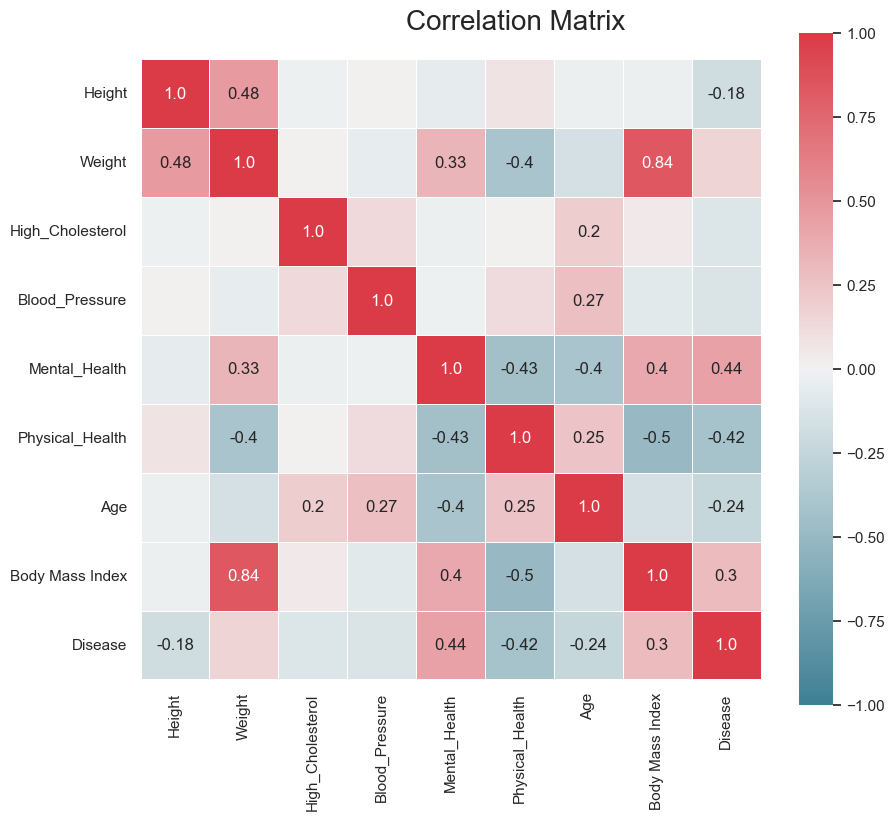

In [106]:
# Checking the correlation matrix for the numerical features without outliers. We want to keep
# numerical variables that are highly correlated with the target, and we want
# to drop independent variables that are highly correlated between each other.
# Through analysis of the correlation matrix, we would want to keep "Mental_Health",
# "Physical_Health", "Body Mass Index" and "Age".
fig = plt.figure(figsize=(10,8))
corr = np.round(
    data_numerical_without_out.corr(method="spearman"), decimals=2
    )
mask_annot=np.absolute(corr.values)>=0.18
annot=np.where(mask_annot, corr.values, np.full(corr.shape,""))
sns.heatmap(data=corr,annot=annot,cmap=sns.diverging_palette(220,10,as_cmap=True), 
            fmt='s',vmin=-1,vmax=1,center=0,square=True,linewidths=.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix",fontsize=20)
plt.show()

In [107]:
# Following the feature selection provided by the filter methods, our
# training and test data set will be the following:
df_train_final_filter=df_train_final[["Age","Mental_Health","Physical_Health","Body Mass Index",
                                                "Checkup","Diabetes","Drinking_Habit","Exercise", "Fruit_Habit",
                                                "Gender"]]
df_test_final_filter=df_test_final[["Age","Mental_Health","Physical_Health","Body Mass Index",
                                                "Checkup","Diabetes","Drinking_Habit","Exercise", "Fruit_Habit",
                                                "Gender"]]
# We won't be performing any one-hot enconding as it depends on how the data is
# split between the training set and validation set. Also, outliers were kept as
# we can only apply the function we created after we separate the training and
# validation set.
df_train_final_filter.head()

Age  Mental_Health  Physical_Health  Body Mass Index  \
PatientID                                                         
1167        57             21                2            27.89   
1805        53              9                0            29.40   
1557        48             26                0            25.91   
1658        64             13                8            20.37   
1544        54             18                2            17.90   

                     Checkup  \
PatientID                      
1167       More than 3 years   
1805                Not sure   
1557       More than 3 years   
1658                Not sure   
1544       More than 3 years   

                                                    Diabetes  \
PatientID                                                      
1167        Neither I nor my immediate family have diabetes.   
1805        Neither I nor my immediate family have diabetes.   
1557        Neither I nor my immediate family have diabetes.   
1658       I have/had pregnancy diabetes or borderline di...   
1544       I have/had pregnancy diabetes or borderline di...   

                                Drinking_Habit Exercise  \
PatientID                                                 
1167       I usually consume alcohol every day      Yes   
1805        I consider myself a social drinker      Yes   
1557        I consider myself a social drinker       No   
1658       I usually consume alcohol every day      Yes   
1544        I consider myself a social drinker       No   

                                               Fruit_Habit Gender  
PatientID                                                          
1167       Less than 1. I do not consume fruits every day.  Women  
1805       Less than 1. I do not consume fruits every day.    Men  
1557       Less than 1. I do not consume fruits every day.    Men  
1658       Less than 1. I do not consume fruits every day.    Men  
1544                     1 to 2 pieces of fruit in average    Men

#### 3.2.2. Wrapper Methods for Numerical Features

##### 3.2.2.1. Method 1 - For-Loop with Recursive Feature Elimination

In [108]:
# Understanding how many and which features to use in a more complex way.
# Running the recursive feature elimination several times and see which is the
# number of features it selects the most times. As it is, every time we run the
# recursive feature elimination, it is picking a different number of features.

highest_scores=[]
number_of_features=[]

for i in range(20):
    # Applying train_test_split to prepare the training set and validation set
    # that we are going to use on the recursive feature elimination. We are
    # using "data_numerical", as at this point we still want to include the outliers.
    # Only after splitting we are going to take the outliers out of the training set.
    X_train,X_val,y_train,y_val=train_test_split(data_numerical,target_var,test_size=0.15,stratify=target_var,shuffle=True)

    # Eliminating the observations with the outliers from the "X_train" and respective
    # target in "y_train".
    X_train=outlier_removal(X_train,numerical_features)
    y_train=y_train.loc[X_train.index]

    # Scaling the training data using "MinMaxScaler" as it works better with the model
    # that we are going to use during the recursive feature elimination.    
    minmax_scaler=MinMaxScaler().fit(X_train)
    X_train_scaled=minmax_scaler.transform(X_train)
    X_train_scaled=pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    
    # Also, scaling the validation data with the fitted values of the training set.
    X_val_scaled=minmax_scaler.transform(X_val)
    X_val_scaled=pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

    # Using the Logistic Regression to perform the
    # recursive feature elimination.
    model=LogisticRegression()

    # As we don't know the number of features to select we are going
    # to create a loop to maximize the f1 score of the estimator according
    # to the number of features.
    nof_list=list(range(1,len(X_train_scaled)))
    high_score=0
    nof=0
    score_list=[]

    for n in nof_list:
        # When we perform the recursive feature elimination removing the outliers
        # we get that the best number of features is 5.
        rfe=RFE(model,n_features_to_select=n)
        X_train_rfe=rfe.fit_transform(X_train_scaled,y_train)
        X_val_rfe=rfe.transform(X_val_scaled)
        model.fit(X_train_rfe,y_train)
        y_val_pred=model.predict(X_val_rfe)
        score=f1_score(y_val_pred,y_val)
        score_list.append(score)
        if (score>high_score):
            high_score=score
            nof=nof_list[n]
    
    highest_scores.append(high_score)
    number_of_features.append(nof)

In [109]:
# Printing the best number of features.

number_of_features_dict={key: number_of_features.count(key) for key in set(number_of_features)}
key_list=list(number_of_features_dict.keys())
val_list=list(number_of_features_dict.values())
position=val_list.index(max(number_of_features_dict.values()))
print(f"Out of 20 iterations, {key_list[position]} was the number of features that was selected the most, \
with {max(number_of_features_dict.values())} selections.")

Out of 20 iterations, 5 was the number of features that was selected the most, with 6 selections.


In [110]:
# Checking which features are the best out of the number we found out in
# the previous code.

rfe=RFE(estimator=model,n_features_to_select=5)
X_rfe=rfe.fit_transform(X=X_train_scaled,y=y_train)
selected_features = pd.Series(rfe.support_,index = X_train_scaled.columns)
selected_features

Height               True
Weight              False
High_Cholesterol     True
Blood_Pressure       True
Mental_Health        True
Physical_Health      True
Age                 False
Body Mass Index     False
dtype: bool

##### 3.2.2.2. Method 2 - Applying RFECV Function - Recursive Feature Elimination Cross Validation

In [111]:
# Applying Recursife Feature Elimination with cross validation.
# The following line of code will give the best number of features
# when a StratifiedKFold with 10 splits is applied.

X_train=df_train_final[numerical_features].copy()
y_train=data_set["Disease"].copy()
X_train=outlier_removal(X_train,numerical_features)
y_train=y_train.loc[X_train.index]
minmax_scaler=MinMaxScaler().fit(X_train)
X_train_scaled=minmax_scaler.transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)

rfecv=RFECV(estimator=LogisticRegression(),step=1,cv=StratifiedKFold(n_splits=10,random_state=1,shuffle=True),scoring="f1",min_features_to_select=1)
rfecv.fit(X_train_scaled,y_train)
print(f"The best number of features for the Logistic Regresson is {rfecv.n_features_}.")

The best number of features for the Logistic Regresson is 5.


In [112]:
# Checking which are the features that the code created above selected.
# As we can see the variables selected were the same as the method applied in 
# the previous section 3.2.2.1
print(dict(zip(list(df_train_final[numerical_features].columns),list(rfecv.support_))))

{'Height': True, 'Weight': False, 'High_Cholesterol': True, 'Blood_Pressure': True, 'Mental_Health': True, 'Physical_Health': True, 'Age': False, 'Body Mass Index': False}


In [113]:
# The scores that we got for each number of features being tested.

for i in range(8):
    print(f"The average f1-score for {i+1} features is {round(np.mean(rfecv.grid_scores_[i]),4)}")

The average f1-score for 1 features is 0.7353
The average f1-score for 2 features is 0.7528
The average f1-score for 3 features is 0.7568
The average f1-score for 4 features is 0.7725
The average f1-score for 5 features is 0.7732
The average f1-score for 6 features is 0.7667
The average f1-score for 7 features is 0.7619
The average f1-score for 8 features is 0.7634


/usr/local/anaconda3/envs/master_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


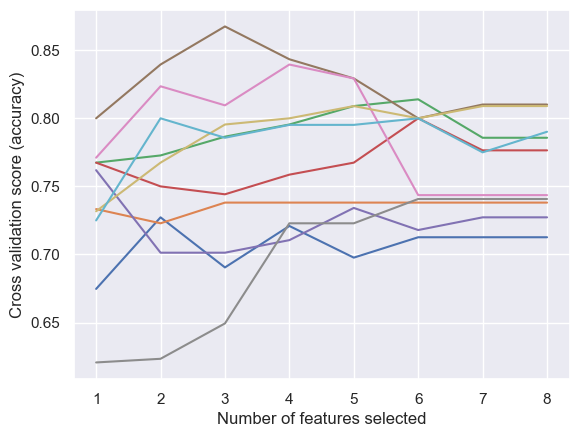

In [114]:
# A plot showing the different scores obtained for the different number of
# features included in each cross validation.

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_,)
plt.show()

##### 3.2.2.3. Creating dataset using wrapper and filter methods

In [115]:
# Taking into consideration the categorical features that we got from the
# filter methods, we will have the following DataFrame:
df_train_final_wrapper=df_train_final[["Mental_Health","Physical_Health","Height","High_Cholesterol", "Blood_Pressure",
                                                "Checkup","Diabetes","Drinking_Habit","Exercise", "Fruit_Habit",
                                                "Gender"]]
df_test_final_wrapper=df_test_final[["Mental_Health","Physical_Health","Height","High_Cholesterol", "Blood_Pressure",
                                                "Checkup","Diabetes","Drinking_Habit","Exercise", "Fruit_Habit",
                                                "Gender"]]
# We won't be performing any one-hot enconding as it depends on how the data is
# split between the training set and validation set. Also, outliers were kept as
# we can only apply the function we created after we separate the training and
# validation set.
df_train_final_wrapper.head()

Mental_Health  Physical_Health  Height  High_Cholesterol  \
PatientID                                                             
1167                  21                2     155               358   
1805                   9                0     173               230   
1557                  26                0     162               226   
1658                  13                8     180               313   
1544                  18                2     180               277   

           Blood_Pressure            Checkup  \
PatientID                                      
1167                  120  More than 3 years   
1805                  142           Not sure   
1557                  122  More than 3 years   
1658                  125           Not sure   
1544                  125  More than 3 years   

                                                    Diabetes  \
PatientID                                                      
1167        Neither I nor my immediate family have diabetes.   
1805        Neither I nor my immediate family have diabetes.   
1557        Neither I nor my immediate family have diabetes.   
1658       I have/had pregnancy diabetes or borderline di...   
1544       I have/had pregnancy diabetes or borderline di...   

                                Drinking_Habit Exercise  \
PatientID                                                 
1167       I usually consume alcohol every day      Yes   
1805        I consider myself a social drinker      Yes   
1557        I consider myself a social drinker       No   
1658       I usually consume alcohol every day      Yes   
1544        I consider myself a social drinker       No   

                                               Fruit_Habit Gender  
PatientID                                                          
1167       Less than 1. I do not consume fruits every day.  Women  
1805       Less than 1. I do not consume fruits every day.    Men  
1557       Less than 1. I do not consume fruits every day.    Men  
1658       Less than 1. I do not consume fruits every day.    Men  
1544                     1 to 2 pieces of fruit in average    Men

#### 3.2.3. Embedded Methods for Numerical Features

In [116]:
# We will apply Lasso Regression to see which coefficient have
# a bigger impact. For it we will be using the train test split,
# scaling and outlier removal we applied during the wrapper methods.
reg=LassoCV()
reg.fit(X_train_scaled,y_train)
coef1=pd.Series(reg.coef_,index=X_train_scaled.columns)

def plot_importance(coef,name):
    imp_coef=coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

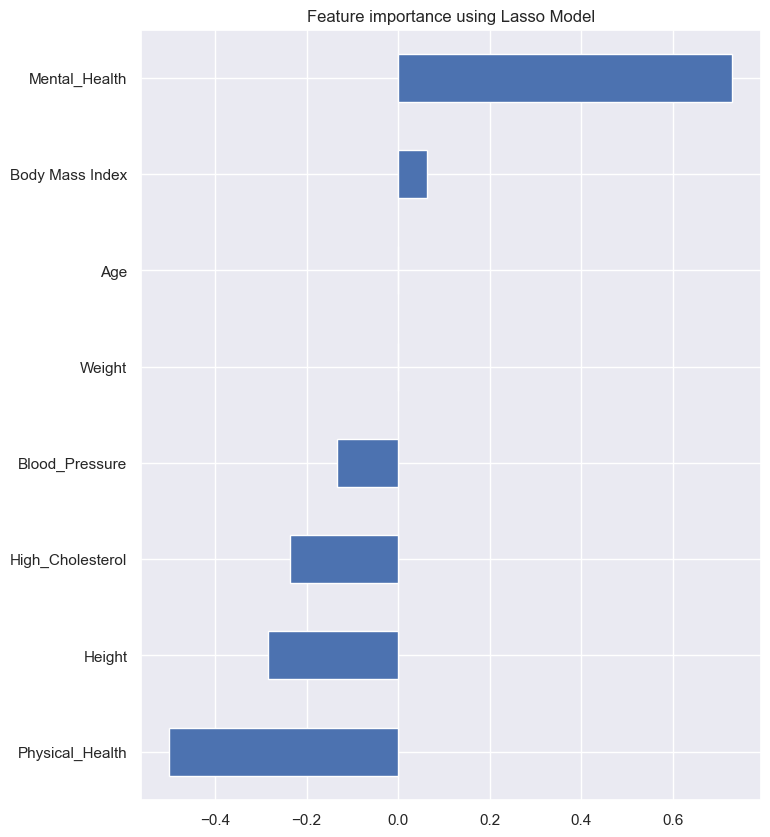

In [117]:
# Plotting to see the importance of each one of the features.
# By using Lasso we can see that the most important numerical features
# are "Mental_Health", "High_Cholesterol", "Height" and "Physical Health".
plot_importance(coef1,"Lasso")

In [118]:
# Taking into consideration the categorical features that we got from the
# filter methods, we will have the following DataFrame:
df_train_final_embedded=df_train_final[["Mental_Health","Physical_Health","Height","High_Cholesterol",
                                                "Checkup","Diabetes","Drinking_Habit","Exercise", "Fruit_Habit",
                                                "Gender"]]
df_test_final_embedded=df_test_final[["Mental_Health","Physical_Health","Height","High_Cholesterol",
                                                "Checkup","Diabetes","Drinking_Habit","Exercise", "Fruit_Habit",
                                                "Gender"]]

# Exactly the same conclusions from the Wrapper method.
# We won't be performing any one-hot enconding as it depends on how the data is
# split between the training set and validation set. Also, outliers were kept as
# we can only apply the function we created after we separate the training and
# validation set.
df_train_final_embedded.head()

Mental_Health  Physical_Health  Height  High_Cholesterol  \
PatientID                                                             
1167                  21                2     155               358   
1805                   9                0     173               230   
1557                  26                0     162               226   
1658                  13                8     180               313   
1544                  18                2     180               277   

                     Checkup  \
PatientID                      
1167       More than 3 years   
1805                Not sure   
1557       More than 3 years   
1658                Not sure   
1544       More than 3 years   

                                                    Diabetes  \
PatientID                                                      
1167        Neither I nor my immediate family have diabetes.   
1805        Neither I nor my immediate family have diabetes.   
1557        Neither I nor my immediate family have diabetes.   
1658       I have/had pregnancy diabetes or borderline di...   
1544       I have/had pregnancy diabetes or borderline di...   

                                Drinking_Habit Exercise  \
PatientID                                                 
1167       I usually consume alcohol every day      Yes   
1805        I consider myself a social drinker      Yes   
1557        I consider myself a social drinker       No   
1658       I usually consume alcohol every day      Yes   
1544        I consider myself a social drinker       No   

                                               Fruit_Habit Gender  
PatientID                                                          
1167       Less than 1. I do not consume fruits every day.  Women  
1805       Less than 1. I do not consume fruits every day.    Men  
1557       Less than 1. I do not consume fruits every day.    Men  
1658       Less than 1. I do not consume fruits every day.    Men  
1544                     1 to 2 pieces of fruit in average    Men

## 4. Final DataFrames

- "df_train_final": Train dataset with all the numerical features (feature engineering) and categorical features (feature engineering and grouping);
- "df_test_final": Test dataset with all the numerical features (feature engineering) and categorical features (feature engineering and grouping);
- "df_train_basic_treatments": Train dataset with all the numerical features (feature engineering) and categorical features (feature engineering, grouping, and one hot encoding);
- "df_test_basic_treatmenrs": Test dataset with all the numerical features (feature engineering) and categorical features (feature engineering, grouping, and one hot encoding);
- "df_train_final_filter": Based on "df_train_final" but feature selection was made according to the filter method. No hot encoding or outlier removal was performed in this dataset, as we can only do it after splitting the dataset into training and validation.
- "df_test_final_filter": Based on "df_test_final" but feature selection was made according to the filter method.
- "df_train_final_wrapper": Based on "df_train_final" but feature selection was made according to the wrapper method. No hot encoding or outlier removal was performed in this dataset, as we can only do it after splitting the dataset into training and validation.
- "df_test_final_wrapper": Based on "df_test_final" but feature selection was made according to the wrapper method.
- "df_train_final_embedded": Based on "df_train_final" but feature selection was made according to the embedded method. No hot encoding or outlier removal was performed in this dataset, as we can only do it after splitting the dataset into training and validation.
- "df_test_final_embedded": Based on "df_test_final" but feature selection was made according to the embedded method.


## 5. Modelling

### 5.0. Auxiliar Functions

In [119]:
import warnings
warnings.filterwarnings('ignore')

In [120]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    """
    This function calculates the average f1-score for a model using cross validation.
    Parameters
    ----------
    model : sklearn model
        The model that we want to use to calculate the average f1-score.
    scaler : sklearn scaler
        The scaler that we want to use to scale the data.
    remove_outlier : bool
        True if we want to remove the outliers from the data.
    have_one_hot_encoder : bool
        True if we want to apply one hot encoder on the categorical variables.
    X : pandas DataFrame
        The DataFrame that we want to use to train the model.
    y : pandas Series
        The Series that we want to use to train the model.
    Returns
    -------
    score_train : float
        The average f1-score for the training set.
    score_test : float
        The average f1-score for the test set.
    n_iter : int
        The number of iterations that the model took to converge.
    """

    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        n_iter.append(model.n_iter_)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    avg_iter = round(np.mean(n_iter),1)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    std_iter = round(np.std(n_iter),1)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score Validation': (str(avg_test)+'+/-'+str(std_test)),
        'Iterations': (str(avg_iter)+'+/-'+str(std_iter))
        }

def evaluate_in_different_data(model, hyperparameters_score, X, y):
    """
    This function evaluates the model in different data, using different scalers and removing outliers or not.
    The function returns a dataframe with the results of the evaluation.
    """
    evaluation = pd.DataFrame(columns = ['Scaler', 'Outlier', 'F1 Train', 'F1 Validation', 'Iterations'])
    count = 0

    for index_scaler, scaler in enumerate(hyperparameters_score['scaler']):
        for index_outlier, outlier in enumerate(hyperparameters_score['remove_outlier']):
            results = calculate_f1_score_average(model, scaler, outlier, True, X, y)
            results_format = {
                'Scaler': hyperparameters_score['scaler_label'][index_scaler],
                'Outlier': hyperparameters_score['remove_outlier_label'][index_outlier],
                'F1 Train': results['F1 Score Train'],
                'F1 Validation': results['F1 Score Validation'],
                'Iterations': results['Iterations']
            }
            # print(results_format)
            evaluation = evaluation.append(results_format, ignore_index=True)
            count += 1
    return evaluation

### 5.1. Logistic Regression

In [121]:
# Setting a simple linear regression model to be evaluated in differents datasets.
model = LogisticRegression()

#### 5.1.1 Evaluation on which dataset the model need to be applied

##### 5.1.1.1 Evaluation with Full Dataset

In [122]:
## Testing the full dataset with different combinations of scalers and remotion of outliers
X = df_train_final.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

full_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
full_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.869+/-0.01  0.852+/-0.03   
1                None  Outlier Not Removed  0.865+/-0.01  0.848+/-0.05   
2  MinMaxScaler(-1,1)      Outlier Removed  0.889+/-0.01  0.846+/-0.04   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.883+/-0.0  0.858+/-0.04   
4   MinMaxScaler(0,1)      Outlier Removed  0.886+/-0.01  0.847+/-0.04   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.877+/-0.0  0.857+/-0.03   
6      StandardScaler      Outlier Removed   0.89+/-0.01  0.849+/-0.04   
7      StandardScaler  Outlier Not Removed   0.886+/-0.0  0.856+/-0.03   
8        RobustScaler      Outlier Removed   0.89+/-0.01  0.849+/-0.04   
9        RobustScaler  Outlier Not Removed   0.885+/-0.0  0.856+/-0.03   

    Iterations  
0  100.0+/-0.0  
1  100.0+/-0.0  
2   36.6+/-1.5  
3   44.4+/-1.0  
4   36.7+/-2.3  
5   45.8+/-2.9  
6   49.9+/-2.0  
7   51.3+/-1.3  
8   38.9+/-1.8  
9   45.5+/-3.2

##### 5.1.1.2 Evaluation with Filtered Dataset

In [123]:
## Testing the filtered dataset with different combinations of scalers and remotion of outliers
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

filter_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
filter_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.872+/-0.01  0.861+/-0.04   
1                None  Outlier Not Removed  0.872+/-0.01  0.865+/-0.04   
2  MinMaxScaler(-1,1)      Outlier Removed   0.875+/-0.0  0.866+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.871+/-0.01  0.857+/-0.05   
4   MinMaxScaler(0,1)      Outlier Removed   0.874+/-0.0  0.862+/-0.04   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.871+/-0.0   0.86+/-0.04   
6      StandardScaler      Outlier Removed  0.875+/-0.01  0.863+/-0.03   
7      StandardScaler  Outlier Not Removed   0.871+/-0.0   0.86+/-0.05   
8        RobustScaler      Outlier Removed  0.875+/-0.01  0.866+/-0.03   
9        RobustScaler  Outlier Not Removed   0.871+/-0.0   0.86+/-0.05   

    Iterations  
0  100.0+/-0.0  
1  100.0+/-0.0  
2   24.2+/-2.4  
3   32.3+/-1.6  
4   26.8+/-2.0  
5   35.0+/-1.0  
6   34.8+/-1.7  
7   33.3+/-2.2  
8   27.6+/-1.6  
9   30.9+/-2.0

##### 5.1.1.3 Evaluation with Wrapped Dataset

In [124]:
## Testing the wrapped dataset with different combinations of scalers and remotion of outliers
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

wrapper_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
wrapper_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.875+/-0.01  0.859+/-0.03   
1                None  Outlier Not Removed   0.876+/-0.0   0.87+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed   0.882+/-0.0  0.863+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.879+/-0.0  0.873+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed   0.882+/-0.0  0.865+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.881+/-0.0  0.872+/-0.03   
6      StandardScaler      Outlier Removed   0.883+/-0.0  0.867+/-0.03   
7      StandardScaler  Outlier Not Removed   0.881+/-0.0   0.87+/-0.03   
8        RobustScaler      Outlier Removed   0.883+/-0.0  0.864+/-0.03   
9        RobustScaler  Outlier Not Removed   0.881+/-0.0  0.869+/-0.03   

    Iterations  
0  100.0+/-0.0  
1  100.0+/-0.0  
2   27.1+/-2.3  
3   33.3+/-1.8  
4   32.8+/-1.7  
5   35.3+/-1.8  
6   35.7+/-1.8  
7   36.0+/-1.9  
8   29.5+/-1.6  
9   32.7+/-1.6

##### 5.1.1.4 Evaluation with Embedded Dataset

In [125]:
## Testing the embedded dataset with different combinations of scalers and remotion of outliers
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

embedded_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
embedded_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.866+/-0.01  0.844+/-0.04   
1                None  Outlier Not Removed    0.87+/-0.0  0.862+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed   0.874+/-0.0   0.86+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.877+/-0.0  0.869+/-0.04   
4   MinMaxScaler(0,1)      Outlier Removed   0.875+/-0.0  0.859+/-0.04   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.875+/-0.0  0.869+/-0.03   
6      StandardScaler      Outlier Removed   0.874+/-0.0  0.854+/-0.03   
7      StandardScaler  Outlier Not Removed   0.875+/-0.0  0.867+/-0.04   
8        RobustScaler      Outlier Removed   0.875+/-0.0  0.857+/-0.03   
9        RobustScaler  Outlier Not Removed   0.875+/-0.0  0.868+/-0.04   

    Iterations  
0  100.0+/-0.0  
1  100.0+/-0.0  
2   25.4+/-1.6  
3   32.9+/-1.2  
4   33.1+/-1.9  
5   35.5+/-2.0  
6   32.8+/-3.3  
7   32.9+/-2.6  
8   28.3+/-2.1  
9   29.2+/-2.2

##### 5.1.1.5. Choosing the Best Dataset and Treatments for LogisticRegression

In this part we can notice 

The best configuration for the dataset (F1 score Validation = 0.873): 

- Scaler: MinMaxScaler(-1,1)
- Remotion Outlier: No
- Type Dataset: Applied Wrapped Methods

The second best dataset (F1 score Validation = 0.872): 

- Scaler: MinMaxScaler(0,1)
- Remotion Outlier: No
- Type Dataset: Applied Wrapper Methods

In [126]:
# Joining them all together, and sorting by the highest F1 Validation.
full_dataset['type'] = 'full_dataset'
filter_dataset['type'] = 'filter_dataset'
wrapper_dataset['type'] = 'wrapper_dataset'
embedded_dataset['type'] = 'embedded_dataset'

evaluation = pd.concat([full_dataset, filter_dataset, wrapper_dataset, embedded_dataset]).sort_values(by=['F1 Validation'], ascending=False)
evaluation

Scaler              Outlier      F1 Train F1 Validation  \
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.879+/-0.0  0.873+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.881+/-0.0  0.872+/-0.03   
1                None  Outlier Not Removed   0.876+/-0.0   0.87+/-0.03   
7      StandardScaler  Outlier Not Removed   0.881+/-0.0   0.87+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.877+/-0.0  0.869+/-0.04   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.875+/-0.0  0.869+/-0.03   
9        RobustScaler  Outlier Not Removed   0.881+/-0.0  0.869+/-0.03   
9        RobustScaler  Outlier Not Removed   0.875+/-0.0  0.868+/-0.04   
7      StandardScaler  Outlier Not Removed   0.875+/-0.0  0.867+/-0.04   
6      StandardScaler      Outlier Removed   0.883+/-0.0  0.867+/-0.03   
8        RobustScaler      Outlier Removed  0.875+/-0.01  0.866+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed   0.875+/-0.0  0.866+/-0.03   
1                None  Outlier Not Removed  0.872+/-0.01  0.865+/-0.04   
4   MinMaxScaler(0,1)      Outlier Removed   0.882+/-0.0  0.865+/-0.03   
8        RobustScaler      Outlier Removed   0.883+/-0.0  0.864+/-0.03   
6      StandardScaler      Outlier Removed  0.875+/-0.01  0.863+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed   0.882+/-0.0  0.863+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed   0.874+/-0.0  0.862+/-0.04   
1                None  Outlier Not Removed    0.87+/-0.0  0.862+/-0.03   
0                None      Outlier Removed  0.872+/-0.01  0.861+/-0.04   
7      StandardScaler  Outlier Not Removed   0.871+/-0.0   0.86+/-0.05   
9        RobustScaler  Outlier Not Removed   0.871+/-0.0   0.86+/-0.05   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.871+/-0.0   0.86+/-0.04   
2  MinMaxScaler(-1,1)      Outlier Removed   0.874+/-0.0   0.86+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed   0.875+/-0.0  0.859+/-0.04   
0                None      Outlier Removed  0.875+/-0.01  0.859+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.883+/-0.0  0.858+/-0.04   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.871+/-0.01  0.857+/-0.05   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.877+/-0.0  0.857+/-0.03   
8        RobustScaler      Outlier Removed   0.875+/-0.0  0.857+/-0.03   
9        RobustScaler  Outlier Not Removed   0.885+/-0.0  0.856+/-0.03   
7      StandardScaler  Outlier Not Removed   0.886+/-0.0  0.856+/-0.03   
6      StandardScaler      Outlier Removed   0.874+/-0.0  0.854+/-0.03   
0                None      Outlier Removed  0.869+/-0.01  0.852+/-0.03   
8        RobustScaler      Outlier Removed   0.89+/-0.01  0.849+/-0.04   
6      StandardScaler      Outlier Removed   0.89+/-0.01  0.849+/-0.04   
1                None  Outlier Not Removed  0.865+/-0.01  0.848+/-0.05   
4   MinMaxScaler(0,1)      Outlier Removed  0.886+/-0.01  0.847+/-0.04   
2  MinMaxScaler(-1,1)      Outlier Removed  0.889+/-0.01  0.846+/-0.04   
0                None      Outlier Removed  0.866+/-0.01  0.844+/-0.04   

    Iterations              type  
3   33.3+/-1.8   wrapper_dataset  
5   35.3+/-1.8   wrapper_dataset  
1  100.0+/-0.0   wrapper_dataset  
7   36.0+/-1.9   wrapper_dataset  
3   32.9+/-1.2  embedded_dataset  
5   35.5+/-2.0  embedded_dataset  
9   32.7+/-1.6   wrapper_dataset  
9   29.2+/-2.2  embedded_dataset  
7   32.9+/-2.6  embedded_dataset  
6   35.7+/-1.8   wrapper_dataset  
8   27.6+/-1.6    filter_dataset  
2   24.2+/-2.4    filter_dataset  
1  100.0+/-0.0    filter_dataset  
4   32.8+/-1.7   wrapper_dataset  
8   29.5+/-1.6   wrapper_dataset  
6   34.8+/-1.7    filter_dataset  
2   27.1+/-2.3   wrapper_dataset  
4   26.8+/-2.0    filter_dataset  
1  100.0+/-0.0  embedded_dataset  
0  100.0+/-0.0    filter_dataset  
7   33.3+/-2.2    filter_dataset  
9   30.9+/-2.0    filter_dataset  
5   35.0+/-1.0    filter_dataset  
2   25.4+/-1.6  embedded_dataset  
4   33.1+/-1.9  embedded_dataset  
0  100.0+/-0.0   wrapper_dataset  
3   44.4+/-1.0      full_dataset  


#### 5.1.2 Training the model and Generate the Output

##### 5.1.2.1 Training Model with Pipeline

The best configuration for the dataset (F1 score Validation = 0.873): 

- Scaler: MinMaxScaler(-1,1)
- Remotion Outlier: No
- Type Dataset: Applied Wrapped Methods

In [127]:
# Fitting our training data set to the model and predicting
# if the Patient from the test set have the disease or not.

# define the model to be user in the pipeline: Logistic Regression
model = LogisticRegression()

# use the filter dataset to fine tune the model
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

# selecting the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(feature_range=(-1,1)), numerical_features),
        ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
    ])

# create pipeline with preprocessor and model
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# fit the pipeline to the training data
logistic_regression_model = pipeline.fit(X, y)

##### 5.1.2.2 Predicting the test set

In [128]:
X = df_test_final_wrapper.copy()

predictions = logistic_regression_model.predict(X)
mlpclassifier_gridsearhoutput = pd.DataFrame({'Disease': predictions}, index=df_test_final_wrapper.index)
mlpclassifier_gridsearhoutput.to_csv('logistic_regression_output.csv')

### 5.2. Decision Tree

#### 5.2.0. Auxiliar Functions for Decision Tree

In [129]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    """"
    This function will calculate the average f1 score for a given model, scaler, and remotion of outliers.
    """
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score Validation': (str(avg_test)+'+/-'+str(std_test))
        }


def evaluate_in_different_data(model, hyperparameters_score, X, y):
    evaluation = pd.DataFrame(columns = ['Scaler', 'Outlier', 'F1 Train', 'F1 Validation'])
    count = 0

    for index_scaler, scaler in enumerate(hyperparameters_score['scaler']):
        for index_outlier, outlier in enumerate(hyperparameters_score['remove_outlier']):
            results = calculate_f1_score_average(model, scaler, outlier, True, X, y)
            results_format = {
                'Scaler': hyperparameters_score['scaler_label'][index_scaler],
                'Outlier': hyperparameters_score['remove_outlier_label'][index_outlier],
                'F1 Train': results['F1 Score Train'],
                'F1 Validation': results['F1 Score Validation']
            }
            # print(results_format)
            evaluation = evaluation.append(results_format, ignore_index=True)
            count += 1
    return evaluation

# Function to plot a Decision Tree
def plot_tree(model, columns):
    dot_data = export_graphviz(
        model,
        feature_names=columns,
        class_names=["No Disease", "Disease"],
        filled=True
        )
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"20,20"')
    return graphviz.Source(pydot_graph.to_string())

#### 5.2.1. Training First Models

##### 5.2.1.1. Setting Basic Configurations

- Dataset used: df_train_basic_treatments
- Remove Outlier: False
- OneHotEncoder: True
- Scaler: StandardScaler()

In [130]:
# Using df_train_basic_treatments,we split our variables X and target y for training and test
X = df_train_basic_treatments.copy()
y = data_set['Disease'].copy()

# Let's first study our results with outliers 
remove_outlier = False

# Since we are using our df_train_basic_treatments, we don't need one hot encoder
have_one_hot_encoder = False

# We don't need to scale our data for Decision Trees, so let's use the StandardScaler as default
scaler = StandardScaler()

##### 5.2.1.2. Training Model Baseline

##### 5.2.1.2.1. Decision Tree Based on Gini

In [131]:
# Creating model for DecisionTree based on Gini
dt_gini = DecisionTreeClassifier(random_state=42)
# Calculating the F1 score for our first Decision Tree
calculate_f1_score_average(dt_gini, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.946+/-0.02'}

##### 5.4.1.2.2. Decision Tree Based on Entropy

In [132]:
# Repeating the same analysis, but using Entropy
dt_entropy = DecisionTreeClassifier(random_state=42, criterion = 'entropy')
calculate_f1_score_average(dt_entropy, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.947+/-0.02'}

##### 5.2.1.2.3. Gini or Entropy?

From the results above, we see that Decision Tree is a method with a high Overfitting rate. Using Gini and Entropy does not change significatly our results.

##### 5.2.1.2.4. Analyzing the Tree

From the tree, we can check that the tree is too deep and has a lot of leaves. We can check different method to try to reduce the overfitting. See image below ! 

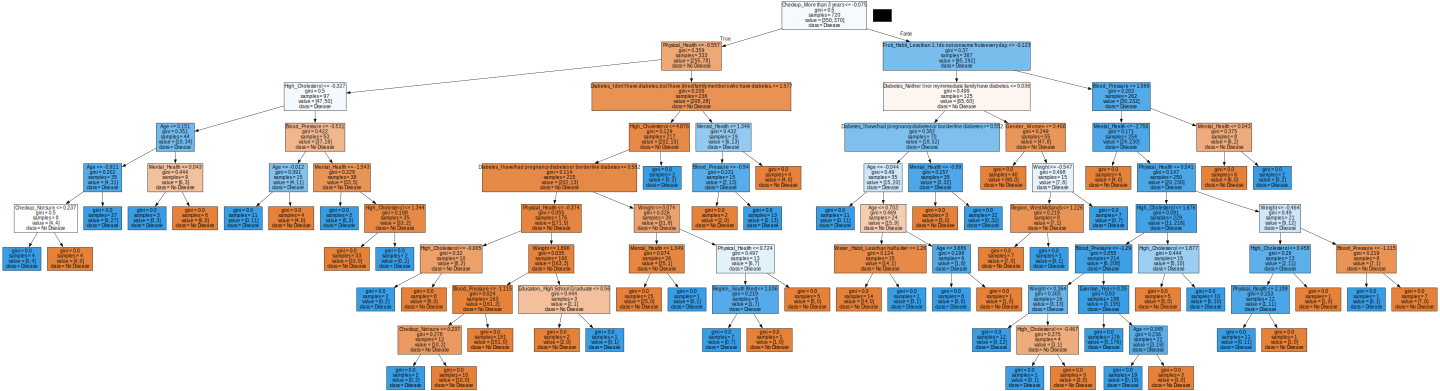

In [133]:
# Plotting the tree for our current Decision Tree
plot_tree(dt_gini, X.columns)

In [134]:
# Getting information from the tree above
print(
      'The defined three has a depth of',
      str(dt_gini.get_depth()),
      ',',
      str(dt_gini.tree_.node_count),
      'nodes and a total of',
      str(dt_gini.get_n_leaves()),
      'leaves.'
      )

The defined three has a depth of 9 , 105 nodes and a total of 53 leaves.


##### 5.2.1.3. Training with Improvements in dataset and parameters in DecisionTree

##### 5.2.1.3.1. Removing Outliers

Decision Tree is a method sensible to outliers. Removing them can improve our training.

But from our results in this section, outliers seems to be significant to our training model. 

So, we will keep them for future analysis.

In [135]:
# Let's change the variable remove_outlier to True and compare our results
remove_outlier = True
calculate_f1_score_average(dt_gini, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.742+/-0.06'}

In [136]:
remove_outlier = True
calculate_f1_score_average(dt_entropy, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.766+/-0.04'}

##### 5.2.1.3.2. Using Random Splitter

The random splitter will choose a random feature for each split on the tree. In the previous results, we have used the best splitter. Since the best tends to be biased on the training data, a random splitter can help to reduce overfitting the results.

But, as we can see in the below, in our training, the random splitter does not seem significant to improve our results.

In [137]:
# Using random splitter
dt_random = DecisionTreeClassifier(random_state=42, splitter = 'random')
calculate_f1_score_average(dt_random, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.72+/-0.11'}

##### 5.2.1.3.3. Changing the Max Depth for the tree

When making the splits in a decision tree, we will divide until each leaf has only one category. This result tends to be improved if we limit the ways of splitting. One of those methods is to limit the depth of the tree.

In [138]:
# For different depths of the tree
dt_depth2 = DecisionTreeClassifier(random_state=42,max_depth = 2)
dt_depth3 = DecisionTreeClassifier(random_state=42,max_depth = 3)
dt_depth4 = DecisionTreeClassifier(random_state=42,max_depth = 4)
dt_depth5 = DecisionTreeClassifier(random_state=42,max_depth = 5)
dt_depth6 = DecisionTreeClassifier(random_state=42,max_depth = 6)

result = calculate_f1_score_average(dt_depth2, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(f'for depth 2: {result}')

result = calculate_f1_score_average(dt_depth3, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(f'for depth 3: {result}')

result = calculate_f1_score_average(dt_depth4, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(f'for depth 4: {result}')

result = calculate_f1_score_average(dt_depth5, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(f'for depth 5: {result}')

result = calculate_f1_score_average(dt_depth6, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(f'for depth 6: {result}')

# From the results above, we can check that the deeper our tree, the best our results. 
# It also reduces some overfitting. 
# However, results are not that meaningful to be taken in charge. 
# For further study, let's check the tree of depth 2.

for depth 2: {'F1 Score Train': '0.904+/-0.02', 'F1 Score Validation': '0.728+/-0.08'}
for depth 3: {'F1 Score Train': '0.98+/-0.01', 'F1 Score Validation': '0.74+/-0.07'}
for depth 4: {'F1 Score Train': '0.997+/-0.01', 'F1 Score Validation': '0.741+/-0.06'}
for depth 5: {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.742+/-0.06'}
for depth 6: {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.742+/-0.06'}


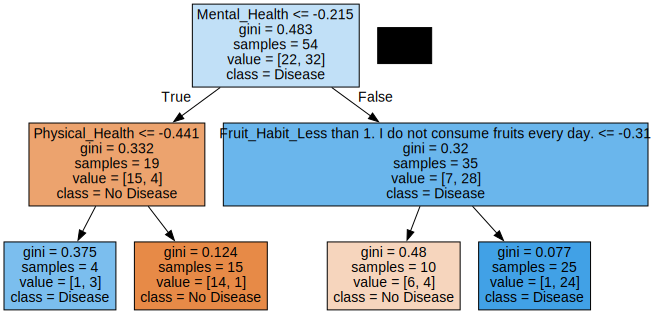

In [139]:
# For a rough explanation of our classification, this might be a good tree.
# We check 3 variables (2 of them categorical) and 
# we can explain our test set with average F1 score of 0.73+/-0.06. 
# It certainly is not the best result, but it is interesting to 
# take in charge for some context that we prioritize the explanation 
# of the phenomenon more than the result itself. 

plot_tree(dt_depth2, X.columns)

##### 5.2.1.3.4. Minimum Samples for Splits

When dividing the categories in the tree, we can demand a minimun number of samples in each split to get better results.

Conclusion: 
- When the requirement for a split is too large, our results tend to be worse. However, if the split is too small, it tends to get to the original result with high overfitting. Doesn't seem to be improving significantly our results changing the parameter.

In [140]:
# Changing the minimum samples for splits
dt_min200 = DecisionTreeClassifier(random_state=42,min_samples_split =200)

# Calculating the score
calculate_f1_score_average(dt_min200, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '0.658+/-0.22', 'F1 Score Validation': '0.611+/-0.2'}

In [141]:
# Changing the minimum samples for splits
dt_min20 = DecisionTreeClassifier(random_state=42,min_samples_split = 20)

# Calculating the score
calculate_f1_score_average(dt_min20, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '0.857+/-0.03', 'F1 Score Validation': '0.723+/-0.07'}

##### 5.2.1.3.5. Minimum Samples for Leaves

Similar to the last split, but now we analyze on the leaves instead of the split.

Conclusion: 
- When the requirement for a leaves is too large, our results tend to be worse. However, if the leaves is too small, it tends to get to the original result with high overfitting. Doesn't seem to be improving significantly our results changing the parameter.

In [142]:
# Changing the minimum samples for leaves
dt_min_leaf100 = DecisionTreeClassifier(random_state=42,min_samples_leaf=100)

# Calculating the score
calculate_f1_score_average(dt_min_leaf100, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '0.658+/-0.22', 'F1 Score Validation': '0.611+/-0.2'}

In [143]:
# Changing the minimum samples for leaves
dt_min_leaf10 = DecisionTreeClassifier(random_state=42,min_samples_leaf=10)

# Calculating the score
calculate_f1_score_average(dt_min_leaf10, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '0.835+/-0.02', 'F1 Score Validation': '0.732+/-0.05'}

##### 5.2.1.3.6. Maximum number of features

- It is computationally heavy to look at all the features every single time, so you can just check some of them using the various max_features options
- It also allows to minimize overfitting - by choosing a reduced number of features, we can increase the stability of the tree and reduce variance and overfitting

From the results below, our best results are taking in charge 40 features, but it is not much better than our baseline. Let's check some other models with Postpruning.

In [144]:
# Since we have 42 features, we can get all the results in a for
for i in range(42):
    dt_int = DecisionTreeClassifier(random_state=42,max_features = i+1)
    # Calculating the score
    print('Max Features: ', i+1, calculate_f1_score_average(dt_int, scaler, remove_outlier, have_one_hot_encoder, X, y))

Max Features:  1 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.749+/-0.05'}
Max Features:  2 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.731+/-0.04'}
Max Features:  3 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.734+/-0.06'}
Max Features:  4 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.728+/-0.06'}
Max Features:  5 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.737+/-0.08'}
Max Features:  6 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.708+/-0.04'}
Max Features:  7 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.723+/-0.06'}
Max Features:  8 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.753+/-0.04'}
Max Features:  9 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.743+/-0.04'}
Max Features:  10 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.748+/-0.04'}
Max Features:  11 {'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.698+/-0.1'}
Max Features:  12 {'F1 Score Tr

##### 5.2.1.4. Post-Prunning

The DecisionTreeClassifier class in sklearn provides ccp_alpha as a parameter for post pruning.

In [145]:
# Creating our DT model and getting alpha
dt_alpha = DecisionTreeClassifier(random_state=42)

# Let's make the train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Calculating different alphas and impurities
path = dt_alpha.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

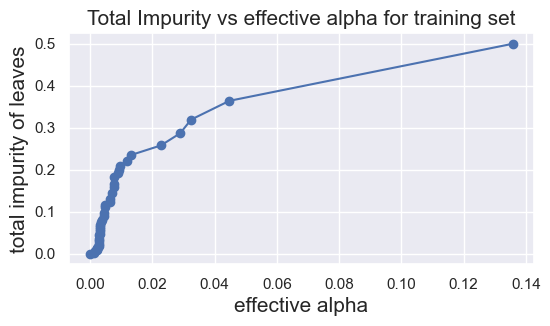

In [146]:
fig, ax = plt.subplots(figsize = (6,3))
ax.plot(ccp_alphas, impurities, marker='o')
ax.set_xlabel("effective alpha", fontsize=15)
ax.set_ylabel("total impurity of leaves", fontsize=15)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize=15)

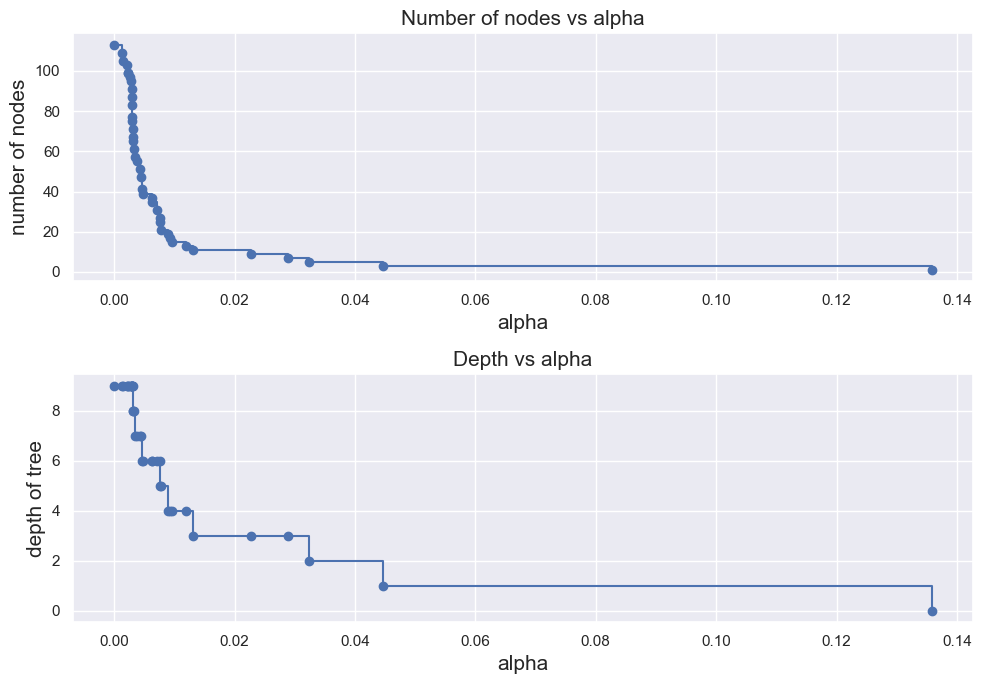

In [147]:
trees = []
for ccp_alpha in ccp_alphas:
    dt_alpha = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    trees.append(dt_alpha)

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.get_depth() for tree in trees]

fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha", fontsize=15)
ax[0].set_ylabel("number of nodes", fontsize=15)
ax[0].set_title("Number of nodes vs alpha", fontsize=15)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha", fontsize=15)
ax[1].set_ylabel("depth of tree", fontsize=15)
ax[1].set_title("Depth vs alpha", fontsize=15)
fig.tight_layout()

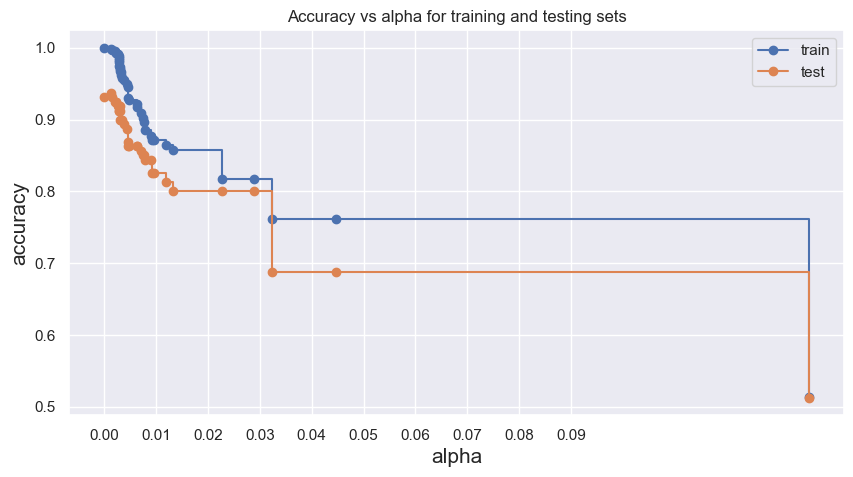

In [148]:
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

fig, ax = plt.subplots(figsize = (10,5))
ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("accuracy", fontsize=15)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
plt.xticks(np.arange(0,0.1,0.01))
ax.legend()
plt.show()

In [149]:
index_best_model = np.argmax(test_scores)
best_model = trees[index_best_model]
print('ccp_alpha of best model: ',trees[index_best_model])
print('_____________________________________________________________')
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

ccp_alpha of best model:  DecisionTreeClassifier(ccp_alpha=0.0013671875, random_state=42)
_____________________________________________________________
Training accuracy of best model:  0.9984375
Test accuracy of best model:  0.9375


#### 5.2.2. Second Alernative: Tuning Hyperparameters

As another strategy we'll try to approach in a different manner: 

1) Find the best dataset to be applied in DecisionTree classifier
2) Find the best parameters to be applied in the DecisionTree classifier using pipeline and GridSearchCV()


##### 5.2.2.1 Chossing the best dataset to DecisionTree model

##### 5.2.2.1.1 Evaluating in Full Dataset

In [150]:
## Testing the full dataset with different combinations of scalers and remotion of outliers
model = DecisionTreeClassifier(random_state=42)
X = df_train_final.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

full_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
full_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0  0.932+/-0.02
1                None  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.933+/-0.02
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.932+/-0.02
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.945+/-0.01
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.932+/-0.02
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.932+/-0.02
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02

##### 5.2.2.1.2 Evaluating in Filtered Dataset

In [151]:
## Testing the filtered dataset with different combinations of scalers and remotion of outliers
model = DecisionTreeClassifier(random_state=42)
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

filter_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
filter_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0  0.943+/-0.03
1                None  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.943+/-0.03
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.943+/-0.03
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.943+/-0.03
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.943+/-0.03
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03

##### 5.2.2.1.3 Evaluating in Wrapped Dataset

In [152]:
## Testing the wrapped dataset with different combinations of scalers and remotion of outliers
model = DecisionTreeClassifier(random_state=42)
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

wrapper_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
wrapper_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0  0.959+/-0.03
1                None  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.959+/-0.03
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0   0.96+/-0.03
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.959+/-0.03
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.959+/-0.03
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02

##### 5.2.2.1.4 Evaluating in Embedded Dataset

In [153]:
## Testing the embedded dataset with different combinations of scalers and remotion of outliers
model = DecisionTreeClassifier(random_state=42)
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

embedded_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
embedded_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0   0.96+/-0.02
1                None  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0   0.96+/-0.02
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0   0.96+/-0.02
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02
6      StandardScaler      Outlier Removed  1.0+/-0.0   0.96+/-0.02
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02
8        RobustScaler      Outlier Removed  1.0+/-0.0   0.96+/-0.02
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02

##### 5.2.2.1.5 Chossing the Best Dataset

In this part we can notice:

The change of the scalers in Decision Tree doesn't seem to affect the model performance.
But the outliers seems to have an impact ! 

The best configuration for the dataset (F1 score Validation = 0.974): 

- Scaler: anyone
- Remotion Outlier: No
- Type Dataset: Wrapper Dataset
- OneHotEncoded: Yes

The second best dataset (F1 score Validation = 0.964): 

- Scaler: anyone
- Remotion Outlier: No
- Type Dataset: Embedded Dataset
- OneHotEncoder: Yes

In [154]:
# Getting all them together, and sorting by the F1 Validation Score.

full_dataset['type'] = 'full_dataset'
filter_dataset['type'] = 'filter_dataset'
wrapper_dataset['type'] = 'wrapper_dataset'
embedded_dataset['type'] = 'embedded_dataset'

evaluation = pd.concat([full_dataset, filter_dataset, wrapper_dataset, embedded_dataset]).sort_values(by=['F1 Validation'], ascending=False)
evaluation

Scaler              Outlier   F1 Train F1 Validation  \
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02   
1                None  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02   
1                None  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.964+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0   0.96+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0   0.96+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0   0.96+/-0.02   
0                None      Outlier Removed  1.0+/-0.0   0.96+/-0.02   
6      StandardScaler      Outlier Removed  1.0+/-0.0   0.96+/-0.02   
8        RobustScaler      Outlier Removed  1.0+/-0.0   0.96+/-0.02   
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.959+/-0.03   
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.959+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.959+/-0.03   
0                None      Outlier Removed  1.0+/-0.0  0.959+/-0.03   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03   
1                None  Outlier Not Removed  1.0+/-0.0  0.946+/-0.03   
1                None  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.946+/-0.02   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.945+/-0.01   
0                None      Outlier Removed  1.0+/-0.0  0.943+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.943+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.943+/-0.03   
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.943+/-0.03   
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.943+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.933+/-0.02   
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.932+/-0.02   
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.932+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.932+/-0.02   
0                None      Outlier Removed  1.0+/-0.0  0.932+/-0.02   

               type  
3   wrapper_dataset  
5   wrapper_dataset  
7   wrapper_dataset  
9   wrapper_dataset  
1   wrapper_dataset  
9  embedded_dataset  
3  embedded_dataset  
1  embedded_dataset  
5  embedded_dataset  
7  embedded_dataset  
4   wrapper_dataset  
2  embedded_dataset  
4  embedded_dataset  
0  embedded_dataset  
6  embedded_dataset  
8  embedded_dataset  
8   wrapper_dataset  
6   wrapper_dataset  
2   wrapper_dataset  
0   wrapper_dataset  
9    filter_dataset  
7    filter_dataset  
5    filter_dataset  
3    filter_dataset  
1    filter_dataset  
1      full_dataset  
3      full_dataset  
7      full_dataset  
9      full_dataset  
5      full_dataset  
0    filter_dataset  
2    filter_dataset  
4    filter_dataset  
6    filter_dataset  
8    filter_dataset  
2      full_dataset  
8      full_dataset  
6      full_dataset  
4      full_dataset  
0      full_dataset

##### 5.2.2.2 Tunning the hyperparameters using pipeline and GridSearchCV and the best dataset

The best configuration for the dataset (F1 score Test = 0.974): 

- Scaler: anyone
- Remotion Outlier: No
- Type Dataset: Wrapper Dataset
- OneHotEncoded: Yes

In [155]:
# define the model to be user in the pipeline: DecisionTreeClassifier()
model = DecisionTreeClassifier(random_state=42)

# use the filter dataset to fine tune the model
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

# selecting the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [156]:
# As we want to one hot encode the categorical features data and scale
# the numerical features before each
# iteration of the cross validation during the GridSearch(), we will have
# to create a pipeline for this case.

# Defining the preprocessing that we are going to apply in our data in 
# every iteration of the GridSearchCV().
preprocessing = ColumnTransformer([
    ('scaler', MinMaxScaler((-1,1)), numerical_features),
    ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
])

pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", model)
])
splitter = 'random'
# Defining the Parameter Space.
parameter_space = { 
    'model__splitter': ['random', 'best'],
    'model__max_depth': [2,3,4,5,6,7,8,None],
    'model__min_samples_split': [2,10,50,100,200],
    'model__min_samples_leaf': [1,10,50,100,200],
    'model__max_features': [1,"sqrt","log2",10],
    'model__ccp_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1]
}
# Creating our GridSearchCV model and the pipeline to it.
decisionTree_grid=GridSearchCV(pipeline, parameter_space, scoring="f1", cv=10, return_train_score=True)
decisionTree_grid.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         Index(['Mental_Health', 'Physical_Health', 'Height', 'High_Cholesterol',
       'Blood_Pressure'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         Index(['Checkup', 'Diabetes', 'Drinking_Habit', 'Exercise', 'Fr...
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__ccp_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
                         'model__max_depth': [2, 3, 4, 5, 6, 7, 8, None],
                         'model__max_features': [1, 'sqrt', 'log2', 10],
                         'model__min_samples_leaf': [1, 10, 50, 100, 200],
                         'model__min_samples_split': [2, 10, 50, 100, 200],
                         'model__splitter': ['random', 'best']},
             return_train_score=True, scoring='f1')

##### 5.2.2.2.1 Evaluating the Best parameters for DecisionTreeClassifier()
The best configuration for the dataset (F1 score Test = 0.974): 

- Scaler: None
- Remotion Outlier: No
- Type Dataset: Wrapper Dataset
- OneHotEncoded: Yes
    
After the fine-tuning using the GridSearchCV, we reached:

-  __**F1 score test of 0.97**__

And we achieve the following hyperparameters:
    
- 'model__ccp_alpha': 0,
- 'model__max_depth': None,
- 'model__max_features': 10,
- 'model__min_samples_leaf': 1,
- 'model__min_samples_split': 2,
- 'model__splitter': 'random'

With that we saved our model in a .pkl file to keep the trained model

In [157]:
# Saving the trained model in .pkl file
joblib.dump(decisionTree_grid, 'gridsearch_model_decisiontree_v1.pkl')

# Loading the trained model in .pkl file
best_model_decisiontree = joblib.load('gridsearch_model_decisiontree_v1.pkl')

In [158]:
# Showing our best hyperparameters
best_model_decisiontree.best_params_

{'model__ccp_alpha': 0,
 'model__max_depth': None,
 'model__max_features': 10,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__splitter': 'random'}

In [159]:
std_dev_test = best_model_decisiontree.cv_results_['std_test_score'][best_model_decisiontree.best_index_]
print(f'F1 score for test dataset in GridSearchCV (Best Model): {round(best_model_decisiontree.best_score_, 3)} ± {round(std_dev_test, 3)}')

F1 score for test dataset in GridSearchCV (Best Model): 0.971 ± 0.023


In [160]:
# printing the results of GridSearchCV for the best model found for Decision Tree.
pd.DataFrame(best_model_decisiontree.cv_results_).sort_values(by=['rank_test_score']).head(1).T

1550
mean_fit_time                                                            0.008164
std_fit_time                                                             0.001451
mean_score_time                                                          0.004261
std_score_time                                                            0.00043
param_model__ccp_alpha                                                          0
param_model__max_depth                                                       None
param_model__max_features                                                      10
param_model__min_samples_leaf                                                   1
param_model__min_samples_split                                                  2
param_model__splitter                                                      random
params                          {'model__ccp_alpha': 0, 'model__max_depth': No...
split0_test_score                                                        0.965517
split1_test_score                                                        0.962963
split2_test_score                                                         0.95122
split3_test_score                                                             1.0
split4_test_score                                                        0.962963
split5_test_score                                                        0.938272
split6_test_score                                                             1.0
split7_test_score                                                        0.938272
split8_test_score                                                             1.0
split9_test_score                                                        0.987654
mean_test_score                                                          0.970686
std_test_score                                                           0.023435
rank_test_score                                                                 1
split0_train_score                                                            1.0
split1_train_score                                                            1.0
split2_train_score                                                            1.0
split3_train_score                                                            1.0
split4_train_score                                                            1.0
split5_train_score                                                            1.0
split6_train_score                                                            1.0
split7_train_score                                                            1.0
split8_train_score                                                            1.0
split9_train_score                                                            1.0
mean_train_score                                                              1.0
std_train_score                                                               0.0

In [161]:
# As we already know the best parameters for DecisionTree
# is a simple model without treatments using the wrapper dataset
# in conclusion the gridSearchCV didn't the best parameters
# to tune the model

# setting the best parameters for MLPClassifier
model = DecisionTreeClassifier(
        random_state=42
)

# use the filter dataset to train the model
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

# selecting the parameters for the dataset
scaler = MinMaxScaler((-1,1))
remove_outlier = False
have_one_hot_encoder = True

# evaluating the model
calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.974+/-0.02'}

#### 5.2.3. Generating Output for Kaggle Submission

In [162]:
# use the filter dataset to train the model
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

# selecting the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(sparse=False, drop="first").fit(X[categorical_features])
# transform categorical features and add to the dataframe with column names from encoder
X_categorical = pd.DataFrame(encoder.transform(X[categorical_features]), index=X.index)
# join numerical and categorical features
X = pd.concat([X[numerical_features], X_categorical], axis=1)

#split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model_decisiontree = DecisionTreeClassifier(
        random_state=42
        ).fit(X_train, y_train)

# generating the output file for the test dataset
X = df_test_final_wrapper.copy()
# transform categorical features and add to the dataframe with column names from encoder
X_categorical = pd.DataFrame(encoder.transform(X[categorical_features]), index=X.index)
# join numerical and categorical features
X = pd.concat([X[numerical_features], X_categorical], axis=1)

predictions = best_model_decisiontree.predict(X)
decisiontree_gridsearhoutput = pd.DataFrame({'Disease': predictions}, index=X.index)
decisiontree_gridsearhoutput.to_csv('decisiontree_gridsearhoutput_v2.csv')

### 5.3. Random Forest

#### 5.3.0. Auxiliar Functions for Random Forest

In [163]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score Validation': (str(avg_test)+'+/-'+str(std_test))
        }


def evaluate_in_different_data(model, hyperparameters_score, X, y):
    evaluation = pd.DataFrame(columns = ['Scaler', 'Outlier', 'F1 Train', 'F1 Validation'])
    count = 0

    for index_scaler, scaler in enumerate(hyperparameters_score['scaler']):
        for index_outlier, outlier in enumerate(hyperparameters_score['remove_outlier']):
            results = calculate_f1_score_average(model, scaler, outlier, True, X, y)
            results_format = {
                'Scaler': hyperparameters_score['scaler_label'][index_scaler],
                'Outlier': hyperparameters_score['remove_outlier_label'][index_outlier],
                'F1 Train': results['F1 Score Train'],
                'F1 Validation': results['F1 Score Validation']
            }
            # print(results_format)
            evaluation = evaluation.append(results_format, ignore_index=True)
            count += 1
    return evaluation

In [164]:
# setting a simple random forest to be evaluated in different datasets
model = RandomForestClassifier()

#### 5.3.1 Evaluation on which dataset the model need to be applied

##### 5.3.1.1 Evaluation with Full Dataset

In [165]:
## Testing the full dataset with different combinations of scalers and remotion of outliers
X = df_train_final.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

full_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
full_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0  0.943+/-0.03
1                None  Outlier Not Removed  1.0+/-0.0  0.953+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.934+/-0.03
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.956+/-0.03
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.943+/-0.02
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.956+/-0.02
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.929+/-0.03
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.959+/-0.02
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.939+/-0.03
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.954+/-0.02

##### 5.3.1.2 Evaluation with Filtered Dataset

In [166]:
## Testing the filtered dataset with different combinations of scalers and remotion of outliers
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

filter_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
filter_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0  0.963+/-0.03
1                None  Outlier Not Removed  1.0+/-0.0   0.98+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.968+/-0.02
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.967+/-0.03
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.975+/-0.02
6      StandardScaler      Outlier Removed  1.0+/-0.0   0.97+/-0.02
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.981+/-0.02
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.965+/-0.03
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.978+/-0.02

##### 5.3.1.3 Evaluation with Wrapped Dataset

In [167]:
## Testing the wrapped dataset with different combinations of scalers and remotion of outliers
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

wrapper_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
wrapper_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0  0.968+/-0.02
1                None  Outlier Not Removed  1.0+/-0.0  0.976+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.968+/-0.02
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.984+/-0.01
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.973+/-0.02
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.981+/-0.02
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.968+/-0.02
7      StandardScaler  Outlier Not Removed  1.0+/-0.0   0.98+/-0.02
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.971+/-0.02
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.978+/-0.02

##### 5.3.1.4 Evaluation with Embedded Dataset

In [168]:
## Testing the embedded dataset with different combinations of scalers and remotion of outliers
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

embedded_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
embedded_dataset

Scaler              Outlier   F1 Train F1 Validation
0                None      Outlier Removed  1.0+/-0.0  0.967+/-0.03
1                None  Outlier Not Removed  1.0+/-0.0   0.98+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.965+/-0.02
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.977+/-0.02
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.962+/-0.03
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.977+/-0.02
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.967+/-0.03
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.975+/-0.02
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.967+/-0.03
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.976+/-0.02

##### 5.3.1.5. Choosing the Best Dataset and Treatments for Random Forest

In this part we can notice:

The best configuration for the dataset (F1 score Test = 0.982): 

- Scaler: StandardScaler()
- Remotion Outlier: No
- Type Dataset: Filter Dataset
- OneHotEncoded: Yes

The second best dataset (F1 score Test = 0.982): 

- Scaler: MinMaxScaler(-1,1)
- Remotion Outlier: No
- Type Dataset: Embedded Dataset
- OneHotEncoder: Yes

In [169]:
full_dataset['type'] = 'full_dataset'
filter_dataset['type'] = 'filter_dataset'
wrapper_dataset['type'] = 'wrapper_dataset'
embedded_dataset['type'] = 'embedded_dataset'

evaluation = pd.concat([full_dataset, filter_dataset, wrapper_dataset, embedded_dataset]).sort_values(by=['F1 Validation'], ascending=False)
evaluation

Scaler              Outlier   F1 Train F1 Validation  \
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.984+/-0.01   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.981+/-0.02   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.981+/-0.02   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0   0.98+/-0.02   
1                None  Outlier Not Removed  1.0+/-0.0   0.98+/-0.02   
1                None  Outlier Not Removed  1.0+/-0.0   0.98+/-0.02   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.978+/-0.02   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.978+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.977+/-0.02   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.977+/-0.02   
1                None  Outlier Not Removed  1.0+/-0.0  0.976+/-0.02   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.976+/-0.02   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.975+/-0.02   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.975+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.974+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.973+/-0.02   
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.971+/-0.02   
6      StandardScaler      Outlier Removed  1.0+/-0.0   0.97+/-0.02   
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.968+/-0.02   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.968+/-0.02   
0                None      Outlier Removed  1.0+/-0.0  0.968+/-0.02   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.968+/-0.02   
0                None      Outlier Removed  1.0+/-0.0  0.967+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.967+/-0.03   
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.967+/-0.03   
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.967+/-0.03   
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.965+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.965+/-0.02   
0                None      Outlier Removed  1.0+/-0.0  0.963+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.962+/-0.03   
7      StandardScaler  Outlier Not Removed  1.0+/-0.0  0.959+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  1.0+/-0.0  0.956+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed  1.0+/-0.0  0.956+/-0.02   
9        RobustScaler  Outlier Not Removed  1.0+/-0.0  0.954+/-0.02   
1                None  Outlier Not Removed  1.0+/-0.0  0.953+/-0.02   
0                None      Outlier Removed  1.0+/-0.0  0.943+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  1.0+/-0.0  0.943+/-0.02   
8        RobustScaler      Outlier Removed  1.0+/-0.0  0.939+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  1.0+/-0.0  0.934+/-0.03   
6      StandardScaler      Outlier Removed  1.0+/-0.0  0.929+/-0.03   

               type  
3   wrapper_dataset  
5   wrapper_dataset  
7    filter_dataset  
7   wrapper_dataset  
1    filter_dataset  
1  embedded_dataset  
9    filter_dataset  
9   wrapper_dataset  
3  embedded_dataset  
5  embedded_dataset  
1   wrapper_dataset  
9  embedded_dataset  
5    filter_dataset  
7  embedded_dataset  
3    filter_dataset  
4   wrapper_dataset  
8   wrapper_dataset  
6    filter_dataset  
6   wrapper_dataset  
2   wrapper_dataset  
0   wrapper_dataset  
2    filter_dataset  
0  embedded_dataset  
4    filter_dataset  
8  embedded_dataset  
6  embedded_dataset  
8    filter_dataset  
2  embedded_dataset  
0    filter_dataset  
4  embedded_dataset  
7      full_dataset  
3      full_dataset  
5      full_dataset  
9      full_dataset  
1      full_dataset  
0      full_dataset  
4      full_dataset  
8      full_dataset  
2      full_dataset  
6      full_dataset

#### 5.3.2. Fine-Tunning RandomForest using GridSearchCV and Pipeline

In [170]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

##### 5.3.2.1. Fine-Tunning with the best dataset

The best configuration for the dataset (F1 score Test = 0.982): 

- Scaler: StandardScaler()
- Remotion Outlier: No
- Type Dataset: Filter Dataset
- OneHotEncoded: Yes

In [171]:
# define the model to be user in the pipeline: RandomForestClassifier()
model = RandomForestClassifier(random_state=42)

# use the filter dataset to fine tune the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# selecting the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [172]:
# As we want to one hot encode the categorical features data and scale the numerical features before each
# iteration of the cross validation during the GridSearch(), we will have
# to create a pipeline for this case.

# Defining the preprocessing that we are going to apply in our data in 
# every iteration of the GridSearchCV().
preprocessing = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
])

pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", model)
])

# Defining the Parameter Space.
parameter_space = { 
    'model__n_estimators': [10,20,50,100,200,300],
    'model__bootstrap': [False,True],
    'model__max_samples': [0.2,0.4,0.6,0.8,None],
    'model__max_depth': [1,2,4,6,8,10,None],
    'model__max_features': [1,"sqrt","log2",10, None],
}
# Creating our GridSearchCV model and fitting our pipeline to it.
clf=GridSearchCV(pipeline, parameter_space, scoring="f1", cv=10, return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Age', 'Mental_Health', 'Physical_Health', 'Body Mass Index'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         Index(['Checkup', 'Diabetes', 'Drinking_Habit', 'Exercise', 'Fruit_Habit',
       'Gender'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__bootstrap': [False, True],
                         'model__max_depth': [1, 2, 4, 6, 8, 10, None],
                         'model__max_features': [1, 'sqrt', 'log2', 10, None],
                         'model__max_samples': [0.2, 0.4, 0.6, 0.8, None],
                         'model__n_estimators': [10, 20, 50, 100, 200, 300]},
             return_train_score=True, scoring='f1')

#### 5.3.2.2. Evaluating RandomForestClassifier

The best configuration for the dataset (F1 score Test = 0.982): 

- Scaler: StandardScaler()
- Remotion Outlier: No
- Type Dataset: Filter Dataset
- OneHotEncoded: Yes
    
After the fine-tuning using the GridSearchCV, we reached:

-  __**F1 score test of 0.989**__

And we achieve the following hyperparameters:
    
- 'bootstrap': False,
- 'max_depth': None,
- 'max_features': 1,
- 'max_samples': None,
- 'n_estimators': 50,
- 'random_state': 42

With that we saved our model in a .pkl file to keep the trained model

In [173]:
# Saving the trained model in .pkl file
joblib.dump(clf, 'gridsearch_model_randomforest_v1.pkl')

# Loading the trained model in .pkl file
best_model_randomforestclassifier = joblib.load('gridsearch_model_randomforest_v1.pkl')

In [174]:
# Showing our best hyperparameters
best_model_randomforestclassifier.best_params_

{'model__bootstrap': False,
 'model__max_depth': None,
 'model__max_features': 1,
 'model__max_samples': None,
 'model__n_estimators': 50}

In [175]:
std_dev_test = best_model_randomforestclassifier.cv_results_['std_test_score'][best_model_randomforestclassifier.best_index_]
print(f'F1 score for test dataset in GridSearchCV (Best Model): {round(best_model_randomforestclassifier.best_score_, 3)} ± {round(std_dev_test, 3)}')

F1 score for test dataset in GridSearchCV (Best Model): 0.989 ± 0.016


In [176]:
# printing the results of GridSearchCV for the best model found for RandomForestClassifier.
pd.DataFrame(best_model_randomforestclassifier.cv_results_).sort_values(by=['rank_test_score']).head(1).T

926
mean_fit_time                                                       0.059234
std_fit_time                                                        0.004731
mean_score_time                                                     0.009454
std_score_time                                                      0.000799
param_model__bootstrap                                                 False
param_model__max_depth                                                  None
param_model__max_features                                                  1
param_model__max_samples                                                None
param_model__n_estimators                                                 50
params                     {'model__bootstrap': False, 'model__max_depth'...
split0_test_score                                                        1.0
split1_test_score                                                   0.987654
split2_test_score                                                        1.0
split3_test_score                                                        1.0
split4_test_score                                                   0.987952
split5_test_score                                                        1.0
split6_test_score                                                   0.963855
split7_test_score                                                        1.0
split8_test_score                                                   0.953488
split9_test_score                                                        1.0
mean_test_score                                                     0.989295
std_test_score                                                      0.016191
rank_test_score                                                            1
split0_train_score                                                       1.0
split1_train_score                                                       1.0
split2_train_score                                                       1.0
split3_train_score                                                       1.0
split4_train_score                                                       1.0
split5_train_score                                                       1.0
split6_train_score                                                       1.0
split7_train_score                                                       1.0
split8_train_score                                                       1.0
split9_train_score                                                       1.0
mean_train_score                                                         1.0
std_train_score                                                          0.0

In [177]:
# As we already know the best parameters for RandomForest
# we can create a new model with the best parameters
# and check the F1 score using the function that we create to evaluate
# the model and see if the results will be the same
# as the output of the GridSearchCV

# setting the best parameters for MLPClassifier
model = RandomForestClassifier(
        bootstrap=False,
        max_depth=None,
        max_features=1,
        max_samples=None,
        n_estimators=50,
        random_state=42)

# use the filter dataset to train the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# selecting the parameters for the dataset
scaler = StandardScaler()
remove_outlier = False
have_one_hot_encoder = True

# evaluating the model
calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.989+/-0.02'}

#### 5.3.3. Generating output for kaggle for RandomForest

In [178]:
# generating the output file for the test dataset
X = df_test_final_filter.copy()

predictions = best_model_randomforestclassifier.predict(X)
randomforestclassifier_gridsearhoutput = pd.DataFrame({'Disease': predictions}, index=df_test_final_filter.index)
randomforestclassifier_gridsearhoutput.to_csv('randomforestclassifier_gridsearhoutput_v2.csv')

### 5.4. Bagging with KNNClassifier (1-Neighbour)

#### 5.4.0 Auxiliar Functions for Bagging KNN Classifier

In [179]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score Validation': (str(avg_test)+'+/-'+str(std_test))
        }


def evaluate_in_different_data(model, hyperparameters_score, X, y):
    evaluation = pd.DataFrame(columns = ['Scaler', 'Outlier', 'F1 Train', 'F1 Validation'])
    count = 0

    for index_scaler, scaler in enumerate(hyperparameters_score['scaler']):
        for index_outlier, outlier in enumerate(hyperparameters_score['remove_outlier']):
            results = calculate_f1_score_average(model, scaler, outlier, True, X, y)
            results_format = {
                'Scaler': hyperparameters_score['scaler_label'][index_scaler],
                'Outlier': hyperparameters_score['remove_outlier_label'][index_outlier],
                'F1 Train': results['F1 Score Train'],
                'F1 Validation': results['F1 Score Validation']
            }
            # print(results_format)
            evaluation = evaluation.append(results_format, ignore_index=True)
            count += 1
    return evaluation

In [180]:
# Setting a simple linear regression model to be evaluated in differents datasets
model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1))

#### 5.4.1 Evaluation on which dataset the model need to be applied

##### 5.4.1.1 Evaluation with Full Dataset

In [181]:
## Testing the full dataset with different combinations of scalers and remotion of outliers
X = df_train_final.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

full_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
full_dataset

Scaler              Outlier      F1 Train F1 Validation
0                None      Outlier Removed    0.99+/-0.0  0.878+/-0.04
1                None  Outlier Not Removed    0.99+/-0.0  0.879+/-0.05
2  MinMaxScaler(-1,1)      Outlier Removed   0.987+/-0.0  0.853+/-0.03
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.984+/-0.01  0.838+/-0.03
4   MinMaxScaler(0,1)      Outlier Removed   0.983+/-0.0  0.822+/-0.03
5   MinMaxScaler(0,1)  Outlier Not Removed   0.98+/-0.01  0.804+/-0.03
6      StandardScaler      Outlier Removed   0.992+/-0.0  0.896+/-0.03
7      StandardScaler  Outlier Not Removed    0.99+/-0.0  0.893+/-0.03
8        RobustScaler      Outlier Removed   0.991+/-0.0  0.878+/-0.03
9        RobustScaler  Outlier Not Removed   0.991+/-0.0  0.895+/-0.03

##### 5.4.1.2. Evaluation with Filtered Dataset

In [182]:
## Testing the filtered dataset with different combinations of scalers and remotion of outliers
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

filter_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
filter_dataset

Scaler              Outlier     F1 Train F1 Validation
0                None      Outlier Removed  0.994+/-0.0  0.914+/-0.03
1                None  Outlier Not Removed  0.994+/-0.0   0.92+/-0.02
2  MinMaxScaler(-1,1)      Outlier Removed  0.997+/-0.0  0.954+/-0.03
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.993+/-0.0  0.943+/-0.02
4   MinMaxScaler(0,1)      Outlier Removed  0.997+/-0.0  0.954+/-0.02
5   MinMaxScaler(0,1)  Outlier Not Removed  0.995+/-0.0  0.952+/-0.02
6      StandardScaler      Outlier Removed  0.997+/-0.0  0.962+/-0.02
7      StandardScaler  Outlier Not Removed  0.996+/-0.0  0.961+/-0.02
8        RobustScaler      Outlier Removed  0.998+/-0.0  0.965+/-0.02
9        RobustScaler  Outlier Not Removed  0.997+/-0.0  0.968+/-0.01

##### 5.4.1.3. Evaluation with Wrapped Dataset

In [183]:
## Testing the wrapped dataset with different combinations of scalers and remotion of outliers
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed'],
    'has_OneHotEncoder': [True, False],
    'has_OneHotEncoder_label': [True, False]
}

wrapper_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
wrapper_dataset

Scaler              Outlier     F1 Train F1 Validation
0                None      Outlier Removed  0.987+/-0.0  0.877+/-0.03
1                None  Outlier Not Removed  0.987+/-0.0  0.886+/-0.04
2  MinMaxScaler(-1,1)      Outlier Removed  0.997+/-0.0  0.963+/-0.03
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.995+/-0.0  0.957+/-0.03
4   MinMaxScaler(0,1)      Outlier Removed  0.997+/-0.0  0.959+/-0.02
5   MinMaxScaler(0,1)  Outlier Not Removed  0.995+/-0.0  0.947+/-0.02
6      StandardScaler      Outlier Removed  0.997+/-0.0   0.95+/-0.03
7      StandardScaler  Outlier Not Removed  0.995+/-0.0  0.962+/-0.02
8        RobustScaler      Outlier Removed  0.997+/-0.0  0.956+/-0.02
9        RobustScaler  Outlier Not Removed  0.996+/-0.0  0.961+/-0.03

##### 5.4.1.4. Evaluation with Embedded Dataset

In [184]:
## Testing the embedded dataset with different combinations of scalers and remotion of outliers
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

embedded_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
embedded_dataset

Scaler              Outlier     F1 Train F1 Validation
0                None      Outlier Removed  0.982+/-0.0   0.82+/-0.06
1                None  Outlier Not Removed  0.981+/-0.0  0.822+/-0.07
2  MinMaxScaler(-1,1)      Outlier Removed  0.997+/-0.0  0.959+/-0.02
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.995+/-0.0  0.944+/-0.02
4   MinMaxScaler(0,1)      Outlier Removed  0.994+/-0.0  0.961+/-0.03
5   MinMaxScaler(0,1)  Outlier Not Removed  0.995+/-0.0  0.947+/-0.02
6      StandardScaler      Outlier Removed  0.995+/-0.0  0.958+/-0.02
7      StandardScaler  Outlier Not Removed  0.996+/-0.0  0.956+/-0.02
8        RobustScaler      Outlier Removed  0.996+/-0.0  0.955+/-0.02
9        RobustScaler  Outlier Not Removed  0.996+/-0.0  0.964+/-0.01

##### 5.4.1.5. Choosing the Best Dataset and Treatments for Bagging with KNNClassifier (N=1 Neighbour)

In this part we can notice:

The best configuration for the dataset (F1 score Test = 0.976): 

- Scaler: RobustScaler()
- Remotion Outlier: No
- Type Dataset: Filter Dataset
- OneHotEncoded: Yes

In [185]:
# Getting all of them together, and sorting by the F1-Score.

full_dataset['type'] = 'full_dataset'
filter_dataset['type'] = 'filter_dataset'
wrapper_dataset['type'] = 'wrapper_dataset'
embedded_dataset['type'] = 'embedded_dataset'

evaluation = pd.concat([full_dataset, filter_dataset, wrapper_dataset, embedded_dataset]).sort_values(by=['F1 Validation'], ascending=False)
evaluation

Scaler              Outlier      F1 Train F1 Validation  \
9        RobustScaler  Outlier Not Removed   0.997+/-0.0  0.968+/-0.01   
8        RobustScaler      Outlier Removed   0.998+/-0.0  0.965+/-0.02   
9        RobustScaler  Outlier Not Removed   0.996+/-0.0  0.964+/-0.01   
2  MinMaxScaler(-1,1)      Outlier Removed   0.997+/-0.0  0.963+/-0.03   
6      StandardScaler      Outlier Removed   0.997+/-0.0  0.962+/-0.02   
7      StandardScaler  Outlier Not Removed   0.995+/-0.0  0.962+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed   0.994+/-0.0  0.961+/-0.03   
9        RobustScaler  Outlier Not Removed   0.996+/-0.0  0.961+/-0.03   
7      StandardScaler  Outlier Not Removed   0.996+/-0.0  0.961+/-0.02   
2  MinMaxScaler(-1,1)      Outlier Removed   0.997+/-0.0  0.959+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed   0.997+/-0.0  0.959+/-0.02   
6      StandardScaler      Outlier Removed   0.995+/-0.0  0.958+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.995+/-0.0  0.957+/-0.03   
8        RobustScaler      Outlier Removed   0.997+/-0.0  0.956+/-0.02   
7      StandardScaler  Outlier Not Removed   0.996+/-0.0  0.956+/-0.02   
8        RobustScaler      Outlier Removed   0.996+/-0.0  0.955+/-0.02   
2  MinMaxScaler(-1,1)      Outlier Removed   0.997+/-0.0  0.954+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed   0.997+/-0.0  0.954+/-0.02   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.995+/-0.0  0.952+/-0.02   
6      StandardScaler      Outlier Removed   0.997+/-0.0   0.95+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.995+/-0.0  0.947+/-0.02   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.995+/-0.0  0.947+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.995+/-0.0  0.944+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.993+/-0.0  0.943+/-0.02   
1                None  Outlier Not Removed   0.994+/-0.0   0.92+/-0.02   
0                None      Outlier Removed   0.994+/-0.0  0.914+/-0.03   
6      StandardScaler      Outlier Removed   0.992+/-0.0  0.896+/-0.03   
9        RobustScaler  Outlier Not Removed   0.991+/-0.0  0.895+/-0.03   
7      StandardScaler  Outlier Not Removed    0.99+/-0.0  0.893+/-0.03   
1                None  Outlier Not Removed   0.987+/-0.0  0.886+/-0.04   
1                None  Outlier Not Removed    0.99+/-0.0  0.879+/-0.05   
0                None      Outlier Removed    0.99+/-0.0  0.878+/-0.04   
8        RobustScaler      Outlier Removed   0.991+/-0.0  0.878+/-0.03   
0                None      Outlier Removed   0.987+/-0.0  0.877+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed   0.987+/-0.0  0.853+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.984+/-0.01  0.838+/-0.03   
1                None  Outlier Not Removed   0.981+/-0.0  0.822+/-0.07   
4   MinMaxScaler(0,1)      Outlier Removed   0.983+/-0.0  0.822+/-0.03   
0                None      Outlier Removed   0.982+/-0.0   0.82+/-0.06   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.98+/-0.01  0.804+/-0.03   

               type  
9    filter_dataset  
8    filter_dataset  
9  embedded_dataset  
2   wrapper_dataset  
6    filter_dataset  
7   wrapper_dataset  
4  embedded_dataset  
9   wrapper_dataset  
7    filter_dataset  
2  embedded_dataset  
4   wrapper_dataset  
6  embedded_dataset  
3   wrapper_dataset  
8   wrapper_dataset  
7  embedded_dataset  
8  embedded_dataset  
2    filter_dataset  
4    filter_dataset  
5    filter_dataset  
6   wrapper_dataset  
5   wrapper_dataset  
5  embedded_dataset  
3  embedded_dataset  
3    filter_dataset  
1    filter_dataset  
0    filter_dataset  
6      full_dataset  
9      full_dataset  
7      full_dataset  
1   wrapper_dataset  
1      full_dataset  
0      full_dataset  
8      full_dataset  
0   wrapper_dataset  
2      full_dataset  
3      full_dataset  
1  embedded_dataset  
4      full_dataset  
0  embedded_dataset  
5      full_dataset

#### 5.4.2. Fine-tunning Bagging with KNN using GridSearchCV and Pipeline

##### 5.4.2.1. Fine-tunning with the best dataset

The best configuration for the dataset (F1 score Test = 0.976): 

- Scaler: RobustScaler()
- Remotion Outlier: No
- Type Dataset: Filter Dataset
- OneHotEncoded: Yes

In [186]:
# define the model to be user in the pipeline
model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1),random_state=42)

# use the filter dataset to fine tune the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# selecting the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [187]:
# As we want to one hot encode the categorical features data and scale the numeric features before each
# iteration of the cross validation during the GridSearch(), we will have
# to create a pipeline for this case.

# Defining the preprocessing that we are going to apply in our data in 
# every iteration of the GridSearchCV().
preprocessing = ColumnTransformer([
    ('num', RobustScaler(), numerical_features),
    ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
])

pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", model)
])

# Defining the Parameter Space.
parameter_space = {
    'model__n_estimators': [10,20,50,100,200,300],
    'model__bootstrap': [True,False],
    'model__max_features': [0.2,0.4,0.6,0.8,1],
    'model__max_samples': [0.2,0.4,0.8,0.6,1]
}
# Creating our GridSearchCV model and fitting our pipeline to it.
clf=GridSearchCV(pipeline, parameter_space, cv=10, scoring="f1", return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         Index(['Age', 'Mental_Health', 'Physical_Health', 'Body Mass Index'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         Index(['Checkup', 'Diabetes', 'Drinking_Habit', 'Exercise', 'Fruit_Habit',
       'Gender'],
      dtype='object'))])),
                                       ('model',
                                        BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1),
                                                          random_state=42))]),
             param_grid={'model__bootstrap': [True, False],
                         'model__max_features': [0.2, 0.4, 0.6, 0.8, 1],
                         'model__max_samples': [0.2, 0.4, 0.8, 0.6, 1],
                         'model__n_estimators': [10, 20, 50, 100, 200, 300]},
             return_train_score=True, scoring='f1')

##### 5.4.2.2. Evaluating BaggingClassifier

The best configuration for the dataset (F1 score Test = 0.976): 

- Scaler: RobustScaler()
- Remotion Outlier: No
- Type Dataset: Filter Dataset
- OneHotEncoded: Yes

After the fine-tuning using the GridSearchCV, we reached:
-  __**F1 score test of 0.983**__

And we achieve the following hyperparameters:

- 'bootstrap': False,
- 'max_features': 0.8,
- 'max_samples': 0.8,
- 'n_estimators': 300,
- 'random_state': 42

In [188]:
# Saving the trained model in .pkl file
joblib.dump(clf, 'gridsearch_model_baggingclassifierwithknn_v1.pkl')

# Loading the trained model in .pkl file
best_model_baggingclassifierknn = joblib.load('gridsearch_model_baggingclassifierwithknn_v1.pkl')

In [189]:
# showing our best hyperparameters
best_model_baggingclassifierknn.best_params_

{'model__bootstrap': False,
 'model__max_features': 0.8,
 'model__max_samples': 0.8,
 'model__n_estimators': 300}

In [190]:
std_dev_test = best_model_baggingclassifierknn.cv_results_['std_test_score'][best_model_baggingclassifierknn.best_index_]
print(f'F1 score for test dataset in GridSearchCV (Best Model): {round(best_model_baggingclassifierknn.best_score_, 3)} ± {round(std_dev_test, 3)}')

F1 score for test dataset in GridSearchCV (Best Model): 0.983 ± 0.022


In [191]:
# printing the results of GridSearchCV for the best model found for Baggingclassifierknn
pd.DataFrame(best_model_baggingclassifierknn.cv_results_).sort_values(by=['rank_test_score']).head(1).T

257
mean_fit_time                                                       0.373714
std_fit_time                                                        0.040054
mean_score_time                                                     0.202354
std_score_time                                                      0.030275
param_model__bootstrap                                                 False
param_model__max_features                                                0.8
param_model__max_samples                                                 0.8
param_model__n_estimators                                                300
params                     {'model__bootstrap': False, 'model__max_featur...
split0_test_score                                                        1.0
split1_test_score                                                   0.987654
split2_test_score                                                   0.936709
split3_test_score                                                        1.0
split4_test_score                                                   0.962963
split5_test_score                                                        1.0
split6_test_score                                                        1.0
split7_test_score                                                   0.987952
split8_test_score                                                   0.953488
split9_test_score                                                        1.0
mean_test_score                                                     0.982877
std_test_score                                                       0.02215
rank_test_score                                                            1
split0_train_score                                                       1.0
split1_train_score                                                       1.0
split2_train_score                                                       1.0
split3_train_score                                                       1.0
split4_train_score                                                       1.0
split5_train_score                                                       1.0
split6_train_score                                                       1.0
split7_train_score                                                       1.0
split8_train_score                                                       1.0
split9_train_score                                                       1.0
mean_train_score                                                         1.0
std_train_score                                                          0.0

In [192]:
# As we already know the best parameters for BaggingClassifier with KNN
# we can create a new model with the best parameters
# and check the F1 score using the function that we create to evaluate
# the model and see if the results will be the same
# as the output of the GridSearchCV

# setting the best parameters for BaggingClassifier with KNN
model = BaggingClassifier(
        base_estimator=KNeighborsClassifier(n_neighbors=1),
        bootstrap=True,
        max_features=0.8,
        max_samples=0.8,
        n_estimators=300,
        random_state=42
)

# use the filter dataset to train the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# selecting the parameters for the dataset
scaler = RobustScaler()
remove_outlier = False
have_one_hot_encoder = True

# evaluating the model
calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.978+/-0.02'}

In [193]:
# generating the output file for the test dataset
X = df_test_final_filter.copy()

predictions = best_model_baggingclassifierknn.predict(X)
baggingclassifierknn_gridsearhoutput = pd.DataFrame({'Disease': predictions}, index=df_test_final_filter.index)
baggingclassifierknn_gridsearhoutput.to_csv('baggingclassifierknn_gridsearhoutput_v1.csv')

### 5.5. Neural Networks - MLPClassifier

#### 5.5.0. Auxiliar Functions for MLPClassifier

In [194]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        n_iter.append(model.n_iter_)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    avg_iter = round(np.mean(n_iter),1)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    std_iter = round(np.std(n_iter),1)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score Validation': (str(avg_test)+'+/-'+str(std_test)),
        'Iterations': (str(avg_iter)+'+/-'+str(std_iter))
        }

def evaluate_in_different_data(model, hyperparameters_score, X, y):
    evaluation = pd.DataFrame(columns = ['Scaler', 'Outlier', 'F1 Train', 'F1 Validation', 'Iterations'])
    count = 0

    for index_scaler, scaler in enumerate(hyperparameters_score['scaler']):
        for index_outlier, outlier in enumerate(hyperparameters_score['remove_outlier']):
            # print(f'Evaluation in scaler: {scaler} and outlier: {outlier}')
            results = calculate_f1_score_average(model, scaler, outlier, True, X, y)
            results_format = {
                'Scaler': hyperparameters_score['scaler_label'][index_scaler],
                'Outlier': hyperparameters_score['remove_outlier_label'][index_outlier],
                'F1 Train': results['F1 Score Train'],
                'F1 Validation': results['F1 Score Validation'],
                'Iterations': results['Iterations']
            }
            # print(results_format)
            evaluation = evaluation.append(results_format, ignore_index=True)
            count += 1
    return evaluation

#### 5.5.1. Evaluation on which dataset need to be applied

In this part we'll evaluate which dataset best fit with MLPClassifier, for that
we'll try different configurations of the dataset as differents scalers, remotion of
outliers and also the use of filtering and wrapper methods.

But, to evaluate this we'll start our MLPClassifier with a simple configuration using the rules
of thumbs gave in class.

__Some rule of thumbs:__
-	The number of hidden neurons should be between the size of the input layer and the size of the output layer
-	The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer
-	The number of hidden neurons should be less than twice the size of the input layer

Our dataset has approximately 42 inputs - after the one hot encoder - and 1 output, so
for that we'll evaluate a hidden layer between 2 to 21 hidden neurons

We'll choose for this part: 

hidden_layers = 12
max_iter = 3000 (to be possible to the model converge)


In [195]:
model = MLPClassifier(
    hidden_layer_sizes=12,
    max_iter=3000,
    random_state=42
)

##### 5.5.1.1. Evaluating with Full Dataset

In [196]:
## Testing the full dataset with different combinations of scalers and remotion of outliers
X = df_train_final.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

full_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
full_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.886+/-0.01   0.84+/-0.04   
1                None  Outlier Not Removed    0.88+/-0.0  0.854+/-0.04   
2  MinMaxScaler(-1,1)      Outlier Removed   0.996+/-0.0  0.854+/-0.05   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.988+/-0.0  0.855+/-0.05   
4   MinMaxScaler(0,1)      Outlier Removed   0.991+/-0.0   0.84+/-0.05   
5   MinMaxScaler(0,1)  Outlier Not Removed  0.979+/-0.01  0.837+/-0.06   
6      StandardScaler      Outlier Removed   0.997+/-0.0  0.864+/-0.05   
7      StandardScaler  Outlier Not Removed   0.997+/-0.0  0.879+/-0.06   
8        RobustScaler      Outlier Removed   0.997+/-0.0  0.854+/-0.05   
9        RobustScaler  Outlier Not Removed   0.996+/-0.0  0.867+/-0.06   

       Iterations  
0    251.6+/-65.9  
1    260.0+/-31.6  
2   1190.3+/-88.5  
3  1457.9+/-150.4  
4  1774.5+/-174.8  
5  1749.9+/-133.6  
6   1017.0+/-45.3  
7   1087.7+/-51.3  
8   1052.2+/-62.3  
9   1112.6+/-63.3

##### 5.5.1.2. Evaluating with Filtered Dataset

In [197]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

filter_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
filter_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.876+/-0.01  0.854+/-0.04   
1                None  Outlier Not Removed  0.871+/-0.01  0.867+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  0.976+/-0.01  0.927+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.949+/-0.01  0.909+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  0.955+/-0.01  0.908+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.953+/-0.0  0.906+/-0.04   
6      StandardScaler      Outlier Removed    0.99+/-0.0  0.945+/-0.03   
7      StandardScaler  Outlier Not Removed   0.984+/-0.0  0.943+/-0.03   
8        RobustScaler      Outlier Removed   0.986+/-0.0  0.928+/-0.03   
9        RobustScaler  Outlier Not Removed   0.987+/-0.0  0.948+/-0.02   

       Iterations  
0   469.0+/-146.5  
1    357.7+/-39.5  
2  1544.8+/-219.8  
3  1292.1+/-185.8  
4  1515.4+/-263.1  
5   1400.7+/-87.3  
6   1363.9+/-43.9  
7   1433.4+/-82.8  
8  1467.3+/-111.1  
9  1530.0+/-100.6

##### 5.5.1.3. Evaluating with Wrapper Dataset

In [198]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

wrapper_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
wrapper_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.879+/-0.01  0.855+/-0.04   
1                None  Outlier Not Removed  0.881+/-0.01  0.881+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  0.971+/-0.01  0.903+/-0.03   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.949+/-0.01  0.888+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  0.956+/-0.01    0.9+/-0.04   
5   MinMaxScaler(0,1)  Outlier Not Removed  0.954+/-0.01  0.902+/-0.02   
6      StandardScaler      Outlier Removed  0.984+/-0.01  0.922+/-0.03   
7      StandardScaler  Outlier Not Removed  0.988+/-0.01  0.926+/-0.03   
8        RobustScaler      Outlier Removed  0.981+/-0.01  0.926+/-0.03   
9        RobustScaler  Outlier Not Removed   0.984+/-0.0  0.929+/-0.02   

       Iterations  
0    223.9+/-30.7  
1    212.0+/-20.7  
2  1747.4+/-274.5  
3  1574.7+/-201.2  
4  1860.8+/-303.0  
5  1667.2+/-156.5  
6  1448.3+/-133.7  
7  1534.7+/-136.2  
8  1566.9+/-188.2  
9   1632.6+/-78.8

##### 5.5.1.4. Evaluating with Embedded Dataset

In [199]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(-1,1)), MinMaxScaler(feature_range=(0,1)), StandardScaler(), RobustScaler()],
    'scaler_label': ['None', 'MinMaxScaler(-1,1)', 'MinMaxScaler(0,1)', 'StandardScaler', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

embedded_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
embedded_dataset

Scaler              Outlier      F1 Train F1 Validation  \
0                None      Outlier Removed  0.873+/-0.01  0.856+/-0.05   
1                None  Outlier Not Removed  0.878+/-0.01  0.872+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  0.971+/-0.01  0.905+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.964+/-0.01  0.919+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed  0.959+/-0.01  0.909+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed  0.958+/-0.01  0.922+/-0.02   
6      StandardScaler      Outlier Removed    0.99+/-0.0  0.937+/-0.03   
7      StandardScaler  Outlier Not Removed   0.988+/-0.0  0.936+/-0.02   
8        RobustScaler      Outlier Removed   0.986+/-0.0  0.931+/-0.03   
9        RobustScaler  Outlier Not Removed  0.982+/-0.01  0.936+/-0.03   

       Iterations  
0    291.0+/-87.0  
1    337.7+/-71.6  
2  1499.5+/-113.7  
3  1688.8+/-174.8  
4  1564.4+/-273.3  
5  1673.9+/-213.4  
6  1561.9+/-116.5  
7  1626.3+/-114.8  
8  1679.9+/-136.6  
9  1558.1+/-187.4

##### 5.5.1.5. Choosing the Best Dataset and Treatments for MLPClassifier

In this part we can notice 

The best configuration for the dataset (F1 score Test = 0.944): 

- Scaler: RobustScaler()
- Remotion Outlier: No
- Type Dataset: Applied Filtering Methods


The second best dataset (F1 score Test = 0.939): 

- Scaler: RobustScaler()
- Remotion Outlier: No
- Type Dataset: Applied Wrapper Methods

In [200]:
full_dataset['type'] = 'full_dataset'
filter_dataset['type'] = 'filter_dataset'
wrapper_dataset['type'] = 'wrapper_dataset'
embedded_dataset['type'] = 'embedded_dataset'

evaluation = pd.concat([full_dataset, filter_dataset, wrapper_dataset, embedded_dataset]).sort_values(by=['F1 Validation'], ascending=False)
evaluation

Scaler              Outlier      F1 Train F1 Validation  \
9        RobustScaler  Outlier Not Removed   0.987+/-0.0  0.948+/-0.02   
6      StandardScaler      Outlier Removed    0.99+/-0.0  0.945+/-0.03   
7      StandardScaler  Outlier Not Removed   0.984+/-0.0  0.943+/-0.03   
6      StandardScaler      Outlier Removed    0.99+/-0.0  0.937+/-0.03   
9        RobustScaler  Outlier Not Removed  0.982+/-0.01  0.936+/-0.03   
7      StandardScaler  Outlier Not Removed   0.988+/-0.0  0.936+/-0.02   
8        RobustScaler      Outlier Removed   0.986+/-0.0  0.931+/-0.03   
9        RobustScaler  Outlier Not Removed   0.984+/-0.0  0.929+/-0.02   
8        RobustScaler      Outlier Removed   0.986+/-0.0  0.928+/-0.03   
2  MinMaxScaler(-1,1)      Outlier Removed  0.976+/-0.01  0.927+/-0.03   
8        RobustScaler      Outlier Removed  0.981+/-0.01  0.926+/-0.03   
7      StandardScaler  Outlier Not Removed  0.988+/-0.01  0.926+/-0.03   
6      StandardScaler      Outlier Removed  0.984+/-0.01  0.922+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed  0.958+/-0.01  0.922+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.964+/-0.01  0.919+/-0.02   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.949+/-0.01  0.909+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  0.959+/-0.01  0.909+/-0.03   
4   MinMaxScaler(0,1)      Outlier Removed  0.955+/-0.01  0.908+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed   0.953+/-0.0  0.906+/-0.04   
2  MinMaxScaler(-1,1)      Outlier Removed  0.971+/-0.01  0.905+/-0.02   
2  MinMaxScaler(-1,1)      Outlier Removed  0.971+/-0.01  0.903+/-0.03   
5   MinMaxScaler(0,1)  Outlier Not Removed  0.954+/-0.01  0.902+/-0.02   
4   MinMaxScaler(0,1)      Outlier Removed  0.956+/-0.01    0.9+/-0.04   
3  MinMaxScaler(-1,1)  Outlier Not Removed  0.949+/-0.01  0.888+/-0.03   
1                None  Outlier Not Removed  0.881+/-0.01  0.881+/-0.03   
7      StandardScaler  Outlier Not Removed   0.997+/-0.0  0.879+/-0.06   
1                None  Outlier Not Removed  0.878+/-0.01  0.872+/-0.03   
9        RobustScaler  Outlier Not Removed   0.996+/-0.0  0.867+/-0.06   
1                None  Outlier Not Removed  0.871+/-0.01  0.867+/-0.03   
6      StandardScaler      Outlier Removed   0.997+/-0.0  0.864+/-0.05   
0                None      Outlier Removed  0.873+/-0.01  0.856+/-0.05   
3  MinMaxScaler(-1,1)  Outlier Not Removed   0.988+/-0.0  0.855+/-0.05   
0                None      Outlier Removed  0.879+/-0.01  0.855+/-0.04   
8        RobustScaler      Outlier Removed   0.997+/-0.0  0.854+/-0.05   
2  MinMaxScaler(-1,1)      Outlier Removed   0.996+/-0.0  0.854+/-0.05   
1                None  Outlier Not Removed    0.88+/-0.0  0.854+/-0.04   
0                None      Outlier Removed  0.876+/-0.01  0.854+/-0.04   
4   MinMaxScaler(0,1)      Outlier Removed   0.991+/-0.0   0.84+/-0.05   
0                None      Outlier Removed  0.886+/-0.01   0.84+/-0.04   
5   MinMaxScaler(0,1)  Outlier Not Removed  0.979+/-0.01  0.837+/-0.06   

       Iterations              type  
9  1530.0+/-100.6    filter_dataset  
6   1363.9+/-43.9    filter_dataset  
7   1433.4+/-82.8    filter_dataset  
6  1561.9+/-116.5  embedded_dataset  
9  1558.1+/-187.4  embedded_dataset  
7  1626.3+/-114.8  embedded_dataset  
8  1679.9+/-136.6  embedded_dataset  
9   1632.6+/-78.8   wrapper_dataset  
8  1467.3+/-111.1    filter_dataset  
2  1544.8+/-219.8    filter_dataset  
8  1566.9+/-188.2   wrapper_dataset  
7  1534.7+/-136.2   wrapper_dataset  
6  1448.3+/-133.7   wrapper_dataset  
5  1673.9+/-213.4  embedded_dataset  
3  1688.8+/-174.8  embedded_dataset  
3  1292.1+/-185.8    filter_dataset  
4  1564.4+/-273.3  embedded_dataset  
4  1515.4+/-263.1    filter_dataset  
5   1400.7+/-87.3    filter_dataset  
2  1499.5+/-113.7  embedded_dataset  
2  1747.4+/-274.5   wrapper_dataset  
5  1667.2+/-156.5   wrapper_dataset  
4  1860.8+/-303.0   wrapper_dataset  
3  1574.7+/-201.2   wrapper_dataset  
1    212.0+/-20.7   wrapper_da

#### 5.5.2. Fine-tunning MLPClassifier using GridSearchCV and Pipeline

##### 5.5.2.1. Fine-Tuning with the best dataset

The best configuration for the dataset (F1 score Test = 0.944): 

- Scaler: RobustScaler()
- Remotion Outlier: No
- Type Dataset: Applied Filtering Methods


In [201]:
# define the model to be user in the pipeline: MLPClassifier
model = MLPClassifier(random_state=42)

# use the filter dataset to fine tune the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# selecting the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [204]:
# create preprocessor to scale numerical features and encode categorical features
# it's important to notice that if we use pipeline with GridSearchCV
# automatically the preprocessor will be fitted to the train set
# and all the transformations will be applied to the test set
# it's good because we'll not have data leakage in this case
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
    ])

# create pipeline with preprocessor and model
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# create grid search to find the best parameters to MLPClassifier
parameter_space = {
    'model__hidden_layer_sizes': [12, 13, 14, 15, 16, 17, 18, 19, 20],
    'model__max_iter': [2000],
    'model__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'model__solver': ['sgd', 'adam', 'lbfgs'],
    'model__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'model__activation': ['logistic', 'tanh', 'relu']
}

grid = GridSearchCV(pipeline, parameter_space, cv=10, scoring='f1', n_jobs=-1)
grid.fit(X, y)

##### 5.5.2.2 Evaluating MLPClassifier

The best configuration for the dataset (F1 score Test = 0.944): 

- Scaler: RobustScaler()
- Remotion Outlier: No
- Type Dataset: Applied Filtering Methods

After the fine-tuning using the GridSearchCV, we reached:
-  __**F1 score test of 0.987**__

And we achieve the following hyperparameters: 

- 'model__activation': 'tanh',
- 'model__alpha': 0.05,
- 'model__hidden_layer_sizes': 17,
- 'model__learning_rate': 'constant',
- 'model__max_iter': 2000,
- 'model__solver': 'lbfgs',
- 'random_state': 42

With that we saved our model in a .pkl file to keep the trained model

In [ ]:
# Saving the trained model in .pkl file
joblib.dump(grid, 'gridsearch_model_mlpclassifier_v3.pkl')

# Loading the trained model in .pkl file
best_model_mlpclassifier = joblib.load('gridsearch_model_mlpclassifier_v3.pkl')

In [ ]:
# showing our best hyperparameters
best_model_mlpclassifier.best_params_

{'model__activation': 'tanh',
 'model__alpha': 0.05,
 'model__hidden_layer_sizes': 17,
 'model__learning_rate': 'constant',
 'model__max_iter': 2000,
 'model__solver': 'lbfgs'}

In [ ]:
std_dev_test = best_model_mlpclassifier.cv_results_['std_test_score'][best_model_mlpclassifier.best_index_]
print(f'F1 score for test dataset in GridSearchCV (Best Model): {round(best_model_mlpclassifier.best_score_, 3)} ± {round(std_dev_test, 3)}')

F1 score for test dataset in GridSearchCV (Best Model): 0.987 ± 0.014


In [ ]:
# printing the results of GridSearchCV for the best model found for MLPClasifier
pd.DataFrame(best_model_mlpclassifier.cv_results_).sort_values(by=['rank_test_score']).head(1).T

695
mean_fit_time                                                             0.311699
std_fit_time                                                              0.038145
mean_score_time                                                           0.009711
std_score_time                                                            0.000418
param_model__activation                                                       tanh
param_model__alpha                                                            0.05
param_model__hidden_layer_sizes                                                 17
param_model__learning_rate                                                constant
param_model__max_iter                                                         2000
param_model__solver                                                          lbfgs
params                           {'model__activation': 'tanh', 'model__alpha': ...
split0_test_score                                                         0.988235
split1_test_score                                                         0.987654
split2_test_score                                                              1.0
split3_test_score                                                            0.975
split4_test_score                                                         0.962963
split5_test_score                                                              1.0
split6_test_score                                                              1.0
split7_test_score                                                              1.0
split8_test_score                                                         0.964706
split9_test_score                                                         0.987654
mean_test_score                                                           0.986621
std_test_score                                                            0.013769
rank_test_score                                                                  1

In [ ]:
# As we already know the best parameters for MLPClassifier
# we can create a new model with the best parameters
# and check the F1 score using the function that we create to evaluate
# the model and see if the results will be the same
# as the output of the GridSearchCV

# setting the best parameters for MLPClassifier
model = MLPClassifier(
    activation='tanh',
    alpha=0.05,
    hidden_layer_sizes=17,
    learning_rate='constant',
    max_iter=2000,
    solver='lbfgs',
    random_state=42
    )

# use the filter dataset to train the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# selecting the parameters for the dataset
scaler = RobustScaler()
remove_outlier = False
have_one_hot_encoder = True

# evaluating the model
calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)

{'F1 Score Train': '1.0+/-0.0',
 'F1 Score Test': '0.985+/-0.01',
 'Iterations': '219.0+/-25.2'}

#### 5.5.3. Generating output for kaggle for MLPClassifier 

In [ ]:
# generating the output file for the test dataset
X = df_test_final_filter.copy()

predictions = best_model_mlpclassifier.predict(X)
mlpclassifier_gridsearhoutput = pd.DataFrame({'Disease': predictions}, index=df_test_final_filter.index)
mlpclassifier_gridsearhoutput.to_csv('mlpclassifier_gridsearhoutput_v1.csv')

### 5.6 Naive Bayes Classifier

**Multinomial f1 score**

df_train_final_filter - 0.77 / 0.79\
df_train_final  0.76 / 0.78\
*df_train_final_wrapper 0.77 / 0.77*\
df_train_final_embedded 0.77 / 0.77\


**Gaussian f1 score**

*df_train_final_filter - 0.85 / 0.84*\
df_train_final 0.80 / 0.85\
df_train_final_wrapper 0.84 / 0.84\
df_train_final_embedded 0.83 / 0.83


**Outliers**

We Didn't remove outliers because it's generally not necessary when using a Naive Bayes classifier, since the algorithm is relatively robust to the presence of outliers in the data.

Naive Bayes classifiers are based on the assumption of independence between features, which means that the value of one feature is not dependent on the values of the other features. This makes the algorithm less sensitive to the presence of outliers, since the effect of an outlier on the overall classification is limited to the feature in which it occurs.

Therefore, since we're not having a significant score with the overall goal of the model and the resulting predictions, we decided to not remove it. 

**Feature Selection**

Features selection can be beneficial when using a Naive Bayes classifier because the algorithm assumes independence between features, meaning it may not be sensitive to irrelevant or redundant features. These features can reduce the performance of the model. By selecting only relevant features, our accuracy of the model showed better.

Wrapper method showed the best score using MultinomialNB and the Filter method using GaussianNB. 

**Gaussian x Multinomial classifiers**

It's possible to use the Gaussian Naive Bayes classifier on a dataset that contains both continuous and categorical variables because in the case of Gaussian Naive Bayes, the assumption is that the continuous features follow a normal distribution (bell-shaped histogram), which is the case in our dataset, and the classifier estimates the parameters of this distribution (mean and variance) for each class. For categorical features, the classifier simply counts the number of occurrences of each category for each class and uses these counts as the parameters of the distribution.

So to use Gaussian Naive Bayes on our dataset with both continuous and categorical variables, we did preprocess the data to convert the categorical variables into numerical form, through one-hot encoding, which involves creating a new binary feature for each category in the categorical variables.

We also used the MultinomialNB algorithm as it is a different acceptable approuch to our dataset but it did not score well compared to GaussianNB.

#### 5.6.0. Auxiliary Functions

In [205]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score Validation': (str(avg_test)+'+/-'+str(std_test))
        }


def evaluate_in_different_data(model, hyperparameters_score, X, y):
    evaluation = pd.DataFrame(columns = ['Scaler', 'Outlier', 'F1 Train', 'F1 Validation'])
    count = 0

    for index_scaler, scaler in enumerate(hyperparameters_score['scaler']):
        for index_outlier, outlier in enumerate(hyperparameters_score['remove_outlier']):
            results = calculate_f1_score_average(model, scaler, outlier, True, X, y)
            results_format = {
                'Scaler': hyperparameters_score['scaler_label'][index_scaler],
                'Outlier': hyperparameters_score['remove_outlier_label'][index_outlier],
                'F1 Train': results['F1 Score Train'],
                'F1 Validation': results['F1 Score Validation']
            }
            # print(results_format)
            evaluation = evaluation.append(results_format, ignore_index=True)
            count += 1
    return evaluation

#### 5.6.1. MultinomialNB

#### 5.6.1.1. Evaluating Datasets For MultinomialNB

##### 5.6.1.1.1. Evaluating Full Dataset

In [206]:
## Testing the full dataset with different combinations of scalers and remotion of outliers
model = MultinomialNB()
X = df_train_final.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(0,1))],
    'scaler_label': ['None', 'MinMaxScaler(0,1)', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

full_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
full_dataset

Scaler              Outlier      F1 Train F1 Validation
0               None      Outlier Removed  0.818+/-0.01  0.801+/-0.04
1               None  Outlier Not Removed   0.803+/-0.0  0.801+/-0.04
2  MinMaxScaler(0,1)      Outlier Removed  0.858+/-0.01  0.853+/-0.03
3  MinMaxScaler(0,1)  Outlier Not Removed  0.851+/-0.01  0.837+/-0.04

##### 5.6.1.1.2. Evaluating Filtered Dataset

In [207]:
## Testing the filtered dataset with different combinations of scalers and remotion of outliers
model = MultinomialNB()
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(0,1))],
    'scaler_label': ['None', 'MinMaxScaler(0,1)', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

filter_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
filter_dataset

Scaler              Outlier      F1 Train F1 Validation
0               None      Outlier Removed  0.811+/-0.01  0.807+/-0.05
1               None  Outlier Not Removed   0.813+/-0.0   0.81+/-0.04
2  MinMaxScaler(0,1)      Outlier Removed  0.854+/-0.01  0.847+/-0.03
3  MinMaxScaler(0,1)  Outlier Not Removed   0.847+/-0.0  0.843+/-0.03

##### 5.6.1.1.3. Evaluating Wrapped Dataset

In [208]:
## Testing the wrapped dataset with different combinations of scalers and remotion of outliers
model = MultinomialNB()
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(0,1))],
    'scaler_label': ['None', 'MinMaxScaler(0,1)', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

wrapper_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
wrapper_dataset

Scaler              Outlier      F1 Train F1 Validation
0               None      Outlier Removed   0.81+/-0.01  0.803+/-0.06
1               None  Outlier Not Removed  0.809+/-0.01  0.805+/-0.05
2  MinMaxScaler(0,1)      Outlier Removed   0.848+/-0.0  0.841+/-0.03
3  MinMaxScaler(0,1)  Outlier Not Removed   0.844+/-0.0  0.839+/-0.03

##### 5.6.1.1.4. Evaluating Embedded Dataset

In [209]:
## Testing the embedded dataset with different combinations of scalers and remotion of outliers
model = MultinomialNB()
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

hyperparameters_score = {
    'scaler': [None, MinMaxScaler(feature_range=(0,1))],
    'scaler_label': ['None', 'MinMaxScaler(0,1)', 'RobustScaler'],
    'remove_outlier': [True, False],
    'remove_outlier_label': ['Outlier Removed', 'Outlier Not Removed']
}

embedded_dataset = evaluate_in_different_data(model, hyperparameters_score, X, y)
embedded_dataset

Scaler              Outlier      F1 Train F1 Validation
0               None      Outlier Removed  0.805+/-0.01  0.799+/-0.06
1               None  Outlier Not Removed  0.806+/-0.01  0.803+/-0.05
2  MinMaxScaler(0,1)      Outlier Removed  0.847+/-0.01  0.839+/-0.03
3  MinMaxScaler(0,1)  Outlier Not Removed   0.844+/-0.0  0.838+/-0.03

##### 5.6.1.1.5. Choosing the best Dataset

In [210]:
full_dataset['type'] = 'full_dataset'
filter_dataset['type'] = 'filter_dataset'
wrapper_dataset['type'] = 'wrapper_dataset'
embedded_dataset['type'] = 'embedded_dataset'

evaluation = pd.concat([full_dataset, filter_dataset, wrapper_dataset, embedded_dataset]).sort_values(by=['F1 Validation'], ascending=False)
evaluation

Scaler              Outlier      F1 Train F1 Validation  \
2  MinMaxScaler(0,1)      Outlier Removed  0.858+/-0.01  0.853+/-0.03   
2  MinMaxScaler(0,1)      Outlier Removed  0.854+/-0.01  0.847+/-0.03   
3  MinMaxScaler(0,1)  Outlier Not Removed   0.847+/-0.0  0.843+/-0.03   
2  MinMaxScaler(0,1)      Outlier Removed   0.848+/-0.0  0.841+/-0.03   
3  MinMaxScaler(0,1)  Outlier Not Removed   0.844+/-0.0  0.839+/-0.03   
2  MinMaxScaler(0,1)      Outlier Removed  0.847+/-0.01  0.839+/-0.03   
3  MinMaxScaler(0,1)  Outlier Not Removed   0.844+/-0.0  0.838+/-0.03   
3  MinMaxScaler(0,1)  Outlier Not Removed  0.851+/-0.01  0.837+/-0.04   
1               None  Outlier Not Removed   0.813+/-0.0   0.81+/-0.04   
0               None      Outlier Removed  0.811+/-0.01  0.807+/-0.05   
1               None  Outlier Not Removed  0.809+/-0.01  0.805+/-0.05   
0               None      Outlier Removed   0.81+/-0.01  0.803+/-0.06   
1               None  Outlier Not Removed  0.806+/-0.01  0.803+/-0.05   
0               None      Outlier Removed  0.818+/-0.01  0.801+/-0.04   
1               None  Outlier Not Removed   0.803+/-0.0  0.801+/-0.04   
0               None      Outlier Removed  0.805+/-0.01  0.799+/-0.06   

               type  
2      full_dataset  
2    filter_dataset  
3    filter_dataset  
2   wrapper_dataset  
3   wrapper_dataset  
2  embedded_dataset  
3  embedded_dataset  
3      full_dataset  
1    filter_dataset  
0    filter_dataset  
1   wrapper_dataset  
0   wrapper_dataset  
1  embedded_dataset  
0      full_dataset  
1      full_dataset  
0  embedded_dataset

#### 5.6.1.2. Training the Model with the Best Dataset

In [ ]:
# we'll be using df_train_final because had the best score.
# Saving the df in another variable "df_multinomial" the dataset excepting the dependent variable
df_multinomial = df_train_final.copy()
# Assign to the object target the dependent variable
target = data_set['Disease'].copy()

# Creating a list for our categorical features and a list for our
# numerical features.
categorical_features = list(df_multinomial.select_dtypes(exclude=np.number).columns)
numerical_features = list(df_multinomial.select_dtypes(include=np.number).columns)

# Creating a DataFrame where we only include the categorical features.
datacategorical=df_multinomial[categorical_features].copy()

# Defining a variable for our model "OneHotEnconder" and fitting it to
# to our categorical features in the training data.
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
one_hot_encoder_fitting=one_hot_encoder.fit(datacategorical)

# Transforming our categorical features of the training set with One Hot Enconding and
# assigning them to a DataFrame called "data_categorical_one_hot_encoded".
one_hot_encoder_transform=one_hot_encoder.transform(datacategorical)
one_hot_encoder_feat_names=one_hot_encoder.get_feature_names_out()
datacategorical_one_hot_encoded = pd.DataFrame(one_hot_encoder_transform, index=data_categorical.index, columns=one_hot_encoder_feat_names)

# Creating a DataFrame that includes only the numerical features, as
# we don't want to perform changes in the original DataFrame. Doing it 
# for both the training set and test set.
datanumerical = df_multinomial[numerical_features].copy()
datanumerical = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(datanumerical), columns=datanumerical.columns, index=datanumerical.index)

# The following DataFrame results of the merge of the "datanumerical"
# with the "datacategorical".
df_multinomial_encoded = datanumerical.merge(datacategorical_one_hot_encoded, how='outer', left_index=True, right_index=True).copy()

# Using MultinomialNB, create a Naive Bayes classifier instance called modelNB.
modelNB = MultinomialNB()

In [ ]:
# applying evaluation function to the model MultinomialNB
# it's important to notice that we have already a dataset treated,
# so the parameters of scaler, remotion of outlier and one hot encoder doens't need to be passed
calculate_f1_score_average(modelNB, scaler=None, remove_outlier=True, have_one_hot_encoder=False, X=df_multinomial_encoded, y=target)

{'F1 Score Train': '0.862+/-0.03', 'F1 Score Test': '0.831+/-0.04'}

#### 5.6.1.3. Evaluating the Model

##### 5.6.1.3.1. Accuracy Score

In [ ]:
# Split the dataset into X_train, X_val, y_train and y_val, defining test_size as 0.25 , random_stateequal to 5 and stratify by the target.
X_train, X_val, y_train, y_val = train_test_split(df_multinomial_encoded, target, test_size=0.25, stratify = target, random_state=5)
X_train = outlier_removal(X_train, numerical_features)
y_train = y_train.loc[X_train.index]

# Use the .fit()method of model to fit the model to the array of points X_train and y_train,i.e., 
# associate the argument keyword X to X_train and y to y_train.
modelNB.fit(X = X_train, y = y_train)

# Use the .predict() method of modelNB to perform classification in X_train and assign to the object labels_train. 
# Do the same for X_val and assign to the object labels_val.
labels_train = modelNB.predict(X_train)
labels_val = modelNB.predict(X_val)

# Use the .score() method of modelNB to obtain the mean accuracy of the given train data X_train and the true labels for X, y_train
print(f'Accuracy Score Train: {modelNB.score(X_train, y_train)}')

# Use the .score() method of modelNB to obtain the mean accuracy of the given test data X_val and the true labels for X, y_val
print(f'Accuracy Score Validation: {modelNB.score(X_val, y_val)}')

Accuracy Score Train: 0.8493647912885662
Accuracy Score Validation: 0.805


##### 5.6.1.3.2. Confusion Matrix

In [ ]:
# Create a function named metrics that will print the results of the classification report and the confusion matrix 
# for both datasets (train and validation) (written for you)
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

metrics(y_train, labels_train, y_val, labels_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       254
           1       0.84      0.89      0.86       297

    accuracy                           0.85       551
   macro avg       0.85      0.85      0.85       551
weighted avg       0.85      0.85      0.85       551

[[205  49]
 [ 34 263]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

##### 5.6.1.4. Generating Output for Kaggle

In [ ]:
# we'll be using df_train_final_wrapper because had the best score.
# Saving the df in another variable "df_multinomial" the dataset excepting the dependent variable
df_multinomial_test = df_test_final.copy()

# Creating a list for our categorical features and a list for our
# numerical features.
categorical_features = list(df_multinomial_test.select_dtypes(exclude=np.number).columns)
numerical_features = list(df_multinomial_test.select_dtypes(include=np.number).columns)

# Creating a DataFrame where we only include the categorical features.
datacategorical=df_multinomial_test[categorical_features].copy()

# Transforming our categorical features of the training set with One Hot Enconding and
# assigning them to a DataFrame called "data_categorical_one_hot_encoded".
one_hot_encoder_transform=one_hot_encoder_fitting.transform(datacategorical)
one_hot_encoder_feat_names=one_hot_encoder.get_feature_names_out()
datacategorical_one_hot_encoded = pd.DataFrame(one_hot_encoder_transform, index=datacategorical.index, columns=one_hot_encoder_feat_names)

# Creating a DataFrame that includes only the numerical features, as
# we don't want to perform changes in the original DataFrame. Doing it 
# for both the training set and test set.
datanumerical = df_multinomial_test[numerical_features].copy()
datanumerical = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(datanumerical), columns=datanumerical.columns, index=datanumerical.index)

# The following DataFrame results of the merge of the "datanumerical"
# with the "datacategorical".
df_multinomial_encoded_test = datanumerical.merge(datacategorical_one_hot_encoded, how='outer', left_index=True, right_index=True).copy()

predictions = modelNB.predict(df_multinomial_encoded_test)
decisiontree_gridsearhoutput = pd.DataFrame({'Disease': predictions}, index=df_multinomial_encoded_test.index)
decisiontree_gridsearhoutput.to_csv('naivebayes_v1.csv')

### 5.7 KNN Classifier Model

#### 5.7.0 Auxiliar Functions for KNN Classifier

In [211]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_val = []
    timer = []
    for train_index, val_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and validation set separated between categorical and numerical
            X_train_numerical, X_val_numerical, X_train_categorical, X_val_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[val_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[val_index]
            )
            # get the target variables for train and validation dataset
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and validation set separated between categorical and numerical
            X_train_numerical, X_val_numerical, X_train_categorical, X_val_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[val_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[val_index]
            )
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # merging categorical and numerical varibles in train and validation dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_val = X_val_numerical.merge(X_val_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and validation datasets
            X_train_numerical = X_train[numerical_features]
            X_val_numerical = X_val[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the validation dataset following the scaler
            X_val_numerical = fitted_scaler.transform(X_val_numerical)
            X_val_numerical = pd.DataFrame(X_val_numerical, columns=numerical_features).set_index(X_val.index)

            # creating final datasets for train and validation datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_val = X_val_numerical.merge(X_val_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the validation
        value_val = f1_score(model.predict(X_val), y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_val.append(value_val)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)
    difference = avg_train - avg_val
    
    return 'F1 Score Train: ' + str(avg_train) + '+/-' + str(std_train),\
'F1 Score Validation: ' + str(avg_val) + '+/-' + str(std_val),\
'Difference: ' + str(difference)

#### 5.7.1. KNN Training on df_train_final

##### 5.7.1.1. df_train_final / Scaler = MinMax(0,1) / Outliers removed = No

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinking...bit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 6,
 'model__weights': 'distance'}

In [212]:
# Cheching the performance
model = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model11 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model11)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.869+/-0.02', 'Difference: 0.131')


##### 5.7.1.2. df_train_final / Scaler = MinMax(-1,1) / Outliers removed = No

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smok...
       'Drinking_Habit', 'Exercise', 'Fruit_Habit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 6,
 'model__weights': 'distance'}

In [213]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1, 1))
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model12 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model12)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.884+/-0.03', 'Difference: 0.11599999999999999')


##### 5.7.1.3. df_train_final / Scaler = Standard / Outliers removed = No

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinki...bit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [214]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model13 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model13)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.907+/-0.03', 'Difference: 0.09299999999999997')


##### 5.7.1.4. df_train_final / Scaler = Robust / Outliers removed = No

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinking...bit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 6,
 'model__weights': 'distance'}

In [215]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model14 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model14)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.92+/-0.03', 'Difference: 0.07999999999999996')


##### 5.7.1.5. df_train_final / Scaler = Min Max(0,1) / Outliers removed = Yes

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, data_numerical.columns)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinking...bit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [216]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model15 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model15)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.88+/-0.03', 'Difference: 0.12')


##### 5.7.1.6. df_train_final / Scaler = Min Max(-1,1) / Outliers removed = Yes

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

In [ ]:
# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, data_numerical.columns)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smok...
       'Drinking_Habit', 'Exercise', 'Fruit_Habit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [217]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1, 1))
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model16 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model16)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.89+/-0.03', 'Difference: 0.10999999999999999')


##### 5.7.1.7 df_train_final / Scaler = Standard / Outliers removed = Yes

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, data_numerical.columns)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinki...bit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 6,
 'model__weights': 'distance'}

In [218]:
# Checking the performance

model = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model17 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model17)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.906+/-0.03', 'Difference: 0.09399999999999997')


##### 5.7.1.8 df_train_final / Scaler = Robust / Outliers removed = Yes

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), data_numerical.columns),
    ('scaler2', OneHotEncoder(), data_categorical.columns)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, data_numerical.columns)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Body Mass Index'],
      dtype='object')),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinking...bit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 6,
 'model__weights': 'distance'}

In [219]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model18 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model18)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.905+/-0.03', 'Difference: 0.09499999999999997')


#### 5.7.2. KNN Training on df_train_final_filter

##### 5.7.2.1 df_train_final_filter / Scaler = Min Max(0,1) / Outliers removed = No

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 7,
 'model__weights': 'distance'}

In [220]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model21 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model21)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.964+/-0.02', 'Difference: 0.03600000000000003')


##### 5.7.2.2 df_train_final_filter / Scaler = Min Max(-1,1) / Outliers removed = No

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [221]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1,1))
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model22 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model22)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.959+/-0.02', 'Difference: 0.041000000000000036')


##### 5.7.2.3 df_train_final_filter / Scaler = Standard / Outliers removed = No

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 9,
 'model__weights': 'distance'}

In [222]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=9, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model23 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model23)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.966+/-0.02', 'Difference: 0.03400000000000003')


##### 5.7.2.4 df_train_final_filter / Scaler = Robust / Outliers removed = No

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [223]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model24 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model24)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.98+/-0.01', 'Difference: 0.020000000000000018')


##### 5.7.2.5 df_train_final_filter / Scaler = Min Max(0,1) / Outliers removed = Yes

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 6,
 'model__weights': 'distance'}

In [224]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model25 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model25)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.959+/-0.02', 'Difference: 0.041000000000000036')


##### 5.7.2.6 df_train_final_filter / Scaler = Min Max(-1,1) / Outliers removed = Yes

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [225]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1,1))
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model26 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model26)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.958+/-0.02', 'Difference: 0.04200000000000004')


##### 5.7.2.7 df_train_final_filter / Scaler = Standard / Outliers removed = Yes

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [226]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model27 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model27)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.966+/-0.02', 'Difference: 0.03400000000000003')


##### 5.7.2.8 df_train_final_filter / Scaler = Robust / Outliers removed = Yes

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         ['Age',
                                                                          'Mental_Health',
                                                                          'Physical_Health',
                                                                          'Body '
                                                                          'Mass '
                                                                          'Index']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [227]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model28 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model28)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.967+/-0.02', 'Difference: 0.03300000000000003')


#### 5.7.3. KNN Training on df_train_final_wrapper

##### 5.7.3.1 df_train_final_wrapper / Scaler = Min Max(0,1) / Outliers removed = No

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxcaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [228]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model31 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model31)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.968+/-0.03', 'Difference: 0.03200000000000003')


##### 5.7.3.2 df_train_final_wrapper / Scaler = Min Max(-1,1) / Outliers removed = No

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxcaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [229]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1,1))
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model32 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model32)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.966+/-0.02', 'Difference: 0.03400000000000003')


##### 5.7.3.3 df_train_final_wrapper / Scaler = Standard / Outliers removed = No

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [230]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model33 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model33)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.969+/-0.02', 'Difference: 0.031000000000000028')


##### 5.7.3.4 df_train_final_wrapper / Scaler = Robust / Outliers removed = No

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [231]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model34 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model34)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.973+/-0.02', 'Difference: 0.027000000000000024')


##### 5.7.3.5 df_train_final_wrapper / Scaler = MinMax(0,1) / Outliers removed = Yes

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [232]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model35 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model35)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.969+/-0.02', 'Difference: 0.031000000000000028')


##### 5.7.3.6 df_train_final_wrapper / Scaler = MinMax(-1,1) / Outliers removed = Yes

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [233]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1,1))
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model36 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model36)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.966+/-0.02', 'Difference: 0.03400000000000003')


##### 5.7.3.7 df_train_final_wrapper / Scaler = Standard / Outliers removed = Yes

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [234]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model37 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model37)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.962+/-0.02', 'Difference: 0.038000000000000034')


##### 5.7.3.8 df_train_final_wrapper / Scaler = Robust / Outliers removed = Yes

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol',
                                                                          'Blood_Pressure']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [235]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model38 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model38)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.964+/-0.02', 'Difference: 0.03600000000000003')


#### 5.7.4 KNN Training on df_train_final_embedded

##### 5.7.4.1 df_train_final_embedded / Scaler = Min Max(0,1) / Outliers removed = No

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [236]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model41 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model41)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.961+/-0.02', 'Difference: 0.039000000000000035')


##### 5.7.4.2 df_train_final_embedded / Scaler = Min Max(-1,1) / Outliers removed = No

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [237]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1,1))
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model42 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model42)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.958+/-0.02', 'Difference: 0.04200000000000004')


##### 5.7.4.3 df_train_final_embedded / Scaler = Standard / Outliers removed = No

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [238]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model43 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model43)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.966+/-0.02', 'Difference: 0.03400000000000003')


##### 5.7.4.4 df_train_final_embedded / Scaler = Robust / Outliers removed = No

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [239]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model44 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model44)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.966+/-0.02', 'Difference: 0.03400000000000003')


##### 5.7.4.5 df_train_final_embedded / Scaler = MinMax(0,1) / Outliers removed = Yes

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [240]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model45 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model45)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.963+/-0.02', 'Difference: 0.03700000000000003')


##### 5.7.4.6 df_train_final_embedded / Scaler = MinMax(-1,1) / Outliers removed = Yes

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with MinMaxScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', MinMaxScaler(feature_range=(-1,1)), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         MinMaxScaler(feature_range=(-1,
                                                                                                     1)),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [241]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = MinMaxScaler(feature_range=(-1,1))
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model46 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model46)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.955+/-0.02', 'Difference: 0.04500000000000004')


##### 5.7.4.7 df_train_final_embedded / Scaler = Standard / Outliers removed = Yes

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with StandardScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', StandardScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         StandardScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [242]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = StandardScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model47 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model47)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.954+/-0.02', 'Difference: 0.04600000000000004')


##### 5.7.4.8 df_train_final_embedded / Scaler = Robust / Outliers removed = Yes

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to scale the data and hot encode before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with RobustScaler for numerical features.
# And OneHotEncoder for categorical features
preprocessing = ColumnTransformer([
    ('scaler1', RobustScaler(), numerical_features),
    ('scaler2', OneHotEncoder(), categorical_features)
])

# Creating the pipeline that scales the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", KNeighborsClassifier())
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__n_neighbors': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['minkowski', 'manhattan']
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler1',
                                                                         RobustScaler(),
                                                                         ['Mental_Health',
                                                                          'Physical_Health',
                                                                          'Height',
                                                                          'High_Cholesterol']),
                                                                        ('scaler2',
                                                                         OneHotEncoder(),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__metric': ['minkowski', 'manhattan'],
                         'model__n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14, 15, 16, 17, 18, 19, 20],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__algorithm': 'ball_tree',
 'model__metric': 'manhattan',
 'model__n_neighbors': 7,
 'model__weights': 'distance'}

In [243]:
# Cheching the performance

model = KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='ball_tree', metric='manhattan')
scaler = RobustScaler()
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model48 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model48)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.956+/-0.02', 'Difference: 0.04400000000000004')


#### 5.7.5 KNN Checking the best model

- Best model: Model24
- df_train_final_filter / Scaler = Robust / Outliers removed = No
- {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
- ('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.98+/-0.01', 'Difference: 0.020000000000000018')

In [244]:
print(Model11)
print(Model12)
print(Model13)
print(Model14)
print(Model15)
print(Model16)
print(Model17)
print(Model18)
print(Model21)
print(Model22)
print(Model23)
print(Model24)
print(Model25)
print(Model26)
print(Model27)
print(Model28)
print(Model31)
print(Model32)
print(Model33)
print(Model34)
print(Model35)
print(Model36)
print(Model37)
print(Model38)
print(Model41)
print(Model42)
print(Model43)
print(Model44)
print(Model45)
print(Model46)
print(Model47)
print(Model48)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.869+/-0.02', 'Difference: 0.131')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.884+/-0.03', 'Difference: 0.11599999999999999')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.907+/-0.03', 'Difference: 0.09299999999999997')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.92+/-0.03', 'Difference: 0.07999999999999996')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.88+/-0.03', 'Difference: 0.12')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.89+/-0.03', 'Difference: 0.10999999999999999')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.906+/-0.03', 'Difference: 0.09399999999999997')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.905+/-0.03', 'Difference: 0.09499999999999997')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.964+/-0.02', 'Difference: 0.03600000000000003')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.959+/-0.02', 'Difference: 0.041000000000000036')
('F1 Score 

#### 5.7.6 KNN Test with best model

##### 5.7.6.1. Splitting and treatments on training dataset

In [ ]:
data = df_train_final_filter.copy()
target = data_set['Disease'].copy()

# Splitting features into categorical and numerical to do the treatments before fitting the model
numerical_features = list(data.select_dtypes(include=np.number).columns)
categorical_features = list(data.select_dtypes(exclude=np.number).columns)   

# Splitting the data into train and validation
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.2, random_state = 15, stratify = target)

# selecting numerical and categorical variables for train and validation datasets to do the treatments before fitting the model
X_train_numerical = X_train[numerical_features]
X_val_numerical = X_val[numerical_features]
X_train_categorical = X_train[categorical_features]
X_val_categorical = X_val[categorical_features]  

# applying the scaler on numerical variables
# fit the scaler in train numerical dataset
fitted_scaler = RobustScaler().fit(X_train_numerical)
        
# transform the train dataset following the scaler
X_train_numerical = fitted_scaler.transform(X_train_numerical)
X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

# transform the validation dataset following the scaler
X_val_numerical = fitted_scaler.transform(X_val_numerical)
X_val_numerical = pd.DataFrame(X_val_numerical, columns=numerical_features).set_index(X_val.index)

# applying one hot enconder on categorical variables

#create a OneHotEncoder() object, fit and transform the data
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
one_hot_encoder_fitting = one_hot_encoder.fit(X_train_categorical)
one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

# transform the categorical data in train dataset in one hot encoded data
one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_train_categorical)
X_train_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_train_categorical.index, columns=one_hot_encoder_feat_names)

# transform the categorical data in validation dataset in one hot encoded data
one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_val_categorical)
X_val_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_val_categorical.index, columns=one_hot_encoder_feat_names)   

# creating final datasets for train and validation datasets
X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
X_val = X_val_numerical.merge(X_val_categorical, how='left', left_index=True, right_index=True)

##### 5.7.6.2. Treatments on test dataset

In [ ]:
test = df_test_final_filter.copy()

# selecting numerical and categorical variables for test dataset to do the treatments
test_numerical = test[numerical_features]
test_categorical = test[categorical_features] 

# applying the scaler on numerical variables
        
# fit the scaler in test numerical dataset
fitted_scaler = RobustScaler().fit(test_numerical)
        
# transform the test dataset following the scaler
test_numerical = fitted_scaler.transform(test_numerical)
test_numerical = pd.DataFrame(test_numerical, columns=numerical_features).set_index(test.index) 

# applying one hot enconder on categorical variables

#create a OneHotEncoder() object, fit and transform the data
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
one_hot_encoder_fitting = one_hot_encoder.fit(test_categorical)
one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

# transform the categorical data in test dataset in one hot encoded data
one_hot_encoder_transform = one_hot_encoder_fitting.transform(test_categorical)
test_categorical = pd.DataFrame(one_hot_encoder_transform, index=test_categorical.index, columns=one_hot_encoder_feat_names)

# creating final dataset for test
test = test_numerical.merge(test_categorical, how='left', left_index=True, right_index=True)

##### 5.7.6.3. Running the Model

In [ ]:
# Creating a Nearest Neighbor classifier instance called modelKNN

modelKNN = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', metric='manhattan')

# Fitting the model

modelKNN.fit(X_train, y_train)

# Prediction on valitation dataset

labels_val = modelKNN.predict(X_val)

# Comparing results from train and validation datasets
print(f'Accuracy Train Score: {modelKNN.score(X_train, y_train)}')
print(f'Accuracy Validation Score: {modelKNN.score(X_val, y_val)}')

Accuracy Train Score: 1.0
Accuracy Validation Score: 0.975


In [ ]:
# Prediction on Test Set
labels_test = modelKNN.predict(test)

# creating dataframe with predictions
predictions_test = pd.DataFrame(labels_test, columns=['Disease']).set_index(test.index)

# exporting dataframe with predictions to csv file
predictions_test.to_csv('predictions_KNN_model.csv')

### 5.8 Gradient Boosting

#### 5.8.1 Auxiliar Functions for Gradient Boosting

In [245]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    difference = avg_train - avg_test
    
    return 'F1 Score Train: ' + str(avg_train) + '+/-' + str(std_train),\
'F1 Score Validation: ' + str(avg_test) + '+/-' + str(std_test),\
'Difference: ' + str(difference)


# Defining a dictionary named as parameter_space that define the options to be considered during modelling
parameter_spaceGB = {
    'learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'subsample': [0.2,0.4,0.6,0.8,1.0],
    'max_features': [2,0.5,'sqrt','log2',None],
}

def grid_search(model, scaler, remove_outlier, have_one_hot_encoder, parameter_space, X, y):
    
    # Splitting features into categorical and numerical
    numerical_features = list(X.select_dtypes(include=np.number).columns)
    categorical_features = list(X.select_dtypes(exclude=np.number).columns)
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)
     
    # verify if the user wants to remove outliers from the dataset
    if remove_outlier:
        # remove outliers from train dataset
        X_train = outlier_removal(X_train, numerical_features)
        # remove removed indexes in y
        y_train = y_train[X_train.index]

    # selecting numerical and categorical variables for train and test datasets
    X_train_numerical = X_train[numerical_features]
    X_test_numerical = X_test[numerical_features]
    X_train_categorical = X_train[categorical_features]
    X_test_categorical = X_test[categorical_features]
    
    # verify if the user wants to apply a scaler on numerical variables
    if scaler:
        # fit the scaler in train numerical dataset
        fitted_scaler = scaler.fit(X_train_numerical)
        
        # transform the train dataset following the scaler
        X_train_numerical = fitted_scaler.transform(X_train_numerical)
        X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

        # transform the test dataset following the scaler
        X_test_numerical = fitted_scaler.transform(X_test_numerical)
        X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)
    
    
    #verify if we need to apply one hot enconder on categorical variables
    if have_one_hot_encoder:
        #create a OneHotEncoder() object, fit and transform the data
        one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
        one_hot_encoder_fitting = one_hot_encoder.fit(X_train_categorical)
        one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

        # transform the categorical data in train dataset in one hot encoding data
        one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_train_categorical)
        X_train_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_train_categorical.index, columns=one_hot_encoder_feat_names)

        # transform the categorical data in test dataset in one hot encoding data
        one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_test_categorical)
        X_test_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_test_categorical.index, columns=one_hot_encoder_feat_names)

    # creating final datasets for train and test datasets
    
    X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
    X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

    # Perform GridSearch
    # Creating an instance of GridSearchCV named as clf and passing as parameters the model and the parameter_space
    grid = GridSearchCV(model, parameter_space, scoring = 'f1', return_train_score = True) 
    # Fitting instance to X_train and y_train
    gridsearch = grid.fit(X_train, y_train)
        
    # Calling the attribute best_params_ to check which is the best combination of parameters            
    return gridsearch.best_params_

#### 5.8.1 Gradient Boosting on df_train_final

##### 5.8.1.1 df_train_final / Outliers removed = No

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), data_categorical.columns)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinking_Habit', 'Exercise', 'Fruit_Habit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 0.3,
 'model__max_features': 0.5,
 'model__n_estimators': 150,
 'model__subsample': 1.0}

In [246]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=0.3, max_features=0.5, n_estimators=500, subsample=0.8, random_state=42)
scaler = False
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model11 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model11)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.971+/-0.02', 'Difference: 0.029000000000000026')


##### 5.8.1.2 df_train_final / Outliers removed = Yes

In [ ]:
X = df_train_final.copy()
y = data_set['Disease'].copy()

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), data_categorical.columns)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, data_numerical.columns)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Region', 'Education', 'Checkup', 'Diabetes', 'Smoking_Habit',
       'Drinking_Habit', 'Exercise', 'Fruit_Habit', 'Water_Habit', 'Gender',
       'Region_Grouped'],
      dtype='object'))])),
                                       ('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 0.8,
 'model__max_features': 0.5,
 'model__n_estimators': 150,
 'model__subsample': 1.0}

In [247]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=0.5, max_features=0.5, n_estimators=500, subsample=1.0, random_state=42)
scaler = False
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final.copy()
y = data_set['Disease'].copy()

Model12 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model12)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.96+/-0.02', 'Difference: 0.040000000000000036')


#### 5.8.2 Gradient Boosting on df_train_final_filter

##### 5.8.2.1 df_train_final_filter / Outliers removed = No

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 0.8,
 'model__max_features': 'sqrt',
 'model__n_estimators': 150,
 'model__subsample': 0.8}

In [248]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=0.5, max_features='sqrt', n_estimators=200, subsample=1.0, random_state=42)
scaler = False
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model21 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model21)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.972+/-0.02', 'Difference: 0.028000000000000025')


##### 5.8.2.2 df_train_final_filter / Outliers removed = Yes

In [ ]:
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 0.8,
 'model__max_features': 2,
 'model__n_estimators': 500,
 'model__subsample': 0.8}

In [249]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=0.3, max_features=2, n_estimators=500, subsample=0.4, random_state=42)
scaler = False
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

Model22 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model22)

('F1 Score Train: 0.977+/-0.07', 'F1 Score Validation: 0.94+/-0.07', 'Difference: 0.03700000000000003')


#### 5.8.3 Gradient Boosting on df_train_final_wrapper

##### 5.8.3.1 df_train_final_wrapper / Outliers removed = No

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 1.0,
 'model__max_features': 2,
 'model__n_estimators': 500,
 'model__subsample': 0.8}

In [250]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=0.8, max_features='log2', n_estimators=200, subsample=0.8, random_state=42)
scaler = False
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model31 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model31)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.978+/-0.02', 'Difference: 0.02200000000000002')


##### 5.8.3.2 df_train_final_wrapper / Outliers removed = Yes

In [ ]:
X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 1.0,
 'model__max_features': 2,
 'model__n_estimators': 500,
 'model__subsample': 0.8}

In [251]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=0.8, max_features='sqrt', n_estimators=100, subsample=1.0, random_state=42)
scaler = False
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_wrapper.copy()
y = data_set['Disease'].copy()

Model32 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model32)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.971+/-0.02', 'Difference: 0.029000000000000026')


#### 5.8.4 Gradient Boosting on df_train_final_embedded

##### 5.8.4.1 df_train_final_embedded / Outliers removed = No

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 0.8,
 'model__max_features': 0.5,
 'model__n_estimators': 100,
 'model__subsample': 0.8}

In [252]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=0.5, max_features=None, n_estimators=100, random_state=42)
scaler = False
remove_outlier = False
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model41 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model41)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.987+/-0.01', 'Difference: 0.013000000000000012')


##### 5.8.4.2 df_train_final_embedded / Outliers removed = Yes

In [ ]:
X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

numerical_features = list(X.select_dtypes(include=np.number).columns)
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

# Running GridSearch to find the best parameters for this dataset

# As we want to hot encode the data before each iteration of
# the cross validation during the GridSearch(), we will have to create a pipeline for this case.

# Creating the preprocessing pipeline with OneHotEncoder for categorical features
preprocessing = ColumnTransformer(
    transformers=[('encoding', OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder='passthrough')

# Creating the pipeline that encodes the data and trains a model.
pipeline = Pipeline ([
    ("preprocessing", preprocessing),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to search for the best model hyperparameters.
parameter_space = {
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5,0.8,1.0],
    'model__n_estimators': [2,5,10,20,30,50,100,150,200,500],
    'model__subsample': [0.2,0.4,0.6,0.8,1.0],
    'model__max_features': [2,0.5,'sqrt','log2',None]
}

# Taking the outliers out from X, this way we will also be taking
# them out from the validation set, but as of now this is the best way we found
# to do it.
X_out_removed=outlier_removal(X, numerical_features)
y_out_removed=y[X_out_removed.index]


# Running the GridSearchCV taking into consideration what we defined above.
grid_search=GridSearchCV(pipeline, parameter_space, scoring="f1", return_train_score=True)
grid_search.fit(X_out_removed,y_out_removed)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Checkup',
                                                                          'Diabetes',
                                                                          'Drinking_Habit',
                                                                          'Exercise',
                                                                          'Fruit_Habit',
                                                                          'Gender'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5,
                                                  0.8, 1.0],
                         'model__max_features': [2, 0.5, 'sqrt', 'log2', None],
                         'model__n_estimators': [2, 5, 10, 20, 30, 50, 100, 150,
                                                 200, 500],
                         'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
             return_train_score=True, scoring='f1')

In [ ]:
# Calling the attribute best_params_ to check which is the best combination of parameters            
grid_search.best_params_

{'model__learning_rate': 0.8,
 'model__max_features': 0.5,
 'model__n_estimators': 100,
 'model__subsample': 1.0}

In [253]:
# Cheching the performance

model = GradientBoostingClassifier(learning_rate=1.0, max_features=None, n_estimators=500, subsample=1.0, random_state=42)
scaler = False
remove_outlier = True
have_one_hot_encoder = True

X = df_train_final_embedded.copy()
y = data_set['Disease'].copy()

Model42 = calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y)
print(Model42)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.971+/-0.02', 'Difference: 0.029000000000000026')


#### 5.8.5. Gradient Boosting Checking the best model

- Best model:Model41
- df_train_final_embedded / Outliers removed = No
- {'learning_rate': 0.5, 'max_features': None, 'n_estimators': 100, 'subsample': 1.0}
- ('F1 Score Train: 1.0+/-0.0', 'F1 Score Test: 0.987+/-0.01', 'Difference: 0.013000000000000012')

In [254]:
print(Model11)
print(Model12)
print(Model21)
print(Model22)
print(Model31)
print(Model32)
print(Model41)
print(Model42)

('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.971+/-0.02', 'Difference: 0.029000000000000026')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.96+/-0.02', 'Difference: 0.040000000000000036')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.972+/-0.02', 'Difference: 0.028000000000000025')
('F1 Score Train: 0.977+/-0.07', 'F1 Score Validation: 0.94+/-0.07', 'Difference: 0.03700000000000003')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.978+/-0.02', 'Difference: 0.02200000000000002')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.971+/-0.02', 'Difference: 0.029000000000000026')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.987+/-0.01', 'Difference: 0.013000000000000012')
('F1 Score Train: 1.0+/-0.0', 'F1 Score Validation: 0.971+/-0.02', 'Difference: 0.029000000000000026')


#### 5.8.6 Gradient Boosting Test with best model

##### 5.8.6.1 Splitting and treatments on training dataset

In [ ]:
data = df_train_final_embedded.copy()
target = data_set['Disease'].copy()

# Splitting features into categorical and numerical to do the treatments before fitting the model
numerical_features = list(data.select_dtypes(include=np.number).columns)
categorical_features = list(data.select_dtypes(exclude=np.number).columns)   

# Splitting the data into train and validation
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.2, random_state = 15, stratify = target)

# selecting numerical and categorical variables for train and validation datasets to do the treatments before fitting the model
X_train_numerical = X_train[numerical_features]
X_val_numerical = X_val[numerical_features]
X_train_categorical = X_train[categorical_features]
X_val_categorical = X_val[categorical_features]  

# applying one hot enconder on categorical variables

#create a OneHotEncoder() object, fit and transform the data
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
one_hot_encoder_fitting = one_hot_encoder.fit(X_train_categorical)
one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

# transform the categorical data in train dataset in one hot encoded data
one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_train_categorical)
X_train_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_train_categorical.index, columns=one_hot_encoder_feat_names)

# transform the categorical data in validation dataset in one hot encoded data
one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_val_categorical)
X_val_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_val_categorical.index, columns=one_hot_encoder_feat_names)   

# creating final datasets for train and validation datasets
    
X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
X_val = X_val_numerical.merge(X_val_categorical, how='left', left_index=True, right_index=True)

##### 5.8.6.2 Treatments on test dataset

In [ ]:
test = df_test_final_embedded.copy()

# selecting numerical and categorical variables for test dataset to do the treatments
test_numerical = test[numerical_features]
test_categorical = test[categorical_features] 

# applying one hot enconder on categorical variables

#create a OneHotEncoder() object, fit and transform the data
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
one_hot_encoder_fitting = one_hot_encoder.fit(test_categorical)
one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

# transform the categorical data in test dataset in one hot encoded data
one_hot_encoder_transform = one_hot_encoder_fitting.transform(test_categorical)
test_categorical = pd.DataFrame(one_hot_encoder_transform, index=test_categorical.index, columns=one_hot_encoder_feat_names)

# creating final dataset for test
test = test_numerical.merge(test_categorical, how='left', left_index=True, right_index=True)

##### 5.8.6.3 Running the Model

In [ ]:
# Creating a Gradient Boosting classifier instance called modelGB

modelGB = GradientBoostingClassifier(learning_rate=0.5, max_features=None, n_estimators=100, subsample=1.0, random_state=42)

# Fitting the model

modelGB.fit(X_train, y_train)

# Prediction on valitation dataset

labels_val = modelGB.predict(X_val)

# creating dataframe with predictions

predictions_test = pd.DataFrame(labels_test, columns=['Disease']).set_index(test.index)

# exporting dataframe with predictions to csv file

predictions_test.to_csv('predictions_GradientBooster_model_3.csv')

### 5.9 Voting Classifier

#### 5.9.1. Auxiliar Functions

In [255]:
def create_pipeline(model, scaler, numerical_features, categorical_features):
    """
    This function creates a pipeline with the scaler and the model that we want to use.
    """
    if scaler:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', scaler, numerical_features),
                ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
            ])
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
            ])
    
    # Creating the pipeline that encodes the data and trains a model.
    pipeline = Pipeline ([
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    return pipeline

def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score Validation': (str(avg_test)+'+/-'+str(std_test))
        }

#### 5.9.2. Creating the Pipeline for the estimators to be used in Voting Classifier

In this section we'll our three best models from different families to gave us more diversity.

The models are:

- random forest

<pre><code>RandomForestClassifier(
    random_state=42, 
    bootstrap=False, 
    max_depth=None, 
    max_features=1, 
    max_samples=None, 
    n_estimators=50
    )</code></pre>

- bagging with knn

<pre><code>BaggingClassifier(
    bootstrap=False, 
    max_features=0.8, 
    max_samples=0.8, 
    n_estimators=300, 
    random_state=42
    )</code></pre>

- mlp classifier

<pre><code>MLPClassifier(
    activation='tanh', 
    alpha=0.05, 
    hidden_layer_sizes=17, 
    learning_rate='constant', 
    max_iter=2000, 
    solver='lbfgs', 
    random_state=42
    )</code></pre>

The voting classifier will be set as voting='hard' so the predicted labels will be chosen for majority rule voting.

And we'll use the pipeline to guarantee that each preprocessing are applied for each model correctly.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [ ]:
# use the filter dataset to train the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# create a list of the names of categorical features and numerical features in X_train_filter
categorical_features_filter = list(X.select_dtypes(include=['object', 'category']).columns)
numerical_features_filter = list(X.select_dtypes(include=['int64', 'float64']).columns)

# create a random forest object with random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50
random_forest = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50)

# create a bagging with BaggingClassifier object with 
# 'bootstrap': False, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300, 'random_state': 42
bagging = BaggingClassifier(bootstrap=False, max_features=0.8, max_samples=0.8, n_estimators=300, random_state=42)

# create a MLPClassifer object with 
# activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42
mlp = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42)

# create a preprocessor for random forest model with StandardScaler() using X_train_filter
pipeline_rf = create_pipeline(random_forest, StandardScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for bagging with KNN model with RobustScaler() using X_train_filter
pipeline_bagging = create_pipeline(bagging, RobustScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for MLPClassifer model with RobustScaler() using X_train_filter
pipeline_mlp = create_pipeline(mlp, RobustScaler(), numerical_features_filter, categorical_features_filter)

# creating the estimators for the VotingClassifier
estimators_voting = [('rf', pipeline_rf),
              ('bgknn', pipeline_bagging),
              ('nn', pipeline_mlp)]

# creating the VotingClassifier as hard voting
voting_classifier = VotingClassifier(estimators=estimators_voting, voting='hard')

#### 5.9.3. Evaluating the F1 Score for VotingClassifier()

We achived a good validation score of 0.991 !

In [ ]:
# applying evaluation function to the model VotingClassifier
# it's important to notice that we have already a dataset treated by the pipeline,
# so the parameters of scaler, remotion of outlier and one hot encoder doens't need to be passed
# to the function calculate_f1_score_average()
calculate_f1_score_average(
    voting_classifier, 
    scaler=None, 
    remove_outlier=False, 
    have_one_hot_encoder=False, 
    X=X, 
    y=y
)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.991+/-0.01'}

#### 5.9.4. Training the model with the whole train dataset

In [ ]:
best_voting_classifier = voting_classifier.fit(X, y)

In [ ]:
predictions = best_voting_classifier.predict(df_test_final_filter)
votingclassifier_output = pd.DataFrame({'Disease': predictions}, index=df_test_final_filter.index)
votingclassifier_output.to_csv('votingclassifier_output_v1.csv')

### 5.10 Stacking

#### 5.10.1. Creating the Pipeline for the estimators to be used in Stacking

In this section we'll our three best models from different families to gave us more diversity.

The models are:

- random forest

<pre><code>RandomForestClassifier(
    random_state=42, 
    bootstrap=False, 
    max_depth=None, 
    max_features=1, 
    max_samples=None, 
    n_estimators=50
    )</code></pre>

- bagging with knn

<pre><code>BaggingClassifier(
    bootstrap=False, 
    max_features=0.8, 
    max_samples=0.8, 
    n_estimators=300, 
    random_state=42
    )</code></pre>

- mlp classifier

<pre><code>MLPClassifier(
    activation='tanh', 
    alpha=0.05, 
    hidden_layer_sizes=17, 
    learning_rate='constant', 
    max_iter=2000, 
    solver='lbfgs', 
    random_state=42
    )</code></pre>

The stacking model will use a final model to estimate the output class of our problem.

In our case we'll set a final estimator as LogisticRegression

In [ ]:
# use the filter dataset to train the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# create a list of the names of categorical features and numerical features in X_train_filter
categorical_features_filter = list(X.select_dtypes(include=['object', 'category']).columns)
numerical_features_filter = list(X.select_dtypes(include=['int64', 'float64']).columns)

# create a random forest object with random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50
random_forest = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50)

# create a bagging with BaggingClassifier object with 
# 'bootstrap': False, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300, 'random_state': 42
bagging = BaggingClassifier(bootstrap=False, max_features=0.8, max_samples=0.8, n_estimators=300, random_state=42)

# create a MLPClassifer object with 
# activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42
mlp = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42)

# create a preprocessor for random forest model with StandardScaler() using X_train_filter
pipeline_rf = create_pipeline(random_forest, StandardScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for bagging with KNN model with RobustScaler() using X_train_filter
pipeline_bagging = create_pipeline(bagging, RobustScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for MLPClassifer model with RobustScaler() using X_train_filter
pipeline_mlp = create_pipeline(mlp, RobustScaler(), numerical_features_filter, categorical_features_filter)

# creating the estimators for the VotingClassifier
estimators_stacking = [('rf', pipeline_rf),
              ('bgknn', pipeline_bagging),
              ('nn', pipeline_mlp)]

# creating the VotingClassifier as hard voting
stacking_classifier = StackingClassifier(estimators=estimators_stacking, final_estimator=LogisticRegression())

#### 5.10.2. Evaluating the F1 Score for StackingClassifier()

We achived a good validation score of 0.988 !

In [ ]:
# applying evaluation function to the model Stacking Classifier
# it's important to notice that we have already a dataset treated by the pipeline,
# so the parameters of scaler, remotion of outlier and one hot encoder doens't need to be passed
# to the function calculate_f1_score_average()
calculate_f1_score_average(
    stacking_classifier, 
    scaler=None, 
    remove_outlier=False, 
    have_one_hot_encoder=False, 
    X=X, 
    y=y
)

{'F1 Score Train': '1.0+/-0.0', 'F1 Score Validation': '0.988+/-0.02'}

#### 5.10.3. Training Stacking Classifier

In [ ]:
best_stacking_classifier = stacking_classifier.fit(X, y)

In [ ]:
predictions = best_stacking_classifier.predict(df_test_final_filter)
stacking_output = pd.DataFrame({'Disease': predictions}, index=df_test_final_filter.index)
stacking_output.to_csv('stacking_output_v1.csv')

## 6. Model Assesment

### 6.0. Auxiliary Functions

In [ ]:
def calculate_f1_score_average(model, scaler, remove_outlier, have_one_hot_encoder, X, y):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    n_iter = []

    for train_index, test_index in skf.split(X,y):
        numerical_features = list(X.select_dtypes(include=np.number).columns)
        categorical_features = list(X.select_dtypes(exclude=np.number).columns)

        #verify if we need to apply one hot enconder on categorical variables
        if have_one_hot_encoder:
            #get the categorical variables from X
            X_categorical = X[categorical_features]

            #create a OneHotEncoder() object, fit and transform the data
            one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
            one_hot_encoder_fitting = one_hot_encoder.fit(X_categorical)
            one_hot_encoder_feat_names = one_hot_encoder.get_feature_names_out()

            # transform the categorical data in one hot encoding data
            one_hot_encoder_transform = one_hot_encoder_fitting.transform(X_categorical)
            X_categorical = pd.DataFrame(one_hot_encoder_transform, index=X_categorical.index, columns=one_hot_encoder_feat_names)

            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X_categorical.iloc[train_index], 
                X_categorical.iloc[test_index]
            )
            # get the target variables for train and test dataset
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        else:
            # if one hot encoder is not necessary
            # get the split in data between train and test set separated between categorical and numerical
            X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical = (
                X[numerical_features].iloc[train_index], 
                X[numerical_features].iloc[test_index], 
                X[categorical_features].iloc[train_index], 
                X[categorical_features].iloc[test_index]
            )
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # merging categorical and numerical varibles in train and test dataset
        X_train = X_train_numerical.merge(X_train_categorical, how='outer', left_index=True, right_index=True)
        X_test = X_test_numerical.merge(X_test_categorical, how='outer', left_index=True, right_index=True)

        # verify if the user wants to remove outliers from the dataset
        if remove_outlier:
            # remove outliers from train dataset
            X_train = outlier_removal(X_train, numerical_features)
            # remove removed indexes in y
            y_train = y_train[X_train.index]

        # verify if the user wants to apply a scaler on numerical variables
        if scaler:
            # selecting numerical variables for train and test datasets
            X_train_numerical = X_train[numerical_features]
            X_test_numerical = X_test[numerical_features]
            
            # fit the scaler in train numerical dataset
            fitted_scaler = scaler.fit(X_train_numerical)
            # transform the train dataset following the scaler
            X_train_numerical = fitted_scaler.transform(X_train_numerical)
            X_train_numerical = pd.DataFrame(X_train_numerical, columns=numerical_features).set_index(X_train.index)

            # transform the test dataset following the scaler
            X_test_numerical = fitted_scaler.transform(X_test_numerical)
            X_test_numerical = pd.DataFrame(X_test_numerical, columns=numerical_features).set_index(X_test.index)

            # creating final datasets for train and test datasets
            X_train = X_train_numerical.merge(X_train_categorical, how='left', left_index=True, right_index=True)
            X_test = X_test_numerical.merge(X_test_categorical, how='left', left_index=True, right_index=True)

        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = f1_score(model.predict(X_train), y_train)
        # check the mean accuracy for the test
        value_test = f1_score(model.predict(X_test), y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return {
        'F1 Score Train': (str(avg_train)+'+/-'+str(std_train)),
        'F1 Score CrossValidation': (str(avg_test)+'+/-'+str(std_test)),
        'F1 Score Train (float)': avg_train,
        'F1 Score CrossValidation (float)': avg_test
        }

def create_preprocessor(scaler, numerical_features, categorical_features):
    """
    Create a preprocessor that scales numerical features and one-hot encodes categorical features.
    """
    if scaler:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', scaler, numerical_features),
                ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
            ])
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
            ])
    return preprocessor

def create_pipeline(model, scaler, numerical_features, categorical_features):
    """
    This function creates a pipeline with the scaler and the model that we want to use.
    """
    if scaler:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', scaler, numerical_features),
                ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
            ])
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(sparse=False, drop="first"), categorical_features)
            ])
    
    # Creating the pipeline that encodes the data and trains a model.
    pipeline = Pipeline ([
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    return pipeline

### 6.1. Creating dataframe to evaluate the models - Split

In [ ]:
# creating final dataset for validation using df_train_final and put full as name
dataset_full = df_train_final.copy()
target_full = data_set['Disease'].copy()

# creating final dataset for validation using df_train_final_filter and put filter as name
dataset_filter = df_train_final_filter.copy()
target_filter = data_set['Disease'].copy()

# creating final dataset for validation using df_train_final_wrapper and put wrapper as name
dataset_wrapper = df_train_final_wrapper.copy()
target_wrapper = data_set['Disease'].copy()

# creating final dataset for validation using df_train_final_embedded and put embedded as name
dataset_embedded = df_train_final_embedded.copy()
target_embedded = data_set['Disease'].copy()

random_state_value = 42
val_size_value = 0.2

# split dataset_full into train and validation set with stratified sampling
X_train_full, X_val_full, y_train_full, y_val_full = (
    train_test_split(
        dataset_full,
        target_full,
        test_size=val_size_value,
        random_state=random_state_value,
        stratify=target_full,
        shuffle=True
    )
)

# create a list of the names of categorical features and numerical features in X_train_full
categorical_features_full = list(X_train_full.select_dtypes(include=['object', 'category']).columns)
numerical_features_full = list(X_train_full.select_dtypes(include=['int64', 'float64']).columns)

# split dataset_filter into train and validation set with stratified sampling
X_train_filter, X_val_filter, y_train_filter, y_val_filter = (
    train_test_split(
        dataset_filter,
        target_filter,
        test_size=val_size_value,
        random_state=random_state_value,
        stratify=target_filter,
        shuffle=True
    )
)

# create a list of the names of categorical features and numerical features in X_train_filter
categorical_features_filter = list(X_train_filter.select_dtypes(include=['object', 'category']).columns)
numerical_features_filter = list(X_train_filter.select_dtypes(include=['int64', 'float64']).columns)

# split dataset_wrapper into train and validation set with stratified sampling
X_train_wrapper, X_val_wrapper, y_train_wrapper, y_val_wrapper = (
    train_test_split(
        dataset_wrapper,
        target_wrapper,
        test_size=val_size_value,
        random_state=random_state_value,
        stratify=target_wrapper,
        shuffle=True
    )
)

# create a list of the names of categorical features and numerical features in X_train_wrapper
categorical_features_wrapper = list(X_train_wrapper.select_dtypes(include=['object', 'category']).columns)
numerical_features_wrapper = list(X_train_wrapper.select_dtypes(include=['int64', 'float64']).columns)

# split dataset_embedded into train and validation set with stratified sampling
X_train_embedded, X_val_embedded, y_train_embedded, y_val_embedded = (
    train_test_split(
        dataset_embedded,
        target_embedded,
        test_size=val_size_value,
        random_state=random_state_value,
        stratify=target_embedded,
        shuffle=True
    )
)
# create a list of the names of categorical features and numerical features in X_train_embedded
categorical_features_embedded = list(X_train_embedded.select_dtypes(include=['object', 'category']).columns)
numerical_features_embedded = list(X_train_embedded.select_dtypes(include=['int64', 'float64']).columns)

### 6.2. Creating preprocessors/pipeline for each Model to be assessed

For each model created, a different preprocessing in the data was applied. 

The main goal of this section is to create a preprocessing part using ColumnTransformer 
to treat the data to train the model.

#### 6.2.1. Creating preprocessors

In [ ]:
# create a preprocessor for linear model with MinMaxScaler(feature_range=(-1, 1)) using X_train_wrapper
preprocessor_linear = create_preprocessor(MinMaxScaler(feature_range=(-1, 1)), numerical_features_wrapper, categorical_features_wrapper)

# create a preprocessor for decision tree model with MinMaxScaler(feature_range=(-1, 1)) using X_train_wrapper
preprocessor_tree = create_preprocessor(MinMaxScaler(feature_range=(-1, 1)), numerical_features_wrapper, categorical_features_wrapper)

# create a preprocessor for random forest model with StandardScaler() using X_train_filter
preprocessor_rf = create_preprocessor(StandardScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for bagging with KNN model with RobustScaler() using X_train_filter
preprocessor_bagging = create_preprocessor(RobustScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for MLPClassifer model with RobustScaler() using X_train_filter
preprocessor_mlp = create_preprocessor(RobustScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for MultinomialNB model with MinMaxScaler(feature_range=(0,1)) using X_train_full
preprocessor_nb = create_preprocessor(MinMaxScaler(feature_range=(0,1)), numerical_features_full, categorical_features_full)

# create a preprocessor for KNN model with RobustScaler() using X_train_filter
preprocessor_knn = create_preprocessor(RobustScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for GradientBoosting model without scaler using X_train_embedded
preprocessor_gb = create_preprocessor(None, numerical_features_embedded, categorical_features_embedded)

#### 6.2.2. Creating estimators for VotingClassifier and StackingClassifier

In [ ]:
# use the filter dataset to train the model
X = df_train_final_filter.copy()
y = data_set['Disease'].copy()

# create a list of the names of categorical features and numerical features in X_train_filter
categorical_features_filter = list(X.select_dtypes(include=['object', 'category']).columns)
numerical_features_filter = list(X.select_dtypes(include=['int64', 'float64']).columns)

# create a random forest object with random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50
random_forest = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50)

# create a bagging with BaggingClassifier object with 
# 'bootstrap': False, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300, 'random_state': 42
bagging = BaggingClassifier(bootstrap=False, max_features=0.8, max_samples=0.8, n_estimators=300, random_state=42)

# create a MLPClassifer object with 
# activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42
mlp = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42)

# create a preprocessor for random forest model with StandardScaler() using X_train_filter
pipeline_rf = create_pipeline(random_forest, StandardScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for bagging with KNN model with RobustScaler() using X_train_filter
pipeline_bagging = create_pipeline(bagging, RobustScaler(), numerical_features_filter, categorical_features_filter)

# create a preprocessor for MLPClassifer model with RobustScaler() using X_train_filter
pipeline_mlp = create_pipeline(mlp, RobustScaler(), numerical_features_filter, categorical_features_filter)

# creating the estimators for the VotingClassifier
estimators_voting = [('rf', pipeline_rf),
              ('bgknn', pipeline_bagging),
              ('nn', pipeline_mlp)]

# creating the estimators for the VotingClassifier
estimators_stacking = [('rf', pipeline_rf),
              ('bgknn', pipeline_bagging),
              ('nn', pipeline_mlp)]

### 6.3. Creating dataframes for each model to be evaluated

It'll be created for each model a different dataset because each one need to be applied with differents preprocessing

In [ ]:
# create dataframe for linear model using X_train_wrapper and X_val_wrapper passing in preprocessor_linear
# creating pure datasets to apply KFold val
X_linear = dataset_wrapper.copy()
y_linear = target_wrapper.copy()
X_train_linear_pure = X_train_wrapper.copy()
y_train_linear_pure = y_train_wrapper.copy()
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_linear_base = X_train_wrapper.copy()
X_val_linear_base = X_val_wrapper.copy()
X_train_linear = pd.DataFrame(preprocessor_linear.fit_transform(X_train_linear_base))
X_val_linear = pd.DataFrame(preprocessor_linear.transform(X_val_linear_base))
y_train_linear = y_train_wrapper.copy()
y_val_linear = y_val_wrapper.copy()

# create dataframe for decision tree model using X_train_wrapper and X_val_wrapper passing in preprocessor_tree
# creating pure datasets to apply KFold val
X_tree = dataset_wrapper.copy()
y_tree = target_wrapper.copy()
X_train_tree_pure = X_train_wrapper.copy()
y_train_tree_pure = y_train_wrapper.copy()
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_tree_base = X_train_wrapper.copy()
X_val_tree_base = X_val_wrapper.copy()
X_train_tree = pd.DataFrame(preprocessor_tree.fit_transform(X_train_tree_base))
X_val_tree = pd.DataFrame(preprocessor_tree.transform(X_val_tree_base))
y_train_tree = y_train_wrapper.copy()
y_val_tree = y_val_wrapper.copy()

# create dataframe for random forest model using X_train_filter and X_val_filter passing in preprocessor_rf
# creating pure datasets to apply KFold val
X_rf = dataset_filter.copy()
y_rf = target_filter.copy()
X_train_rf_pure = X_train_filter.copy()
y_train_rf_pure = y_train_filter.copy()
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_rf_base = X_train_filter.copy()
X_val_rf_base = X_val_filter.copy()
X_train_rf = pd.DataFrame(preprocessor_rf.fit_transform(X_train_rf_base))
X_val_rf = pd.DataFrame(preprocessor_rf.transform(X_val_rf_base))
y_train_rf = y_train_filter.copy()
y_val_rf = y_val_filter.copy()

# create dataframe for bagging with KNN model using X_train_filter and X_val_filter passing in preprocessor_bagging
# creating pure datasets to apply KFold val
X_bagging = dataset_filter.copy()
y_bagging = target_filter.copy()
X_train_bagging_pure = X_train_filter.copy()
y_train_bagging_pure = y_train_filter.copy()
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_bagging_base = X_train_filter.copy()
X_val_bagging_base = X_val_filter.copy()
X_train_bagging = pd.DataFrame(preprocessor_bagging.fit_transform(X_train_bagging_base))
X_val_bagging = pd.DataFrame(preprocessor_bagging.transform(X_val_bagging_base))
y_train_bagging = y_train_filter.copy()
y_val_bagging = y_val_filter.copy()

# create dataframe for MLPClassifer model using X_train_filter and X_val_filter passing in preprocessor_mlp
# creating pure datasets to apply KFold val
X_mlp = dataset_filter.copy()
y_mlp = target_filter.copy()
X_train_mlp_pure = X_train_filter.copy()
y_train_mlp_pure = y_train_filter.copy()    
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_mlp_base = X_train_filter.copy()
X_val_mlp_base = X_val_filter.copy()
X_train_mlp = pd.DataFrame(preprocessor_mlp.fit_transform(X_train_mlp_base))
X_val_mlp = pd.DataFrame(preprocessor_mlp.transform(X_val_mlp_base))
y_train_mlp = y_train_filter.copy()
y_val_mlp = y_val_filter.copy()

# create dataframe for MultinomialNB model using X_train_full and X_val_full passing in preprocessor_nb
# creating pure datasets to apply KFold val
X_nb = dataset_full.copy()
y_nb = target_full.copy()
X_train_nb_pure = X_train_full.copy()
y_train_nb_pure = y_train_full.copy()
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_nb_base = X_train_full.copy()
X_val_nb_base = X_val_full.copy()
X_train_nb_without_outliers = outlier_removal(X_train_nb_base, numerical_features_full)
X_train_nb = pd.DataFrame(preprocessor_nb.fit_transform(X_train_nb_without_outliers.copy()), index=(X_train_nb_without_outliers.index))
X_val_nb = pd.DataFrame(preprocessor_nb.transform(X_val_nb_base.copy()), index=X_val_nb_base.index)
y_train_nb = y_train_full.loc[X_train_nb_without_outliers.index].copy()
y_val_nb = y_val_full.copy()

# create dataframe for KNN model using X_train_filter and X_val_filter passing in preprocessor_knn
# creating pure datasets to apply KFold val
X_knn = dataset_filter.copy()
y_knn = target_filter.copy()
X_train_knn_pure = X_train_filter.copy()
y_train_knn_pure = y_train_filter.copy()
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_knn_base = X_train_filter.copy()
X_val_knn_base = X_val_filter.copy()
X_train_knn = pd.DataFrame(preprocessor_knn.fit_transform(X_train_knn_base))
X_val_knn = pd.DataFrame(preprocessor_knn.transform(X_val_knn_base))
y_train_knn = y_train_filter.copy()
y_val_knn = y_val_filter.copy()

# create dataframe for GradientBoosting model using X_train_embedded and X_val_embedded passing in preprocessor_gb
# creating pure datasets to apply KFold val
X_gb = dataset_embedded.copy()
y_gb = target_embedded.copy()
X_train_gb_pure = X_train_embedded.copy()
y_train_gb_pure = y_train_embedded.copy()
# creating datasets to train the model
# copy the datasets to avoid the fit_transform method to change the original datasets
X_train_gb_base = X_train_embedded.copy()
X_val_gb_base = X_val_embedded.copy()
X_train_gb = pd.DataFrame(preprocessor_gb.fit_transform(X_train_gb_base))
X_val_gb = pd.DataFrame(preprocessor_gb.transform(X_val_gb_base))
y_train_gb = y_train_embedded.copy()
y_val_gb = y_val_embedded.copy()

# create dataframe for VotingClassifier model using X_train_filter and X_val_filter
# creating pure datasets to apply KFold val
X_voting = dataset_filter.copy()
y_voting = target_filter.copy()
X_train_voting_pure = X_train_filter.copy()
y_train_voting_pure = y_train_filter.copy()
X_val_voting_pure = X_val_filter.copy()
y_val_voting_pure = y_val_filter.copy()

# create dataframe for Stacking model using X_train_filter and X_val_filter
# creating pure datasets to apply KFold val
X_stack = dataset_filter.copy()
y_stack = target_filter.copy()
X_train_stack_pure = X_train_filter.copy()
y_train_stack_pure = y_train_filter.copy()
X_val_stack_pure = X_val_filter.copy()
y_val_stack_pure = y_val_filter.copy()

### 6.4. Creating each model

It'll be trained each model with its folowing hyperparameters tuned in the previous sessions

In [ ]:
# create a logistic regression object with default parameters
logistic_regression = LogisticRegression()

# create a decision tree object with random_state=42
decision_tree = DecisionTreeClassifier(random_state=42)

# create a random forest object with random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50
random_forest = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=None, max_features=1, max_samples=None, n_estimators=50)

# create a bagging with BaggingClassifier object with 
# 'bootstrap': False, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300, 'random_state': 42
bagging = BaggingClassifier(bootstrap=False, max_features=0.8, max_samples=0.8, n_estimators=300, random_state=42)

# create a MLPClassifer object with 
# activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42
mlp = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=17, learning_rate='constant', max_iter=2000, solver='lbfgs', random_state=42)

# create a MultinomialNB with Default parameters
nb = MultinomialNB()

# create a KNN object with 
# 'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'
knn = KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=5, weights='distance')

# create a GradientBoosting object with
# 'learning_rate': 0.5, 'max_features': None, 'n_estimators': 100, 'subsample': 1.0
gb = GradientBoostingClassifier(learning_rate=0.5, max_features=None, n_estimators=100, subsample=1.0, random_state=42)

# create a VotingClassifier object with estimator object
voting = VotingClassifier(estimators=estimators_voting, voting='hard')

#create a StackingClassifier object with estimator object
stack = StackingClassifier(estimators=estimators_stacking, final_estimator=LogisticRegression())

### 6.5. Evaluating Models with Train, Test Split (Proportion 80:20)

#### 6.5.1. Evaluating F1 Score of each model in train set using KFold cross validation (80% of the split)

In [ ]:
# create a list of models
models = [logistic_regression, decision_tree, random_forest, bagging, mlp, nb, knn, gb, voting, stack]
# create a list of model names
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'MLP', 'MultinomialNB', 'KNN', 'Gradient Boosting', 'Voting', 'Stacking']
# create a list of scalers
scalers = [
    MinMaxScaler(feature_range=(-1, 1)), 
    MinMaxScaler(feature_range=(-1, 1)), 
    StandardScaler(), 
    RobustScaler(), 
    RobustScaler(), 
    MinMaxScaler(feature_range=(0,1)), 
    RobustScaler(), 
    None,
    None,
    None
    ]
# create a list of outlier removal
is_outlier_removals = [False, False, False, False, False, True, False, False, False, False]
# create a list of one hot encoder
one_hot_encoders = [True, True, True, True, True, True, True, True, False, False]
# create a list of X_train
# X_train_list = [X_linear, X_tree, X_rf, X_bagging, X_mlp, X_nb, X_knn, X_gb, dataset_filter, X_stack]
X_train_list = [X_train_linear, X_train_tree, X_train_rf, X_train_bagging, X_train_mlp, X_train_nb, X_train_knn, X_train_gb, X_train_voting_pure, X_train_stack_pure]
# create a list of y_train
# y_train_list = [y_linear, y_tree, y_rf, y_bagging, y_mlp, y_nb, y_knn, y_gb, y_voting, y_stack]
y_train_list = [y_train_linear, y_train_tree, y_train_rf, y_train_bagging, y_train_mlp, y_train_nb, y_train_knn, y_train_gb, y_train_voting_pure, y_train_stack_pure]
# create a list of type of dataset full, filter, wrapped or embedded for each model
dataset_types = ['wrapper', 'wrapper', 'filter', 'filter', 'filter', 'full', 'filter', 'embedded', 'filter', 'filter']

# create a dataframe to store the results
df_results = pd.DataFrame(columns=['Model', 'Dataset Type', 'Scaler', 'Outlier Removal', 'One Hot Encoder', 'F1 Score Average Train', 'F1 Score CrossValidation'])
# create a dataframe to store the model name and the f1 score
df_f1_score = pd.DataFrame(columns=['Model', 'F1 Score CrossValidation'])

# create a counter to store the index of the dataframe
counter = 0
# loop through the list of models
for model, model_name, scaler, is_outlier_removal, one_hot_encoder, X_train, y_train, data_type in zip(models, model_names, scalers, is_outlier_removals, one_hot_encoders, X_train_list, y_train_list, dataset_types):
    print('model_name', model_name, 'data', data_type, 'scaler', scaler, 'outlier_removal', is_outlier_removal, 'one_hot_encoder', one_hot_encoder)
    # calculate the f1 score average
    f1_score_average = calculate_f1_score_average(model, scaler, is_outlier_removal, one_hot_encoder, X_train, y_train)
    # store the results in the dataframe
    df_results.loc[counter] = [
        model_name, 
        data_type,
        scaler, 
        is_outlier_removal, 
        one_hot_encoder, 
        f1_score_average['F1 Score Train'], 
        f1_score_average['F1 Score CrossValidation']]
    # store the results in the dataframe
    df_f1_score.loc[counter] = [
        model_name, 
        f1_score_average['F1 Score CrossValidation (float)']]
    # increase the counter
    counter += 1

# adjusting names for voting and stacking because they have the treatments in the dataset on the pipeline
df_results.loc[df_results['Model']=='Voting', 'Scaler'] = 'bagging|mlp: RobustScaler(), randomForest:StandardScaler()'
df_results.loc[df_results['Model']=='Stacking', 'Scaler'] = 'bagging|mlp: RobustScaler(), randomForest:StandardScaler()'
df_results.loc[df_results['Model']=='Stacking', 'One Hot Encoder'] = True
df_results.loc[df_results['Model']=='Voting', 'One Hot Encoder'] = True

model_name Logistic Regression data wrapper scaler MinMaxScaler(feature_range=(-1, 1)) outlier_removal False one_hot_encoder True
model_name Decision Tree data wrapper scaler MinMaxScaler(feature_range=(-1, 1)) outlier_removal False one_hot_encoder True
model_name Random Forest data filter scaler StandardScaler() outlier_removal False one_hot_encoder True
model_name Bagging data filter scaler RobustScaler() outlier_removal False one_hot_encoder True
model_name MLP data filter scaler RobustScaler() outlier_removal False one_hot_encoder True
model_name MultinomialNB data full scaler MinMaxScaler() outlier_removal True one_hot_encoder True
model_name KNN data filter scaler RobustScaler() outlier_removal False one_hot_encoder True
model_name Gradient Boosting data embedded scaler None outlier_removal False one_hot_encoder True
model_name Voting data filter scaler None outlier_removal False one_hot_encoder False
model_name Stacking data filter scaler None outlier_removal False one_hot_encod

In [ ]:
df_results.sort_values(by=['F1 Score CrossValidation'], ascending=False)

Model Dataset Type  \
2        Random Forest       filter   
8               Voting       filter   
4                  MLP       filter   
9             Stacking       filter   
3              Bagging       filter   
6                  KNN       filter   
1        Decision Tree      wrapper   
7    Gradient Boosting     embedded   
0  Logistic Regression      wrapper   
5        MultinomialNB         full   

                                              Scaler  Outlier Removal  \
2                                   StandardScaler()            False   
8  bagging|mlp: RobustScaler(), randomForest:Stan...            False   
4                                     RobustScaler()            False   
9  bagging|mlp: RobustScaler(), randomForest:Stan...            False   
3                                     RobustScaler()            False   
6                                     RobustScaler()            False   
1                MinMaxScaler(feature_range=(-1, 1))            False   
7                                               None            False   
0                MinMaxScaler(feature_range=(-1, 1))            False   
5                                     MinMaxScaler()             True   

   One Hot Encoder F1 Score Average Train F1 Score CrossValidation  
2             True              1.0+/-0.0             0.969+/-0.03  
8             True              1.0+/-0.0             0.968+/-0.03  
4             True              1.0+/-0.0             0.967+/-0.03  
9             True              1.0+/-0.0             0.961+/-0.03  
3             True              1.0+/-0.0             0.953+/-0.03  
6             True              1.0+/-0.0             0.951+/-0.03  
1             True              1.0+/-0.0             0.945+/-0.03  
7             True            0.918+/-0.0             0.891+/-0.03  
0             True            0.894+/-0.0             0.884+/-0.03  
5             True           0.902+/-0.02             0.854+/-0.03

#### 6.5.2. Evaluating F1 Score of each model in Validation Set (20%)

The 5 best models for F1 Score in Validation Set: 
- MLPClassifier: F1 = 0.987
- Random Forest: F1 = 0.981
- Bagging: F1 = 0.981
- Voting: F1 = 0.981

In [ ]:
# fit the models
logistic_regression.fit(X_train_linear, y_train_linear)
decision_tree.fit(X_train_tree, y_train_tree)
random_forest.fit(X_train_rf, y_train_rf)
bagging.fit(X_train_bagging, y_train_bagging)
mlp.fit(X_train_mlp, y_train_mlp)
nb.fit(X_train_nb, y_train_nb)
knn.fit(X_train_knn, y_train_knn)
gb.fit(X_train_gb, y_train_gb)
voting.fit(X_train_voting_pure, y_train_voting_pure)
stack.fit(X_train_stack_pure, y_train_stack_pure)

# predict the models
y_pred_lr = logistic_regression.predict(X_val_linear)
y_pred_dt = decision_tree.predict(X_val_tree)
y_pred_rf = random_forest.predict(X_val_rf)
y_pred_bagging = bagging.predict(X_val_bagging)
y_pred_mlp = mlp.predict(X_val_mlp)
y_pred_nb = nb.predict(X_val_nb)
y_pred_knn = knn.predict(X_val_knn)
y_pred_gb = gb.predict(X_val_gb)
y_pred_voting = voting.predict(X_val_voting_pure)
y_pred_stack = stack.predict(X_val_stack_pure)

# calculate f1_score of each model
f1_score_lr = f1_score(y_val_linear, y_pred_lr)
f1_score_dt = f1_score(y_val_tree, y_pred_dt)
f1_score_rf = f1_score(y_val_rf, y_pred_rf)
f1_score_bagging = f1_score(y_val_bagging, y_pred_bagging)
f1_score_mlp = f1_score(y_val_mlp, y_pred_mlp)
f1_score_nb = f1_score(y_val_nb, y_pred_nb)
f1_score_knn = f1_score(y_val_knn, y_pred_knn)
f1_score_gb = f1_score(y_val_gb, y_pred_gb)
f1_score_voting = f1_score(y_val_voting_pure, y_pred_voting)
f1_score_stack = f1_score(y_val_stack_pure, y_pred_stack)

# store in a dataframe the f1_score of each model
f1_score_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'MLP', 'MultinomialNB', 'KNN', 'Gradient Boosting', 'Voting', 'Stacking'],
                            'F1 Score Validation': [f1_score_lr, f1_score_dt, f1_score_rf, f1_score_bagging, f1_score_mlp, f1_score_nb, f1_score_knn, f1_score_gb, f1_score_voting, f1_score_stack]})
f1_score_df.sort_values(by=['F1 Score Validation'], ascending=False)

Model  F1 Score Validation
4                  MLP             0.987654
2        Random Forest             0.981366
3              Bagging             0.981366
8               Voting             0.981366
9             Stacking             0.981366
6                  KNN             0.962500
1        Decision Tree             0.962025
0  Logistic Regression             0.846626
7    Gradient Boosting             0.841463
5        MultinomialNB             0.826347

#### 6.5.3. Plotting the Scores for F1 Score Validation and F1 Score Validation

Obs.: Ordered by F1 Test Score (20% data)

In [ ]:
# merge the df_f1_score and f1_score_df dataframe
df_f1_score_plot = pd.merge(df_f1_score, f1_score_df, on='Model')
df_f1_score_plot

Model  F1 Score CrossValidation  F1 Score Validation
0  Logistic Regression                     0.884             0.846626
1        Decision Tree                     0.945             0.962025
2        Random Forest                     0.969             0.981366
3              Bagging                     0.953             0.981366
4                  MLP                     0.967             0.987654
5        MultinomialNB                     0.854             0.826347
6                  KNN                     0.951             0.962500
7    Gradient Boosting                     0.891             0.841463
8               Voting                     0.968             0.981366
9             Stacking                     0.961             0.981366

Text(0.5, 1.0, 'Model Evaluation - F1 Score (dataset splitted 80/20)')

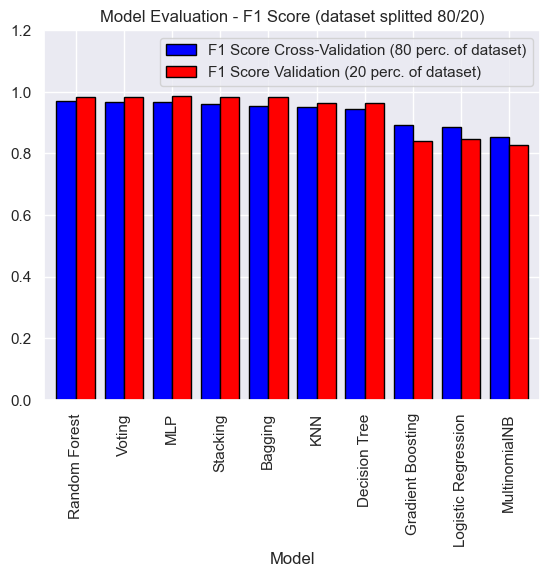

In [ ]:
# merge the df_f1_score and f1_score_df dataframe
df_f1_score_plot = pd.merge(df_f1_score, f1_score_df, on='Model')
df_f1_score_plot.columns = ['Model', 'F1 Score Cross-Validation (80 perc. of dataset)', 'F1 Score Validation (20 perc. of dataset)']

# plotting the bar chart
(
    df_f1_score_plot.sort_values(by=['F1 Score Cross-Validation (80 perc. of dataset)', 'F1 Score Validation (20 perc. of dataset)'], ascending=False)
    .plot.bar(x='Model', y=['F1 Score Cross-Validation (80 perc. of dataset)', 'F1 Score Validation (20 perc. of dataset)'], rot=90, color=['blue', 'red'], edgecolor='black', width=0.8)
)
plt.ylim(0, 1.2)
plt.title('Model Evaluation - F1 Score (dataset splitted 80/20)')

df_f1_score_plot.set_index('Model', inplace=True)

#### 6.5.4. Plotting the ROC Curve of the Models

As the model VotingClassifier parametrized as 'hard', that takes into account the majority of the votes for a class, doesn't have the possibility to access the predict_proba(), we'll not plot the ROC Curve to this model. It's possible to access if we use the parameter as 'soft' that will take into account the probabilities of the models, but it gave us a worst result.

In [ ]:
# get all the predict_proba of the models
y_pred_proba_lr = logistic_regression.predict_proba(X_val_linear)
y_pred_proba_dt = decision_tree.predict_proba(X_val_tree)
y_pred_proba_rf = random_forest.predict_proba(X_val_rf)
y_pred_proba_bagging = bagging.predict_proba(X_val_bagging)
y_pred_proba_mlp = mlp.predict_proba(X_val_mlp)
y_pred_proba_nb = nb.predict_proba(X_val_nb)
y_pred_proba_knn = knn.predict_proba(X_val_knn)
y_pred_proba_gb = gb.predict_proba(X_val_gb)
# y_pred_proba_voting = voting.predict_proba(X_val_voting_pure)
y_pred_proba_stack = stack.predict_proba(X_val_stack_pure)

# get the fpr, tpr, and thresholds of the models
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_val_linear, y_pred_proba_lr[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val_tree, y_pred_proba_dt[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val_rf, y_pred_proba_rf[:,1])
fpr_bagging, tpr_bagging, thresholds_bagging = roc_curve(y_val_bagging, y_pred_proba_bagging[:,1])
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_val_mlp, y_pred_proba_mlp[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val_nb, y_pred_proba_nb[:,1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val_knn, y_pred_proba_knn[:,1])
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_val_gb, y_pred_proba_gb[:,1])
# fpr_voting, tpr_voting, thresholds_voting = roc_curve(y_val_voting_pure, y_pred_proba_voting[:,1])
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_val_stack_pure, y_pred_proba_stack[:,1])

# get the auc of the models
auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_bagging = auc(fpr_bagging, tpr_bagging)
auc_mlp = auc(fpr_mlp, tpr_mlp)
auc_nb = auc(fpr_nb, tpr_nb)
auc_knn = auc(fpr_knn, tpr_knn)
auc_gb = auc(fpr_gb, tpr_gb)
# auc_voting = auc(fpr_voting, tpr_voting)
auc_stack = auc(fpr_stack, tpr_stack)

# store in a dataframe the auc of each model
auc_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'MLP', 'MultinomialNB', 'KNN', 'Gradient Boosting', 'Stacking'],
                          'AUC Validation': [auc_lr, auc_dt, auc_rf, auc_bagging, auc_mlp, auc_nb, auc_knn, auc_gb, auc_stack]})
auc_df.set_index('Model', inplace=True)
auc_df.sort_values(by=['AUC Validation'], ascending=False)


Model  AUC Validation
2        Random Forest        1.000000
8             Stacking        1.000000
3              Bagging        0.998593
6                  KNN        0.997967
4                  MLP        0.987179
1        Decision Tree        0.963415
7    Gradient Boosting        0.951767
0  Logistic Regression        0.917292
5        MultinomialNB        0.886648

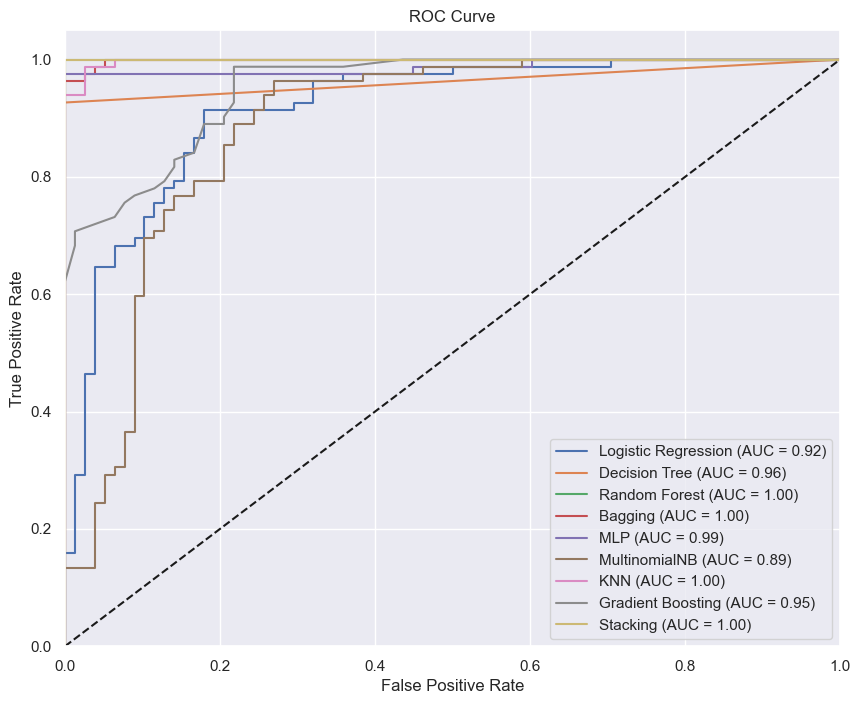

In [ ]:
# plotting the auc curve of each model
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % auc_lr)
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.2f)' % auc_dt)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_bagging, tpr_bagging, label='Bagging (AUC = %0.2f)' % auc_bagging)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (AUC = %0.2f)' % auc_mlp)
plt.plot(fpr_nb, tpr_nb, label='MultinomialNB (AUC = %0.2f)' % auc_nb)
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % auc_knn)
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = %0.2f)' % auc_gb)
# plt.plot(fpr_voting, tpr_voting, label='Voting (AUC = %0.2f)' % auc_voting)
plt.plot(fpr_stack, tpr_stack, label='Stacking (AUC = %0.2f)' % auc_stack)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### 6.5.5. Plotting the Precision-Recall Curve

As the model VotingClassifier parametrized as 'hard', that takes into account the majority of the votes for a class, doesn't have the possibility to access the predict_proba(), we'll not plot the Precision-Recall Curve to this model. It's possible to access if we use the parameter as 'soft' that will take into account the probabilities of the models, but it gave us a worst result.

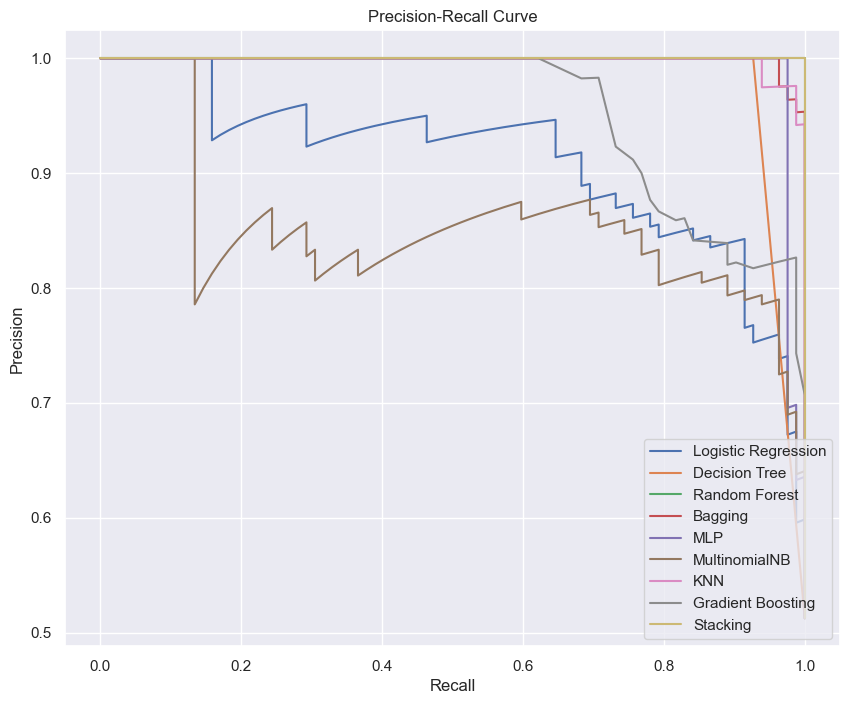

In [ ]:
# evaluating precission and recall of each model
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_val_linear, y_pred_proba_lr[:,1])
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_val_tree, y_pred_proba_dt[:,1])
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_val_rf, y_pred_proba_rf[:,1])
precision_bagging, recall_bagging, thresholds_bagging = precision_recall_curve(y_val_bagging, y_pred_proba_bagging[:,1])
precision_mlp, recall_mlp, thresholds_mlp = precision_recall_curve(y_val_mlp, y_pred_proba_mlp[:,1])
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_val_nb, y_pred_proba_nb[:,1])
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_val_knn, y_pred_proba_knn[:,1])
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_val_gb, y_pred_proba_gb[:,1])
# precision_voting, recall_voting, thresholds_voting = precision_recall_curve(y_val_voting_pure, y_pred_proba_voting[:,1])
precision_stack, recall_stack, thresholds_stack = precision_recall_curve(y_val_stack_pure, y_pred_proba_stack[:,1])

# plot the precision recall curve of each model
plt.figure(figsize=(10, 8))
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_dt, precision_dt, label='Decision Tree')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.plot(recall_bagging, precision_bagging, label='Bagging')
plt.plot(recall_mlp, precision_mlp, label='MLP')
plt.plot(recall_nb, precision_nb, label='MultinomialNB')
plt.plot(recall_knn, precision_knn, label='KNN')
plt.plot(recall_gb, precision_gb, label='Gradient Boosting')
# plt.plot(recall_voting, precision_voting, label='Voting')
plt.plot(recall_stack, precision_stack, label='Stacking')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

#### 6.5.3. Evaluating Precision and Recall

In [ ]:
# calculating precision and recall of each model
precision_lr = precision_score(y_val_linear, y_pred_lr)
precision_dt = precision_score(y_val_tree, y_pred_dt)
precision_rf = precision_score(y_val_rf, y_pred_rf)
precision_bagging = precision_score(y_val_bagging, y_pred_bagging)
precision_mlp = precision_score(y_val_mlp, y_pred_mlp)
precision_nb = precision_score(y_val_nb, y_pred_nb)
precision_knn = precision_score(y_val_knn, y_pred_knn)
precision_gb = precision_score(y_val_gb, y_pred_gb)
precision_voting = precision_score(y_val_voting_pure, y_pred_voting)
precision_stack = precision_score(y_val_stack_pure, y_pred_stack)

recall_lr = recall_score(y_val_linear, y_pred_lr)
recall_dt = recall_score(y_val_tree, y_pred_dt)
recall_rf = recall_score(y_val_rf, y_pred_rf)
recall_bagging = recall_score(y_val_bagging, y_pred_bagging)
recall_mlp = recall_score(y_val_mlp, y_pred_mlp)
recall_nb = recall_score(y_val_nb, y_pred_nb)
recall_knn = recall_score(y_val_knn, y_pred_knn)
recall_gb = recall_score(y_val_gb, y_pred_gb)
recall_voting = recall_score(y_val_voting_pure, y_pred_voting)
recall_stack = recall_score(y_val_stack_pure, y_pred_stack)

# create a dataframe to store the precision and recall of each model
precision_recall = pd.DataFrame(
    {
        'precision': [precision_lr, precision_dt, precision_rf, precision_bagging, precision_mlp, precision_nb, precision_knn, precision_gb, precision_voting, precision_stack],
        'recall': [recall_lr, recall_dt, recall_rf, recall_bagging, recall_mlp, recall_nb, recall_knn, recall_gb, recall_voting, recall_stack]
    },
    index=['Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'MLP', 'MultinomialNB', 'KNN', 'Gradient Boosting', 'Voting', 'Stacking']
)
precision_recall.sort_values(by=['precision', 'recall'], ascending=False)

precision    recall
MLP                   1.000000  0.975610
Random Forest         1.000000  0.963415
Bagging               1.000000  0.963415
Voting                1.000000  0.963415
Stacking              1.000000  0.963415
Decision Tree         1.000000  0.926829
KNN                   0.987179  0.939024
Logistic Regression   0.851852  0.841463
Gradient Boosting     0.841463  0.841463
MultinomialNB         0.811765  0.841463

#### 6.5.3. Evaluating Confusion Matrix

In [ ]:
# calculating confusion matrix of each model
confusion_matrix_lr = confusion_matrix(y_val_linear, y_pred_lr)
confusion_matrix_dt = confusion_matrix(y_val_tree, y_pred_dt)
confusion_matrix_rf = confusion_matrix(y_val_rf, y_pred_rf)
confusion_matrix_bagging = confusion_matrix(y_val_bagging, y_pred_bagging)
confusion_matrix_mlp = confusion_matrix(y_val_mlp, y_pred_mlp)
confusion_matrix_nb = confusion_matrix(y_val_nb, y_pred_nb)
confusion_matrix_knn = confusion_matrix(y_val_knn, y_pred_knn)
confusion_matrix_gb = confusion_matrix(y_val_gb, y_pred_gb)
confusion_matrix_voting = confusion_matrix(y_val_voting_pure, y_pred_voting)
confusion_matrix_stack = confusion_matrix(y_val_stack_pure, y_pred_stack)

# create a list of models name
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'MLP', 'MultinomialNB', 'KNN', 'Gradient Boosting', 'Voting', 'Stacking']

# create a list of true positive values
tn = [confusion_matrix_lr[1,1], confusion_matrix_dt[1,1], confusion_matrix_rf[1,1], confusion_matrix_bagging[1,1], confusion_matrix_mlp[1,1], confusion_matrix_nb[1,1], confusion_matrix_knn[1,1], confusion_matrix_gb[1,1], confusion_matrix_voting[1,1], confusion_matrix_stack[1,1]]

# create a list of false negative values
fp = [confusion_matrix_lr[1,0], confusion_matrix_dt[1,0], confusion_matrix_rf[1,0], confusion_matrix_bagging[1,0], confusion_matrix_mlp[1,0], confusion_matrix_nb[1,0], confusion_matrix_knn[1,0], confusion_matrix_gb[1,0], confusion_matrix_voting[1,0], confusion_matrix_stack[1,0]]

# create a list of false positive values
fn = [confusion_matrix_lr[0,1], confusion_matrix_dt[0,1], confusion_matrix_rf[0,1], confusion_matrix_bagging[0,1], confusion_matrix_mlp[0,1], confusion_matrix_nb[0,1], confusion_matrix_knn[0,1], confusion_matrix_gb[0,1], confusion_matrix_voting[0,1], confusion_matrix_stack[0,1]]

# create a list of true negative values
tp = [confusion_matrix_lr[0,0], confusion_matrix_dt[0,0], confusion_matrix_rf[0,0], confusion_matrix_bagging[0,0], confusion_matrix_mlp[0,0], confusion_matrix_nb[0,0], confusion_matrix_knn[0,0], confusion_matrix_gb[0,0], confusion_matrix_voting[0,0], confusion_matrix_stack[0,0]]

# create a dataframe to store the true positive, false negative, false positive, and true negative values
confusion_matrix_values = pd.DataFrame(
    {
        'tp': tp,
        'fn': fn,
        'fp': fp,
        'tn': tn
    },
    index=models
)
confusion_matrix_values

tp  fn  fp  tn
Logistic Regression  66  12  13  69
Decision Tree        78   0   6  76
Random Forest        78   0   3  79
Bagging              78   0   3  79
MLP                  78   0   2  80
MultinomialNB        62  16  13  69
KNN                  77   1   5  77
Gradient Boosting    65  13  13  69
Voting               78   0   3  79
Stacking             78   0   3  79

#### 6.5.4. Evaluating All Metrics

In [ ]:
# merge the dataframes df_f1_score_plot, precision_recall, auc_df, and confusion_matrix_values into one dataframe
models_evaluation = pd.concat([df_f1_score_plot, precision_recall, auc_df, confusion_matrix_values], axis=1)
models_evaluation.sort_values(by=['F1 Score Validation (20 perc. of dataset)'], ascending=False)

F1 Score Cross-Validation (80 perc. of dataset)  \
MLP                                                            0.967   
Random Forest                                                  0.969   
Bagging                                                        0.953   
Voting                                                         0.968   
Stacking                                                       0.961   
KNN                                                            0.951   
Decision Tree                                                  0.945   
Logistic Regression                                            0.884   
Gradient Boosting                                              0.891   
MultinomialNB                                                  0.854   

                     F1 Score Validation (20 perc. of dataset)  precision  \
MLP                                                   0.987654   1.000000   
Random Forest                                         0.981366   1.000000   
Bagging                                               0.981366   1.000000   
Voting                                                0.981366   1.000000   
Stacking                                              0.981366   1.000000   
KNN                                                   0.962500   0.987179   
Decision Tree                                         0.962025   1.000000   
Logistic Regression                                   0.846626   0.851852   
Gradient Boosting                                     0.841463   0.841463   
MultinomialNB                                         0.826347   0.811765   

                       recall  AUC Validation  tp  fn  fp  tn  
MLP                  0.975610        0.987179  78   0   2  80  
Random Forest        0.963415        1.000000  78   0   3  79  
Bagging              0.963415        0.998593  78   0   3  79  
Voting               0.963415             NaN  78   0   3  79  
Stacking             0.963415        1.000000  78   0   3  79  
KNN                  0.939024        0.997967  77   1   5  77  
Decision Tree        0.926829        0.963415  78   0   6  76  
Logistic Regression  0.841463        0.917292  66  12  13  69  
Gradient Boosting    0.841463        0.951767  65  13  13  69  
MultinomialNB        0.841463        0.886648  62  16  13  69

### 6.6. Evaluating F1 Score of the Models in the Full Dataset to choose the submission on Kaggle (100% of the dataset)

We'll evaluate now the F1 score of each model, but considering the full dataset, because we best model to be submitted on kaggle.

In [ ]:
# create a list of models
models = [logistic_regression, decision_tree, random_forest, bagging, mlp, nb, knn, gb, voting, stack]
# create a list of model names
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging', 'MLP', 'MultinomialNB', 'KNN', 'Gradient Boosting', 'Voting', 'Stacking']
# create a list of scalers
scalers = [
    MinMaxScaler(feature_range=(-1, 1)), 
    MinMaxScaler(feature_range=(-1, 1)), 
    StandardScaler(), 
    RobustScaler(), 
    RobustScaler(), 
    MinMaxScaler(feature_range=(0,1)), 
    RobustScaler(), 
    None,
    None,
    None
    ]
# create a list of outlier removal
is_outlier_removals = [False, False, False, False, False, True, False, False, False, False]
# create a list of one hot encoder
one_hot_encoders = [True, True, True, True, True, True, True, True, False, False]
# create a list of X_train
X_train_list = [X_linear, X_tree, X_rf, X_bagging, X_mlp, X_nb, X_knn, X_gb, X_voting, X_stack]
# X_train_list = [X_train_linear, X_train_tree, X_train_rf, X_train_bagging, X_train_mlp, X_train_nb, X_train_knn, X_train_gb, X_train_voting_pure, X_train_stack_pure]
# create a list of y_train
y_train_list = [y_linear, y_tree, y_rf, y_bagging, y_mlp, y_nb, y_knn, y_gb, y_voting, y_stack]
# y_train_list = [y_train_linear, y_train_tree, y_train_rf, y_train_bagging, y_train_mlp, y_train_nb, y_train_knn, y_train_gb, y_train_voting_pure, y_train_stack_pure]
# create a list of type of dataset full, filter, wrapped or embedded for each model
dataset_types = ['wrapper', 'wrapper', 'filter', 'filter', 'filter', 'full', 'filter', 'embedded', 'filter', 'filter']

# create a dataframe to store the results
df_results = pd.DataFrame(columns=['Model', 'Dataset Type', 'Scaler', 'Outlier Removal', 'One Hot Encoder', 'F1 Score Average Train', 'F1 Score CrossValidation'])
# create a dataframe to store the model name and the f1 score
df_f1_score = pd.DataFrame(columns=['Model', 'F1 Score CrossValidation (100 perc. of dataset)'])

# create a counter to store the index of the dataframe
counter = 0
# loop through the list of models
for model, model_name, scaler, is_outlier_removal, one_hot_encoder, X_train, y_train, data_type in zip(models, model_names, scalers, is_outlier_removals, one_hot_encoders, X_train_list, y_train_list, dataset_types):
    print('model_name', model_name, 'data', data_type, 'scaler', scaler, 'outlier_removal', is_outlier_removal, 'one_hot_encoder', one_hot_encoder)
    # calculate the f1 score average
    f1_score_average = calculate_f1_score_average(model, scaler, is_outlier_removal, one_hot_encoder, X_train, y_train)
    # store the results in the dataframe
    df_results.loc[counter] = [
        model_name, 
        data_type,
        scaler, 
        is_outlier_removal, 
        one_hot_encoder, 
        f1_score_average['F1 Score Train'], 
        f1_score_average['F1 Score CrossValidation']]
    # store the results in the dataframe
    df_f1_score.loc[counter] = [
        model_name, 
        f1_score_average['F1 Score CrossValidation (float)']]
    # increase the counter
    counter += 1

# adjusting names for voting and stacking because they have the treatments in the dataset on the pipeline
df_results.loc[df_results['Model']=='Voting', 'Scaler'] = 'bagging|mlp: RobustScaler(), randomForest:StandardScaler()'
df_results.loc[df_results['Model']=='Stacking', 'Scaler'] = 'bagging|mlp: RobustScaler(), randomForest:StandardScaler()'
df_results.loc[df_results['Model']=='Stacking', 'One Hot Encoder'] = True
df_results.loc[df_results['Model']=='Voting', 'One Hot Encoder'] = True

model_name Logistic Regression data wrapper scaler MinMaxScaler(feature_range=(-1, 1)) outlier_removal False one_hot_encoder True
model_name Decision Tree data wrapper scaler MinMaxScaler(feature_range=(-1, 1)) outlier_removal False one_hot_encoder True
model_name Random Forest data filter scaler StandardScaler() outlier_removal False one_hot_encoder True
model_name Bagging data filter scaler RobustScaler() outlier_removal False one_hot_encoder True
model_name MLP data filter scaler RobustScaler() outlier_removal False one_hot_encoder True
model_name MultinomialNB data full scaler MinMaxScaler() outlier_removal True one_hot_encoder True
model_name KNN data filter scaler RobustScaler() outlier_removal False one_hot_encoder True
model_name Gradient Boosting data embedded scaler None outlier_removal False one_hot_encoder True
model_name Voting data filter scaler None outlier_removal False one_hot_encoder False
model_name Stacking data filter scaler None outlier_removal False one_hot_encod

Text(0.5, 1.0, 'Model Evaluation - F1 Score (100% dataset) - F1 Score Function')

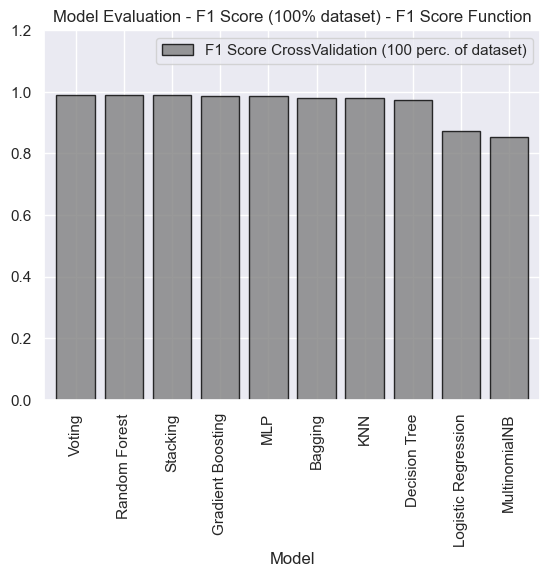

In [ ]:
# plotting the bar chart
(
    df_f1_score.sort_values(by=['F1 Score CrossValidation (100 perc. of dataset)'], ascending=False)
    .plot.bar(x='Model', y=['F1 Score CrossValidation (100 perc. of dataset)'], rot=90, color=['gray'], edgecolor='black', width=0.8, alpha=0.8)
)
plt.ylim(0, 1.2)
plt.title('Model Evaluation - F1 Score (100% dataset) - F1 Score Function')

### 6.7. Final Model

The model choosen was the votingClassifier() with three estimators with pipeline. 

The models are:

- random forest

<pre><code>RandomForestClassifier(
    random_state=42, 
    bootstrap=False, 
    max_depth=None, 
    max_features=1, 
    max_samples=None, 
    n_estimators=50
    )</code></pre>

- bagging with knn

<pre><code>BaggingClassifier(
    bootstrap=False, 
    max_features=0.8, 
    max_samples=0.8, 
    n_estimators=300, 
    random_state=42
    )</code></pre>

- mlp classifier

<pre><code>MLPClassifier(
    activation='tanh', 
    alpha=0.05, 
    hidden_layer_sizes=17, 
    learning_rate='constant', 
    max_iter=2000, 
    solver='lbfgs', 
    random_state=42
    )</code></pre>

We used the configuration of voting='hard'

And we achieve a F1 Score Validation of 0.991

In [ ]:
#fitting voting with total dataset
voting.fit(X_voting, y_voting)

# generating the output file for the test dataset
X = df_test_final_filter.copy()

predictions = voting.predict(X)
kaggle_submission = pd.DataFrame({'Disease': predictions}, index=df_test_final_filter.index)
kaggle_submission.to_csv('votingclassifier_finalmodel.csv')